In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

#### 3.1. Load Data:

Complete the followed cell for data loading. 
In this cell you have to normalize, split and shuffle data for learning.

In [2]:
T=torchvision.transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])

train_val=torchvision.datasets.FashionMNIST('~/.pytroch/F_MNIST_data',download=True,train=True,transform=T)
tst=torchvision.datasets.FashionMNIST('~/.pytroch/F_MNIST_data',download=True,train=False,transform=T)



##################################################################################
# TODO: Use 'torchvision.datasets.FashionMNIST' class for loading FashionMNIST   #
# dataset. This dataset has 50000 data for training and 10000 data for test      #
# and every data has shape (1*28*28).                                            #
# Also Use 'torchvision.transforms.Compose' for common image transformations     #
# such as normalization and use 'torch.utils.data.DataLoader' class that it      #
# represents a Python iterable over a dataset and divides data to Batches.       #
# Then Split data into 3 part: Train, Validation and Test. Finally,              #
# save iterable data in 'trainloader', 'validationloader', 'testloader'.         #
##################################################################################

##################################################################################
#                               End of your code                                 #
##################################################################################


In [3]:
batch_size_train = 64
batch_size_test =  64

Ind=[i for i in range(len(train_val))]
np.random.shuffle(Ind)

Tr_sampler=torch.utils.data.sampler.SubsetRandomSampler(Ind[int(0.2*len(train_val)):])
Vl_sampler=torch.utils.data.sampler.SubsetRandomSampler(Ind[:int(0.2*len(train_val))])
trainloader = torch.utils.data.DataLoader(train_val,sampler=Tr_sampler,batch_size=batch_size_train)
validationloader = torch.utils.data.DataLoader(train_val,sampler=Vl_sampler,batch_size=batch_size_train)
testloader = torch.utils.data.DataLoader(tst,batch_size=batch_size_test)


classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

#### 3.2. Load Data Test:

In [4]:
############################################################
# Run the following code an check the size of each batch   #
############################################################
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
print('The size and type of each batch in ''trainloader'' is:')
print(example_data.size())
print(type(example_data))
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
print('\nThe size and type of each batch in ''testloader'' is:')
print(example_data.size())
print(type(example_data))

The size and type of each batch in trainloader is:
torch.Size([64, 1, 28, 28])
<class 'torch.Tensor'>

The size and type of each batch in testloader is:
torch.Size([64, 1, 28, 28])
<class 'torch.Tensor'>


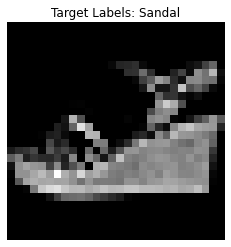

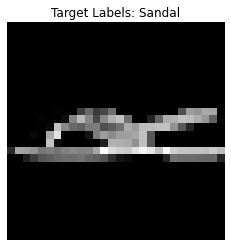

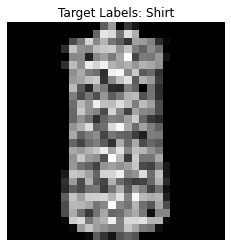

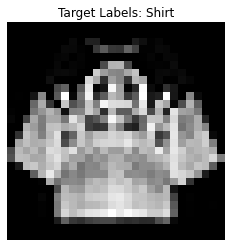

In [5]:
#####################################################################
# Run the following code and see some of the samples in the dataset #
#####################################################################

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images:
for i in range(4):
    img=torchvision.utils.make_grid(images[i])
    ###########################################################
    #  If you normalize data , here unnormalize them to see   # 
    #  them clear .                                            #
    ###########################################################
    m=0.5
    s=0.5
    img = img*s + m    # unnormalize
    ###########################################################
    #                   End of your code                      #
    ###########################################################
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2, 0)))
    plt.title("Target Labels: {}".format(classes[labels[i]]))
    plt.axis('off')
    plt.show()
    

#### 3.3. Network Design:
Design the layer of your network and select proper hyperparameter. 



* model source https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4 

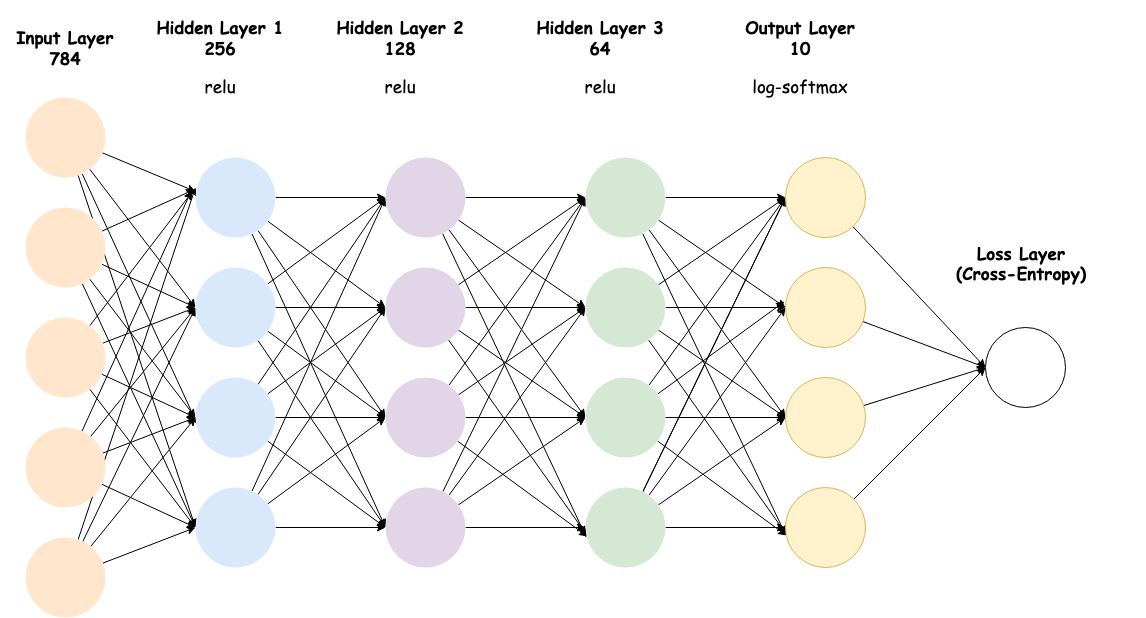

In [6]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAABHoAAAJqCAYAAABUySfUAACAAElEQVR42uzdCZxbZdn//++d2Vq6r9MplLV7oUApyAO4sAqyyGpRAUUfdhFQEVBElkcFFxCRRYUfPCAii4gUkUVEBcUHyk5pCy0FCu3MdKPTfSbJ/X+lXOF/c0gyycxkZpJ83q9Xm8nJyXKuc98551y5l5gAAAAAAABQFkj0AAAAAAAAlAkSPQAAAAAAAGWCRA8AAAAAAECZINEDAAAAAABQJkj0AAAAAAAAlAkSPQAAAAAAAGWCRA8AAAAAAECZINEDAAAAAABQJkj0AAAAAAAAlAkSPQAAAAAAAGWCRA8AAAAAAECZINEDAAAAAABQJkj0AAAAAAAAlAkSPQAAAAAAAGWCRA8AAAAAAECZINEDAAAAAABQJkj0AAAAAAAAlAkSPQAAAAAAAGWCRA8AAAAAAECZqCIE6CFjJPWVtDbHOiMleUltBb72WElfk/SupBVdsF5X20xSH0mtZbx/J9g2rqY8U57LwKAy3z7qB/Wjo5z9aOgp5qAOAQBQ2ba1k0JvF1CZbGmPL5JUbcsulHSfJRFyudmee1MXrdeVBkpqsffdvAz37RBJ99v2PUh5pjyXsH6SLpH0om1fk6TrJE3nK5z6Qf3QFEnXWL1Ibd88SRdYvUHxjJN0rqQHrGwtkHSXpFMk1ZTh9pb7ORMAAGVln+DEf1yWdb4VrNNHUkNw//J2Xv9xW+/WLlqvK+0cbMd+ZbZfd7ALtfT2/ZPyTHkuURPswtVn+bcLX+PUjwquH5/IUTfup7V40eyXI+7pZNvIDrzuDy1htHORP39H3qecz5kAoKgYowc9Xe6yNdPf1W7fkbRB0hJJl0r6cx4n6kPtdm0XrdeVwhPgjWW2X6+VtEVwfx3lmfJcon4iabz9/bCkz0n6n+DxL/I1Tv2o4Pox2m6bJV0h6QRJf7Rlh0qaTLHvcsdKejS4/4SkH0m6StJrtiz1nXV1B177q9by7vAib0NH3qecz5kAoKiqCQF6QNi8OFuf637BiWTaZXYbz3AhsZWk4fZrUfqEfmUH10ufXFRl+HwDJB0i6SlJb9qvZ1tLeiXPxEZ1HtueLWaFjF3hsoyZkG27MhkmaVWGeGfzK/uM21tc1lGeKc8lWp5/ZQmHn0p62pb92boTqYA6AepHOdaP31sM5ls9SfmXpCPs71SMXqbod5nUvvl1cP8zkv4S3D9X0t0W/2MlnSNpqbVMfC2yT0fa2HnrrRXuIBs/S9ZSaz+rhy9Z3TlS0h8kLc+RiOns+1TqORMAAGXnsKAp7vAs66Sb2T9p94dbP+1FNjBf2lFB/+3ov3M7sN4ONrZMet3URd7FwcXK9235szZeR/g6+TRH3qOA9eskXSRpdjB+xbXWT32QLX/KxsUJTbEm3PcVsF2H2WMX2LgkLcF77lDg/k3vu9spz5TnMijPaT8NtvUgvsapH9SPTRfHO0o6LdLVcVuKfZe6PIjtEVnWCbt17RmU3VuCdXYOxhv7ZDvdwKZLeijohv1PKyepunBm8Jpd8T4cYwAAKBNHRcZj6C/pY5KOk/RdSTcGB82HMpzEpA+in2/nBOK/C1xv9xzrXJbhYi/675E8tv1Twfq5mrcPCQaBjf77p50cpe9fF3nuI5H45rNd1+dY54IOJnpupjxTnsugPA8JBvJNn8gP4Guc+kH92DQYc/T5V1Lku5QLYvu03c9karDeDBus2dvxOO34YJ3926knewQDbWf6d6q9Zle8T6UfYwAAKBszIoMH5joJuMee89lg2Xb2K28428dX7UTnjmC9YwpYz9lJlLeLjjOsm0Z6ncfsc1we+XzXRA747TkoWHdsjvVuD9a7w34VWxAMdhmzX6bS63zMnhf+evarArbr5gwn6/M6mLBJJ3p+TXmmPJd4ef5k5GJnkXVLAfWD+vHR+Hhr4YGus0UQ29NzrHdgsN5eQdLjtmCd04N1+ltyZGqw7uNWTofZ+vMi333XBOUy3aW1K96n0s+ZAAAoG1/McaLfYs33feTkIXxOgx2k0/cPDF47nK3lsALW2zG4f729b/i5TrLnXZfhgB/+etXe9KZHB+uOybLOqGCdO4Pl6ZOWn9r93TN8lgeDZRMK2K7wpOUAW/aLyC/ghSZ6rqc8U55LuDwfEnnt1MVDPV/f1A/qxweqJE2zQYGbmB2pKPbJM64XBOuNDmbAvCpY5/xgnXCQ9AcjLerSng66LqZbMR4ZvEZtF71PpZ8zAQBQNv47OEDeaL/+7BkMlik7sUg9fpPdPyl4zuDIhUC/4HkjIyf0+a53VJYLkUXWFSAtPOh/wpadEizr2862hxcJ2S4aw1+wdg+Wp38t+kGw7K5g3XMynOzku103Z+iOEIvMokWih/JcKeV5XOT1j+Brm/pB/cgp7G53McW+y3w8iOuhWdbpEyTaFlmrlGczHIe/m6U12j2RMbLSHrPlDwTLdo2MmdMV70MdAoAiYHr1zIYyI1nR4yubkeG/7VfTf0laEayz3m77223YLz0ezPQhm1klLTyxqC5gvcGRz/iSjSGxrf2SnzbIbl+1ft+KzLDQv51tD8f22JBlnbDsJYO/m+w2vLj4XvB3ODbCFXab73Ypw7YkbbrjjvKUZ8pziZbnfYO/9w6mjgb1g/rxfguGiyOD2v4r+LuBYt9lXgz+PiXLefv/WDJTtl9S5X1JpP6lJLK8x7oMZS2sl+HyMJFR20XvwzkTAPTSRM+W9qvXQ/ZL/mM2cv2N1ld7hh0MSsWeNo3kszkGvUPXnPgvzbHOxshBPjyY1tjUrmk/l7SLnZSHg+BtVsB6s4P7f7ZfrX5n40N8Q9KtdlKf/jwLg/VXFnCCOyj4e7U1fZ9kv1qlx39YFaxziJXDPkF93TF4fJ6kGyLv8bCk5+zvfLerK/S1X9NG2/0JFm/KM+W51MrzPsHf02xWlZ9ZF4DUSf9AvsapHxVcP+6x87t77T02tzqS9jTFvsu0SPqT/X2wtUiZajNMTbZy9E17/B1Jv40kOXay8jQ6ODZHpRMzfSLL04mV4ZbU21bS14LHX++i96nUcyYA6PW+3c7git5OjHvCD62P7s4FPOfM4HNvxu4til9ZfF/Msc4DkSa+x2eYovfmdsrdtwpYrzYyVoTPMD3vmKA/92PBZ909Q1/tbC6LzNqSaQrgr0QGQVyQYb1w+toxkcc+GTyW73alY/RgJ/brfVniuwPlmfJcYuX58XZifAdf49SPCq4f1+aI7wIuhIuSLF3UTrleFBms+MvtrB+61ZbNjiy/K8fzb+7C96nUcyYAKKquaNHze0m3WNP2sMnia3bbLGluD23fV+3L/fACnhM2AW2liBTVshyPheVHdhCX/aLTYn9/XdJvMjz3ncjr57Neqw36F3bRGBC85+l2IjU3WJY2P/i7vSbJbwV/759hmua/WOu444PPt62tF75neGIS/sL8jKR/RMpwPtu1OsN2FerlDM9/I/jFj/JMeS6V8nxd8NxmK8dvBPvveb6+qR8VXD/OzdAqIuUJS36tobh3qRWWYLwly+PP2OPzI0mVv+V5rrvWbl/I8/M8GiRWi/k+5X7OBAAl5frgl4WoLW2gxHQzzO2s+WlVsM5wSSe3M+XiZjZQZtSYIHG1g00v2RJM5bifvV8+JzC+A+OL1BS4frZuYbWRmORK0o0s0XIyyZrc7t7Ofj4g0l966wz9p9P7/kBr1rylxWZCJ9bbysboOMTKabivBtrUvyMiz5kh6aw8miSnThgusl+m7pD0Y0lnZ9hW2WCi+1jC8mCLyVSb7jP8xfSUyNTB2eTarjF24rZtF+1jV0FdHynP5VmeHd13qR/Uj5zqrGvLZ20/M+5j8W1t5eMMmwGroZ3vsMnWqn4fe+75Vn5Do61LVvS10oMnz7NyeZKkPTKco3b2fThnAoAScEuOZplPBs09w2aR84Iv64ds2T/tX4uNlXNmhtf5crDsDFt2l42xk6sZ6fR2tuH8AhI9dXYAmh0kuK61/uq7WUuGTDMPHWXb9q1g2dGSnopM/Rh2efuBPefzkZlAniqwvzPKSyxosryIQcRBeQaoH0AXuDf4sZQ6BAAVLt2f99kMj72YI/mSHiixKcc6p1o2PX0/HDn/piBpNK2dRM8e7WzDRUGf3FyG5Nimf0ambQx/1RgUtDRK9/s/I8fnTY8BsCDHOntS9CrWbkE5OJtwgPIMUD+ALlCOiR7qEICK0dXNbNNNIzNNrRiP3D/d+sbKmv6mvBc8/o6kX9q4CLLB1sKpPBcHf6f7z66ykfOH2ij7L9nyv1t3r+GS/t3ONqQHYF7fznq/DLqC/V7Sp4LP+p41MU333f1NMEvL14PPe6N1v/ql3U993mMl3R05KCnS7PSdyCwi21GUK1aYuLyTcIDyDFA/gC6QPm/fSB0CAKS7XmWaWjNskfJdW3ZT5NeCp4MWQelkyJHB88YFfx8RvPYjwYj8ofSMGQ8VsA3XBKP2ZzMq+Bx3ZtjGn9r9cyPb3C9ozZNuMhq25jkvw2j/k+21moKWRlvYsnTz0+0pehVrW5vt6hBCAcozQP0Ausjedl59EHUIAJAr0dMSJCrSY/LcGZlS9TG7/0DwvF2DpMfHg7+PDdZ5LMs0h/dEXj8fYTewbA4KPkc4wGQ68fIDu79ZpDvahZGuaCm/yNId68mgpZOC1zk/WLZZhkEiAQAAAABAherOGRLSLXRuCrpopacvT3fJSneXCqcs3SL4O5zufFDwd7qrWLR72LoMr5fv58w1PWg4eFsy+Lsp8n7rrJVO2mV2u9qmpFSkO1rKTJsGcq+ga1soHtm+pRRjAAAAAACgLkz0DLFBkIfa/a0kfduSHAdFEiPvBH+vsNsxdrvBbofba25rUzGmvS6p2f7eyaYi3zbLFKwKEkCFzEqVfq2lwXN3sy5Wt0r6vqS3gvUPsUGi+wTx3DF4/LeSXou8x/8ESaiXguXftmlKn7KWQldIuoRi2uttZmUxk76WlOxjs7Sl/w2JjLsUVRuMAQV0p5GSdshjvep2ynB0XaCcTc1xHMi07s6EDBV0jvSxDNOyZzr2TA/GygQA9LBJ7cxy5W268fTf3wmeG45h0y+YtSvTv5vtOTfnWCfadevWHNO9Z/NU0MXsqSzvMyHoppUez6clss62wWseHSxviSSmtsrwXB95bQVdt86lyPUKzgYIfywyXtORwTqfyqNujMvw2uOC8Z6+SqjRTVIn4ZcGZTNbcuaT1i02nD3wrAwXuUMkXWnjkXn7Drs+QytGoJT1t+7mqTJ+Wx7rXx/Usb0JH8rckcGxYvcs6+wXOadOD+HAsQIAethu7VzIPi6pxpIt3i4I0g4N1huRI9HziKRh9pyRORIjj2U5obq9gO25vZ3tud4ugHYLLmDCJE767xOD19wrWP6jDO/5sSxTtacu9j9h66QPgidT5HrcgGDa0Uz/TsmzbqTKS33ktUdHxnXaj3CjGwyOJC19ltYJF+Uoz+HA9P2C7/xM4485Qo4yUBOMTejzaIF7YqQucDxHOftppLx/KsM6h+c4pswm2QMAPW+iTVk41qYRz3QSv6V1cwq7UaUuJL4h6Ri7f08wEPJXJZ1krxtt7llrvwwcZ0mS1PtfHhm8OH3R/DVJDQVsyzaWzHnIWg/9wAZO3iPDhU/qYmYf+6wHW3PTqdbNK+zScGdw4Noiy/umYjbFXme/DAmAj1mSbADFrcedEzkROdla9/hIC7Ktg2WX235N/TvQykm0efJmNuNc+jknEGp0k0wJnOj3+PRIkvL79mvt7EjCXtYNNbz43c9aO6SX7UjIUQauDcr0r9rpmjIhQx0j0YNytXeG8h5t0TMoMlHLYdai+aIMs/QCAErcvZHp1svBlsEB6xZ2cVmYYEnJYyMXw+mp8V+0+7tEEj0X2bSe19ivWFFhi7bDCTO60c72vRsmGqP6WPL7wkiS8vvBc4ZFvssXBOuFsyYeSshR4s4IyvNP22mlVhepWyR6UO4GS7o/0lI0muA/O3hsn8hjjwQJIABAGSjHRM83gwPZLuzisvXZDN3zDm6n69blwfN3jHTZO99a9DAgM7rThQWeXI8Nuho+HSwPxyE5zspx2MVlB0KNElYd6ap9gbX8/VSWSS4uD9a9iEQPKsgngvI+KfLYfTnGhAsTqXTfAoAykG7R8FAZbdP9QXc0lOcJ/zcjCZzp9th/R5YvipzYeJutTu2MfXIzsxahm1wYDJzcnoMi40mdETy2R47yfE8es68AvdneOcr3U5Eu2uGF7tPW0iE6nhtQrsLyv13ksXS333szPO/I4HnbE0YAKI+Tp0fsAqJcHGAX95PYvWVny6C7VvrfAcHj4axy11jzfWUYu0cZZpyI/vsW4UY3uDBISmbTV9KvI+Xzosg61TkGY77dBrEFStU17Xxfp2cAbYgkQyfb+H0kelApwkTPVpHH0nXjxxmeFyZ6tiGMAACgu4yNzLr2rI1zEl3nIUnnZRi/IT19+l02gHk4pehEG6TwoKB7AC3C0B0uzDC2TqhfMHZCuovXMRnWuzgya+K5kfpyCaFGCXs6MjNmPxto9qmgjNdnaMHZEuny1WI/FmxGSFGmwkTPmCz16PoMzwtbRPcjjAAAoDvEIhetl3aga9WzwZTUQ7JMy5/yixx92IGu1l6i5+ZIUnJohnVqIkmedJJzSKR7C1CqXrRyfGtk+VFBGd8z0pon179dCSnK1CdyzDqbHtrgyQzP+0WOiQEAAHngwvH9sSJSB5JknutvJWlzSbMktRK+ijQ5OGH5viV6stlG0luR8rVdMDbPbEnvBY9Ff/FKz2K0WlKc0KMHxexCNuVha1qf6TuwIfj7vuBEfaWku60F0O72eknCihL0lg0wvnVkeTho7CpL4OwnaXhwvlUXdHWcKek2S/wD5S6atPm7zcC4p7VknmvL+0qaYX//mbABQGUbbjN1LbJfomfbidOTtvwx+3de8JwDIuOrPG2zJOXyxRxjUqBynB4pBxdZH/Or7LH0yf/XgtYLo23Z2Mg0u7vb8qeClhQDg3VbynAmOvQ+VTbg5Z1Bl5J9Iz8GTA3K7Z3W+udyK/cXBK0S+ke+V+uCi+CmAgZ7BnqrS4MyPjUo348Hy/tmeS5j9KBSbGUziKbL+1esW3radpFjxcdtRsZ7g+WHEUYAqGz75Nk8Ot0d4Ss51tkvy3tMiax3B2GvWBe2U86arPvK1zKMzxDevyl4zeMis3M9lme5BLrCWVnK8mnBOp/I4zt2iq37YGT5i5H7RxBylLBtI9/rD0TKd64xqPowvToqwLQsx4i7Iut9O8fx5GkG7gcAVNmFw9ds0M/v2mCgN0YOGofar2zhALrHRPrVZ5rmsW+GGWRI9FSuqcEsWS2WQFwQjNvzgK3nckybfrmd8KfFJF2WZd2zCDmKbJ8MicgWW542KEjghOV+QZBIr7d1h2QYiJaBmFFOPpulfN+cx+DK6UFo9yGMKFOjgmND+O/cDOtekuH4cw+DMAMAcrkrOGhcYMt2C5YdG6z7WPDLc9QvMhysSPQglud629h4Jt+QdHg7U4VOk3SqpB9I+rI1bQa6k8swS1xHyn1KraQ9rCwfFCSCgHKwtbXGvEzSGUFX3PbUZBiPDajk40qV/Yi2OwkeAEB7Do40/0yPNbFFsPxBO7Acn6NZ6UHBY/cFv8SR6AEAAAAAAOgGVZExISZHHn8gR5/gPYL1RgSDh7bYbFtPB4ORAgAAAAAA9BqxMt2uQ4OZMC6X9Grk8duyPG91MN1vtaT/lTTS7n9d0rsUGQAAAAAAgO4VzljUEHmsIRj0LXX7PUv8hK16hmSYhaYlw2BxsyXtTLgBAAAAAACKY1KQiLk+w+PfCR7fM1h+UWQq6+vznLL9G4QcAAAAAAD0BtVluE0nB39fk+Hxrex2taSnguX3BdP+7izpmzaWz9Y2rXDaWdad61VJP88weDMAAAAAAAC6QP/ITFuZXBKsc1iw/FvB8hNyvAeDMQMAAAAAAHSD44JkzYlZ1tk90vVqkaQFwf1nJdXkeI9/Mr06AAAAAABA8aXH2WmS1CfHesdFkjvh4MqT2nmPH9q63yfcAAAAAAAAxTNU0tmSJuS5/haSjpF0rKTdCphufltJjnADAAAAAAAAAAAAAACgy8UIAQAAAAAAQHkg0QMAAAAAAFAmSPQAAAAAAACUCRI9AAAAAAAAZYJEDwAAAAAAQJkg0QMAAAAAAFAmSPQAAAAAAACUCRI9AAAAAAAAZYJEDwAAAAAAQJkg0QMAAAAAAFAmSPQAAAAAAACUCRI9AAAAAAAAZYJED9BztpZ0s6QJhAKUZ4D6ARSoWtJ1kg4p8e3oK+nLkq6QdDa7FQAAlLLjJHlJpxAKUJ4B6gdQoK2tXN1ZwtvQT9Js2470vyHsWgDoHFr0AD2n2m4ThAKUZ4D6AXSwXMVLeBu+ImmypDcknShpgKSVwePbS2qS9Al2NwDkj0QP0HOqyuAEDaA8A9QP9Gy5aivhbdjXbk+RdIukNZHHt5I0UtKn2d0AkD8SPUDXGCbJZXmsbzsnaOEvvKMl1UXWGyRpICEG5RmgfgDtlKvu1EfSQZJulPSspN068Bq7SFot6Z+R5XWW5Km1+6l6sa2kUXa/WtI3bFn6/pA862N4HVSdYfnukqZmWJ56/XPoWgYAQHnaU9IiO7n4jv3tJT0ZWe/Lkl60x5ok3WEnLWmn22Oft/tjJLVI+mHkdV60/usA5RmgfgBpU61c/SqyfGdJd1kZmyfpjCzPvdbKcqrMXV9AAqPOBk72kX/fD9YZZp9rgdWJa4KkjZN0kqRfBM992j7HRbbOvRleP/1v52DbU3VoP3uf1P3v2Ws32f37MiRzdpD0gMUntc5DkvYIHp9ny8PEVT9JT9ny/Sh6AACUn6/Ygb4lOOlIn1BsYeucEazzeLBeeHHwNVs2w+7vG5y0hFrs4gKgPAPUDyBM6HibeStt9yzJkWMylOt0guXJ4P6oPN73xmD9e2ymLG/JIllXq9kZPsO19vjoHEmce22dA6yVz6JI/brPEqUHBANR+3b+HR989oOD5S/ae3hLFKUdH9T1IZI2k/SgLXuQYgcAQHk6NfLr1WBJl9r9qdb0vsVOEDa353wiOFFJO8eWHWX3P2/3z4y8n+cXXlCeAeoHEDHdyswvgmXP2rJLLEGxV2Rmrm2DJEbYPSmdMNm+nfesDhKf4fOPkLSd/f3jICkywhI7C+x56W6Pk21a+PR6fbK839RIEiltr0gyZ79g25+UNM4Gdw7jMyRI1J5gyxrs/gOR178qSDylE7iPSepPsQNQCqoJAdBhf7ATqZS/SZogaa79ajZA0tftJOtma9avSPPpGrvdYLf97HZ1sE66f3kL4QblGaB+ABnO49cHSZFpNoNVuhvVk5IelfQpu3+y3V4t6aXgtUba7WJ73S9YIrOvJWGarCuWl7TUyv3N9tqp2z/a850lSGVdqJba37+R9CNLBs2X9KqkJfbYqqBuRG2M1A9lqCeflvRXe91pllBNfd4V9nh6HJ8jbDuvl3SrLUuPidUYef3vSPqMPSfl75IOlbSOYgeglA4QAAoX/rr0d/un4BetL9jJT8q/JH1X0j8ynNSnT2KW2204OGd6wPQ2wg3KM0D9AAKbRcrV1nb7cGS9BZL2l1QftNj5c2SdyZZ4XGHdv/438vg7kn4raa0lNv+fJVVS/86z1mm/tETKAEs2vRs8/027nWoJmVAyxzZuiNSh6HN+J+kR+zudOK0N6llq2SS7v4Pd3h28TlskhqGlksbb398lyQOglDDrFtBx2WZdGWy3+9vFwH7WxPgfkfWynfgPyPPkB6A8A9QPVK5ouUonDqOtwqYEyxvs74XB43tZgia97D+Shkoabrd9bVyctfb4n20sn0mSLrZl11jLmfRMYO9FPsP4DMvTZb4mxzZma9GTqSVOs93WB8vSg6lXB4mxsK6ttNvNgmU1NqD6nkHy6Ga6bQEoJSR6gK43126vl7S39emWnfycZrOvKGi6Hz3xHxe8lqeugvIMUD+ADNLJj3Srlzl2+8UgOTlB0sclvWZdvNKtaXYLyuqF9ndT8NorrZyujHSr6mOJFG/l/xJrySObKn2xJUemSdrGllcHXRnnBq+VTrjU5tjGjcH7htKJnjBxlE70jA6WpZNX9dYqSdZiKW2V3W4dfJY7JX3WurZtbd3SxgfbCQC9Hl23gK73gJ3knGYnYU/a7QmSdrUpT68LfnlLn0C9bc/7vKRl9kvxDsGJGEB5BqgfQFq0XM2R9IyVvX/Y3yfZYz+225skfc4GGb7a1v20PbYyj/f8tc1Kdb2kF6xlz9fssfSYOzdIOtfGzUnVgSOtxdBvLRGUlqmFTVQ6YRVt9ZOMPK4gUTU8WPaW3W5hXbwutW5Yqee/Hoyp9Sn7jN+3cXletRZ6KyR91eL0JRuj61aKHgAA5eck+yVr3xzrfNz6xEen+Lwr+KXpGls2JnjeyVmmBn2RsIPyDFA/gMAxVmaODZZtH0xJHk5rHv64e2bk8VMzzN6VzeFZyu2twXv0D6Yt98FMWMMirzXBHvtVjvcbYevcElk+1pZfFSxLT53+rWDZebbscLt/RZY6562+X2uzbEU/647BdgAAgDK0uf1S1V5f7dQJz86SDpP0scigm7JmxHtleN5o+zVpT/u169DISRxAeQaoH0BfS0JGuzUNtpmnTrLuVJnUWrKk1sba8ZK+kef7psrzAdaS51Br1ZOpThxgrd32zjJ9+vb2vt9u5/1OtM8a9algzCFZ4qjFEmBpQyT9NNKda6Ktc6x99mqL1Zh2PsekYAB2AAAAAACAXumblnA5sgfee1fGpQIAAAAAAOiYwTbF+RBrqXakJXmamFUKAAAAAACgtNyfZYydIwgNAJQPV4kb7RfP2lIxNSipUXJqkHdD5fwKeS1RTI1KaokbPf1tigcAAADKyM42Ns1ISQmbAe4+m0ocAFAmyjrR45terlei9TDJHyTnxympBjk3rICXWCbnG+Xd65IeVFXdTFe/QxPFBgAAAAAA9EZll+jxi2dNk3OHyPtDbaaBrtxGL+lZOTdTyeRMt/muz1OEAAAAAABAb1EWiR7f/NxYxZPnSDo8Mn1isS3e1Ny1pvpqN2Kn1yhOAAAAAACgJ5V0oscvndWguC6R/Inyrrrnoujj8rpJtVWXuuHTFlOsAAAAAABATyjJRI9f+fxgrYtfIOlMOde393wwv14xd7X61v7YDZ66kuIFAAAAAAC6U0klevyip/qqquYsSedJGtyLw7pSPnm5kvFr3Jj/Wk8xAwAAAAAA3aFkEj1+6Qvj1dp2v5ybUELxnSsXO9A1THuLogYAAAAAAIotVgof0jfO2lvxtmdKLMmTMlHJxLO+6bl9KWoAAAAAAKDYen2ixy955hx5PSrvBpZkhJ0bpmTyYb/kmVMobgAAAAAAoJh6bdct72fVaIlukzSjjMJ9gxr8152b3kbRAwAAAAAAXa1XJnp889OjFI/9UdLuZRjzf6tGR7sR05dQ/AAAAAAAQFfqdYke3/TsVCX9Q/JqKOO4L1Z11cFu5M4vUAQBAAAAAEBX6VVj9Hi/sI/iyevKPMmTMlqJxDWbthcAAAAAAKCL9K7BmJcsv1XO7VkRkffaS0uW30IRBAAAAAAAXaXXJHr84lnnSzqmwuI/w7YbAAAAAACg03rFGD1+8awD5Nxf5H2s8vaAS0ruYNcw7SGKIwAAAAAA6IweT/T4pc+PUzw+S94NrOC9sErV1bu5ETu9RpEEAAAAAAAd1fMtaNoSt1R0kkebxusZpHj8JoojAAAAAADojB5N9Ph3nzlW0h7shvcHZ7Z4AAAAAAAAdEiPJXq89zG52I/YBeHecD/0lThOEQAAAAAA6BI9l1RofPZkyW/NLgh4bfN+XAAAAAAAAArXI4Mx+2VzB6h17XzJj2QXfGSPNKk2Md4N+1gLwQAAAAAAAIXomRY9bWu/S5InC696bYh9g0AAAAAAAIBCdXuLHr/k+RHyibcl9SH8WffKKrma8W7Ujs0EAwAAAAAA5Kv7W/T4+GUkedqLkQYp2XopgQAAAAAAAIXogUSPPkXYiRMAAAAAAOh63Zro8YtnTZRzEwh7HpybsCleAAAAAAAAeeruFj2HE/JCuAOJAQAAAAAAyBeJnl7Nk+gBAAAAAAB567ZZt/yyuQPUumZVT8z0VcJaVZcY4YZ9rIVQAAAAAACA9nRfi56Nqw8myVOwWm2IfYYwAAAAAACAfHRfosc5um0RNwAAAAAAUETdOUbP7oS7A7zfiSAAAAAAAIB8dGOix40i3B3ZQ8QNAAAAAADkp1sSPd4v7CP5OsLdkeBp0PvxAwAAAAAAyK17WvQ0vkerFOIHAAAAAACKrHsSPbEkiQriBwAAAAAAiqx7Ej0JT6KC+AEAAAAAgCLrnkSPE4kK4gcAAAAAAIqsexI9SVqkED8AAAAAAFBs3TRGj2sk1MQPAAAAAAAUV/ckerxIVBA/AAAAAABQZN2T6KmiRQrxAwAAAAAAxdZNY/TESFQQPwAAAAAAUGTdk+gZNZhERUc5H9eonRYRCAAAAAAA0J5uSfQ4t80GOa0i3B2K3nLnXII4AAAAAACA9sS67Z28e5NwdyhutIYCAAAAAAB56b5Ej/wLhLsjkv8hBgAAAAAAIB/d2KLHP0S4O8IRNwAAAAAAkJfuS/T0ST4oqZWQF6RVtf0fIwwAAAAAACAf3ZboccM+1iLpcUJekMfd8ImrCQMAAAAAAMhHrFvfzek+Qk68AAAAAABAcXRvokdVjDeTP6+qJIkeAAAAAACQt25N9LiGnd+U9/MIe17ResmN3I2p1QEAAAAAQN5i3f+OMVqp5OGJ/3tukaQ9iAQAAAAAAMhX9yd6XPWVkjYQ+pw2XHnt7T+X9BNJL0g6mZAAAAAAAID2dHuix43asVnOXU3ocwXJXX3fX//+mKQ9JX1J0i6S2iSl4jaBAAEAAAAAgExcT7ypX/5/A9Va9ba8BrELPrJLmlXbb2yGadWrJZ1u/96RdJ2ke4kXAAAAAABIi/XEm7phH2uR1+WEP6MfZUjypMQl/ULSxNQ6kr4oqVHS9yQNI2wAAAAAAMD11Bt7/3qdGlfNkdc27IYPdsebahg40blxG/N8Qr2kM6yVz1+tlc8/iWN5WLDCb5loVUPMJUZ5uQbvNdQ5rXDyS5K+qrGqVku2G+reJlIoJ4tnL94y6WINSe9GySUbJD9UcivkY0tizjfGfHLJ6CmjKfeoSLNXzN7StboG7/wop2SDvIbKaYVXbInzrtHX+iVThk6hfqAizHt4xo5Jn9hOiViDnEbHavps5xQb4318lHxyWHXNgGXxttXD5WLLnatu9EouSratny/vlqgquSTm/fwJB/3hJSIJoCwzCz355n7Js1+W9zezG9J7w53oGna5pYPPnmEJn2GSrpV0PQEtDW80+fo2JQ+LeR0k+XFeLnVxm3crLS+3LCbfKLnXnfRgzMVmblvvmogserOml5vqNzgdJpc4SHLjnNTgC2id6Jxf5r1rlPzrisUe7BN3M+t3qKfcoyy83PRyvZM7zHm/qX5Iaiik9a6TW+Y3HRf86zG5B+POz9yhfgfqB0renAePPiBW3fdY75OH9xvQsEaxqoE1dYNqq2oH9K2u7afqmv7adLvpX3/FW9co3rr2/X9t6b9Xr49vXNXqk4nV61cv3kwu9qdk28Y7Jh1896NEGEDZpBZ68s299zEtefYFSTuwJ/wrGjV9R+dcspOvNMVa+ZxmLXyulfQqRb13mb/UT/PJ5CHe+0NtsO2urIte0rPOuZmKxWaOG+GeJ+LoDd6as3SakvFDJHeo5ItQ7t2zkp/pXfXMrSePoNyjtC5gl86ZlkwmD5FPHiq5ItQP/6xcbKaLuZmTR0ymfqA0jhtPfGHI2pa2Q6pq+30pGV/3yT4Dtlg7aMSkgf2HjnU1dQM6/fptG1u0ZsUCv2rpqy0bVr/br6pms8fjbeturateMXO7/f+6ij0AoGTTCz39AXzzczuqLfGUnOtbsXvB+/Wqdh9z9dNf7uJXPt2SPkst6XMXRb7nzG/2Y5OJxDk+5g533o/utuLl3GKX9PdVV1ddve0I9xp7At1p0ezmsUklzpFzh6sby72cWyzv76uOVV+9+aQRlHv0SrObZ49VQue4mA733Vg/nHOLfVL3xapjV08aMYn6gV5nwaPHDEq6fjcoVrNP3/4N/QcMn7DZgKFj5WJVRXvPZDKuNSvma/Wy19ZtWL1kddLH/5Zc+9opEz/7r9XsEQClxvWGD+GXzDpaXndX7l6IHeUaphVzBq1PWtJnn6CVTzPFv3u8tdQ3bEgkLnHOnSjvq3uunLm4vL8pWV116cThbjF7BkUt93OWNrhE/BI5d6JXz5V7Jxf30k2uqvrSLScOp9yjV5izdE5DYtNxQSfKqwePC4rL66aq6upLJw6fSP1ArzDvkROu8cm2k0Ztt2/1oPqdqnrqc7zX9HyiccHfElXVfW4Yv9/NZ7FnAJRUiqG3fBD/7jMXy7nvV9we8P4St/muF3fTuw0PWvk8YUmfv1ENimPhSj+4rTVxgfPuTC/ft/dUerfeO391XV3Vj7ca7Fayp9Cl5X7hysFV6zZc4J3OlFffXnS0Wy/pasX7/nirqYMp9+ih48LCweta113gvD/TS73ouKD1cro6Xpf88dTBU6kf6BHzHjn+okR8w8X1W38iPnSL/6rpLZ9r+dv/blu26F9Vsdo+F43f939/wJ4CUApcb/owfvGsuyQdUznh939wo3c9uofe/ChL+oy2hE/qX4Iq0XmLvO+7oSl5lpzO894P7r2Vf1OS5/I+9bFrxji3nj2HTpX7Rb6vb2k6Kyl/npMG996vXa1UzF0eG1B/zZgxlHt013FhUd+Wppaz5Px58r23fnj5lTG5ywfUD7pmjBtD/UC3mPfIF77qk/4XQ0bvHBux1d59nHO9r274pJrf/NuGVY0vxZ2rOnP8Abfdwp4D0Jv1rkSPX9hHS5Y/JWmnCoj9U2oYto9z22zo4c8x0RI+qX83WsKHqSY76I2lfnw8kbhf0oRS+cxemltTV3XgtkPcW+xBdMS7c5aOjyfjJVXuJT+31rkDGyY3UO5RVHOWzhmfLLHjQqp+uLqqAycPmUz9QFHNfeRLfxo8ctKew8fsOayqpvcP1xlvW6cV7zy1bFXz7L+P3//WY9iDAHqrXpcy98tf2kIbNv5bzo0p47i/I5/cyW2+2/Je9rlOsYTPahvH5w6qSP7mN8b3Tjp3n7wfWIJfBcu98zMm1Fc/xp5EQV9mrzTunYipJMu9k5Z7xWZsNaWeco+ieKXxlb1jzt3nS/K4oOVybsaU+inUDxTFvEe+OL9+2/1GDxq5Q8lNyPJe00trmt74W+PET/92HHsSQC89z+19/NJZDWrTPZL2KMOY/0fVySPcyN0ae/Fn3NPG8TnIEj7XSWKQxhxeb0qcI+kn3vuqkv0ycC7hpTPG11f9ij2KfLz9ypJzFHMlX+7l/RlbTmmg3KNLvdL0yjmxTccFlXD9UMLLnTGlfgr1A11mzgMztvcx//J2076cqN1sZMnWj43rGhMLn7/VVSXd9uMPvnMOexZArzqG99YP5v2sGjXqZnl9sYzifacadLxz09tK5PMOtoTP6ZKesaTPo1SbsJz6mteaE7c5rxlltFk3jKuv+rpzro09jIzlfpavebtv421SOZV7d8OW6+u/7qZT7tE5s/ysmr7NdbfJuzKqH/6G9fUbvz69dM5f0EvNe/jzJ1RV97t6u11PHVwe54FJLZh1w4pE28YzJx54++/YwwB6zZltr/8CXTzrTDldpRL+RUxOCcmf6xp2vaqEy8pnLemzTTBFe2slV56FzX5UWzLxR0m7l+Hm/buuqurorUa4JXxN4kPlfnbzqJjKs9w76d8+Vn30VpNGUO7RIbObZ49S0pfpccH/O1ZVffSkEZOoH+iQ1/76le9sNnDU2ZtPPHJEuW3bO6/evWzD2hU/Hbfvb65gTwPoDWK9/sR79PRrFIt9Ws63lOaVg2+54Ie/vNI17FrqJ0Z/knSAdecaY+P43ChpWiVWnDea/NQ2n3yuTJM8KXtsSCZnvdbsd+JrEh+cyM5rmhpT+ZZ7L+0hn5j17uxmyj0KNq/p5anyvoyPC24Pn0zOmt08m/qBgi385+k/7D9km++UY5InZYvJxwzfbNCY7y188iymXwfQK8RK4tSiftpjSmo3SXNL66rBz1N1za6XX3PLt63708fLoMzMl/QNSXWbZg6TfmO3x1fMyYr3feJKXCfvG8p5O533o30ycU1qe/mqxMKFvk+iLXmdVN7lXt6PjitxTWp72evI/7iwsE+b3HXyaijv6uFHK+mvSW0vex35eu2R479cUzfwqw3jDupXzts5evxn+lVX9z1p3iMnHMdeB9DTYiVz0bn5rvOUaJsm6XzJrezlH/c9SRcoGd/ZjdjpNVv2CUn/KIXucgW4SdIuks6RtL+18rlc0pblXGnaGhO3ym8asLrsOWmv1ubELXxVIrau8Va5yij3kvaKrWuk3CNv6xrX3up85dSPdc1rqB/Iy5wHZmzvqup+vvmko0dWwvZuMfnoEa6q6tp5Dx81kb0PoEfP3UvqonPMf613o6dfoc1qtpNzV8j79b3qA6Y+j/c/Vt+qbdzo6ZenPm/05EjSk2VYjv4j6QRp0y+ZKyU9IWmmdfMqK683Js6X0zGV9CXhvGZs2m5UrLdnN6b2/zEVttkzbLuBnGY3zq6444K8m7Fpu4H2ikrMvzx211MHVdI2j51+2kCfqH6FvQ+gR6/hSvrgsey50WpNfl/Of0XeVffglXC8ZfW63w8c0u/bbsT09sbiOU/SkPdbJpW1Q6y72qRgivZ1pbxBrzfHD5B3f/Hexyrui8K5pHP+4LEjqx/ia7OyvD2n+QD5ZOWWe+8PHjOlgXKPjOY0v3KAr+Djgnc6eMrIKdQPZDTvkeMWbDX1i1vXbTai4urHxrVNybdf+v0b4z992zhKAoAeOU6Xw0b4pS+MV1v8LMkdLflubBrqmiV/j6pjV7mR0+bauDWJPJ44U9KvJD1QAWVs62CK9rst6fNMqW3EgqV+XCKZnCXvB1but4VbVR2L7bbtCPcaX52V4Z1Xl45LKFHZ5V6pcl+12+aTRlDu8SGvLn11nJJ+lq/o44JWxWJVu00aMYn6gQ957dET7hu5zd4HDBq5Q99KjcGq5pfWLV34z4fG7X/LUZQIAN2tLDLsbsROr7nR089Qw7RRkpsu6VJJLxTp7V6YO//NX5963o8uSb1f6n3dyGnzJf1E0rl5vsahkm6TNLgCytibFpd+kh4PEj0nltJGJBKJWyr7YndT18RBbYnETXxtVo6kj1Pu5QfFk3HKPT5aMhKJW3zFHxc0KMlxARFzZh59wsDhE6dVcpInZdDIqZv1Hz5u17kPHfMFSgWA7ubK+vxj+QubqzV+qLw/TIrtI/m6DoRoo+Qfl9P9qq2+3w3b6V2LWyKSKBsiaYGkoXm+8BRJd0ravgLL3XRr4XOsdem6VtLC3vphX2tMHCv5O/i6+KBOfH78qKrfE4fy9vacxmN9knL/QamPuc9vOWkU5R7vX8g2vnJsUqJ+mJj0+Umjtqd+4P368fCxq8dNP6N/VU3fio9FvHWt3ph1w6oJB94xmJIBoFvPXStpY/3iWcNVUz1UycRQJf1QeTdU8kPlNFBeLZJbIedXKOZWKFa1Qm3xFW709GVZXu5uS9TcEyz7jaT/k3Rjnh/pVEk7SjqtQstfX0v4nCFpniV9ZvaqMuN97PXm5AJ5vzVfFxYTuYXj62NjnXNJolGm+9j72NuvNi6wrpfYVO61cKvJoyj32FQ/Xm1+lePChy2cXD+F+gG9+uDR3x7WMP07I7fbbxDReF/T/EdWrWx+8dJJB955JdEA0F0cIeiwz0k6StKMYNk4SX+WNL6A1/mtpL9Iur3C43mgJX12soRP6l9LT3+o15sSp3rvr6e4R744nDttXH3VDUSiPL396pJTvRfl/iPlXqdtObmBcl/pF7JNL5/qvaN+fKR++NMm1+9A/aj0+vHg0cmJe57nnOMSI80nE5r3758lJn3mrmqiAaDbjsuEoFOxS2QY5+g+STdL+lMBr/WmpE9KeouwaowlfFL/7reEz1M98UHmLvMDYvHk/O4d4LtUCr9rUk1s/LhhroVolJdlc5cNWJtomy+Jcv+Rs3U19a+rHT9s3DDKfYWau2zugEQ8Tv3IWD18U11Nn/Hjho2jflRq/Xj42J8N23yPk4dvuUd/ovFhS996cs3KxU9fP+HTv/s20QDQHWKEoBPnNNIfJB0dWf5jSYV+ie8l6UlCuskiSRdIGiTpYUk/k/S8pP/u9sqRSHyXJE/WE/r6ZGv8G0Si/KyNt32Xi9gsnOrXtLZS7itYPBGnfmStHq6+tXUD9aNCLXj0mEHOx04nyZPZiK326p/wybMaHzm+H9EA0C3XsoSgU+6WdExk2b8tCbRnAa/zjiWHfkdIP+S3kvawGbo+JqlV0lXWRa6oXl/iR8i7s9gFOU7qY7GzFzSSCCsnS15fMsLHRLnPXfLPblzQSLmvQK8veX1EjONCO2eV7uwFjQuoHxUo7ut+MXLbvauIRHajttknsUr+GiIBoFsOyYSgUzIletTBVj13SFppXZbwYS9IOsmmaH/LxkF6VNLhxXpD7xKXSb4Poc8VJD8oocSlBKJ8tLa6y5wX5T53wR+0cYMo95VYP9zGyzzHhXaqhwZt0HrqR4V56YmDh8Sq+xw0eNTONUQjuyEN0/pWVfU5tPnxT9LqCUDRkejp7ClN5u5b90uaWOCgzLLZp06RNJXQZtQm6ecW1yskfUnSYkkX2vT2XelThJs4VeBXGvuTOIHvO+KEglS3bHZI3/6jaolE++r619cuX1d/KJEAUGwkejqvK1v1iPF68vZXSUdI2iV13JS0wFpFfbyzLzxvmZ8oaQIhzssEixdK3OJ5iyn3BZR7ixcqxLxlL1M/CjouvEz9qCBVNX2PGzB8EtOp52Hg8IkDY3V1xxEJAMVGoqfzsiV6brJExNACX2+1pGOtexLat0TS9yzOf5L0A0kvSTo1y/pb2LTt22StFPHk4YS1gC+RRPJAolD64vEY5b6QeCVEuad+IItEwlE/KkgysWGfAUPHEog89B86Vsl4235EAkDRr9EIQadl676V8hNJ53bgNR+U9KLNPoX8/V7SJyR9UdKONv39NZImBeuskVQjab7dZtihnhP6QiqA54K3PL7IKPcFxStJua+wPU79KOTCn+NCxZjz4NEH9B24+RoXYxzmvC68qmrUd7MRq+c9eMw+RANAUb9vCEGX6OruWynfkXRQV3RFqkAvSzrNEjnzLBH3N0vGvSdtGmw2VfYbo0+cu8wPkLQbISwkQaC9X1/uBxKJ0rVs7jLKfaGc23v568sp9xVg7rK51I9Cq8em48Lr1I9K2NfV1UcPHD6ZblsFGDhyyiDFqo8hEgCKiURP18iW6EnadODf7ODrfkLSP94/Z0IHpOL/S0mTJV0maYakZhvUWdbd6wX7+0hJP4/FkwcT70JP6H2tb0t+hkiUrnU+TrkvXO3aeBvlvgL4OPWjI/Uj3raR+lERFaTqyP5Dx1I/CtBv6Lhqr9hRRAJAMZHo6aLDXI7uW51p1SNr0fMEIe6UKyTdLmkHux+ekEyxVj//K2k/72ie36EKQNxKe/8l2X/EDdkk+X4jbsho3swZO/bp17C2pm4AwShAbZ9B6jOgfsOcB2ZsTzQAFAuJnq6TrVVPs6SHJJ3Qwdf9l6SZki4nxB12id2OlTRCUnXwWLVN195f0tYu6XYnXIVzXjsRhZJGue8Yyn0l4LjQMd5RP8q9atQktquuqRlGJDpwARarHpx0ie2IBICifc8Qgi6TLdGjLmjVc4W1PDmEMHfIOknX5lHeq+Q0inB1gHPErbSx/zpW8IlbRexm6gdxQ0aJWEN17cA+BKJwNX0G1ToXayASAIqFRE/XydV9a7aktyR1pr/6oZJukzSYUHdIUtIbkpZnW6G2rq5N8nWEqiOl3w9a6D0neyVo4cJN+41y37GCP8jih3KtH34h9aPjZ0WDLH4o111cVbVlVW1/ptvqgKqaAXWuym1JJAAUC4merlXMVj1ivJ6CDbRuW2skpQ6mJ0uKNjFeb4+rvn7zJCHrhEZ+ve2l9s/1YJ8Njey3TiB+5V0/NjRuYP92AvEr7/pRXVW7dXVtP6LUAam4xar6bEMkABQLiZ6ulSvR8w9Jm0natROv/4p1QbqeUOc0UdJvJC2SlJC0laTNJT0WWS8p6UJJD0uKDxsxkulBOyEeI9HTS92Tut6SdH6mBxM+xn7rBOJX3vXDxzz7txOIX5nXD2lMdU1/otQB1bX95aQxRAJAsZDo6eJzmhzdt9RFrXpukDRA0hcJ90fsI+nPkv4o6f8kDZL0pKSl1vUtaq2kPSTdIWnw8JH1tOjphKQSnND3Tl+XFJd0sbVgOz/ypcV+69yXPvEr4/rB+FWdRvzKuX74RD0tejomFTfvSYQCKB4SPV0vV6ueeyTtIqmzTTWPk/QDa6mC9+PxvKTvWounSZJutMfWW8udNmvd44PnrZZ0pCXn1l720xvOJZSd+TJhYNpe6n+tHtRJ6hM5Ya/xSrLfOoH4lXf9EAnsTiJ+ZV0/fHIYiZ6Oqa7tLyXiw4kEgOJdm6Gr5Ur0qIta9YjxelRlcWyS9GlJJ0raV9KDkfWesSnUayX9SdJ79uuUf/8kftP+2mTo0OEDKb4d95f7755hceVf7/sXnkymT9gvlfSHZNIz60cn/PnhByj35Vs/7vVJWqR0xsP3P0r9KOP6UVU7YMWmhAUKVlPbX1V1A1YQCQAkekpHe923brAWKJ09Mi6SdJ6k31VYfLeQdJWkjTaw8g6Sjpf0Qpb143Z7gqSdJJ1pv0bJxky664PKEIs1Unw77qDDjrlz04S6/OtN/1In5GMltUS+o2SPH/KH++8aR+ntuIM/fQjlvnT/bSXpv4NjQij1+MEz731gO0p5x336sP2pH+VbPw5Zt2bl6HjrGgp6B7S1rlFi4+qhRAIAiZ7S0l2teu6QtFLS6RUQ090kpU4Yn7Kp6qst0dWcx3O3tV+f+kq63f5OWqLnD+mVkvIkejqB+PVK20uaa+N6hSfosjrkXnjxOQaD7AQnEsQlbISkX9mxIWpT/Zj90qtciHVKFfWjfOuH3luTULx1LZHqgE0JsqrqZUQCQLFUE4KiuFvS7yXNyPL4jyWtknRRF7zXGZJetEGHXyrDWB4u6ZvW9epnOWKaSyo290t6ze5fZePz7BOuFFNVo980jA86IsYJfW/0nKRWS2q2WXfFD2la2riaMHWckyj3petZSesk9bMx3D5SP5Y1L+NCrHOoH2VcP1a2tLXGW9fWEarCxVvXyjlH/QBQxGszFEN73bc22q8kX++i9yvH8XpOl7RA0pckXSDpY2E3qwKknnOWpJMlXWnLUics+0dfrzrJCWlnEL9e+110hA2oWZVphTfffHMAYeq4Kpek3Je2ky3xn/GHr7cXvr2eEHWcS3IhW871Y+nyda3xNrpudUS8dU3qAL2ISAAoFhI9xdNe962fSOqqWZ5aJH3ephYvZUMk/Y/1B59iyZgjrEVOR5xpvyZuY/H+4NwzmG3r/zeKREXHz+ZdfOtRnLD0UvNtXLCM3nqX3dbhYi8XHzVxFAEsbf9lx4SMzTkXzl+4kRB1uILEJ46aSP0oj/rhMj24aPGqNrpudUwyvjaRaNswn0gAKBYSPcXTXqLnHWuF8/kuer8HrQvXBSUYq8mS/p+14FlvCZ8zJL3Ridfc2Wbi+rqkb0n6afDYMeFsW2nbOLdBzq2i6HbgfN5ruXOOfm+9zymSHpW0pw1MnoyusHHj+jqJct8R3nvKfena2gbxX2HHioXBQOXpW61bsy51iUv9oH5Ucv24wboAf8TixpZ4vHU1ydAOaF2/aqO8f5dIACgWEj1FPMdpp/uWunBQ5rTvSPqMpL1KJEb7SfqLJV2ekDRU0g8kbeiC137S4vAlS4ItDR77XLZuYN77Nym6hWMg5l7pbkt4bmdjLdTZ2GBrJb1n68Q3LafcdxTlvjSdLelxOz5cIuleSZ+yROjTVj/SyZ5q70X96BC6bZVJ/TjPWkYnpE114YPETtPK9cn4hvfo3tgB8dbVbd4nlxAJAMVCoqf4F1q5WvW8IGmZJTy6SimM13OCtT5KnTxcbd20bu7C13/Yunyty9CaJ3O3rXSF8FmnaUeu03npP0Sh15hus/HdKenU9DmlpPMl/U7SQ9ZtNGFJ1QH2XYSCC76j3JeWwZL+btNGb2PHobRHJO0oabSNERe3ZE+1OC5wXKB+pOvHGEnfsMH9tXBRSzyebHuP0BUuGd+43FV5um4BKBoSPcXVXqJHRWjVI2vJ8mQvi0WNXWgulbSvpONtDJ6Huvh9vifp/+yk5EDrIvdK8HjGbltp3rmHKLaF807ErXdI1bHr7ST9nmD5eOue8j/WjetGG+B8d0m3uirKfYcOoHxflJIvW/es70s6J/LYlZJusiTpYzZr5i5WP56p4vutQ5yLEbfyqh9nWYue66x+nPDya+89uWF184C2jS1EsACtG97ThnXL+k0+8A+ziQaAYqnI6dX94llbKqYGJTVKTg3ybqicXyGvJYqpUUktcaOnv90VbxV037onyzqPWrJnpy78Vf1fkmZKutwu/HrSVjY9+qk2Pfoka8VUDHvbv/S06d+S9KPIOp+TdEfWE9Oa2IPJtmSrk6/l6yHfQu5afVXsMSLR4/6auiiVtGuGx/5ordzODQYmf9ZuZ/errhm4prW1VRLlvoBz9b6xKsp9abjPWrkNyfDYgXZc+oak1yUdZMtfttunq2vqBra2baR+FFg/YhwXyq1+tNr9dP1I/bvNKfHrtSvmnzi4YVo1oczP2hXz4977e4kEgGIq6y9l3/RyvRKth0n+IDk/Tkk1yLlhmx5MfnCV+v5/6d74ttwvnqVNCQnnG+Xd65vGeamqm+nqd2gq8GOkW/Xck2OddKueL3Th5l8h6QFJB/fQbFz/ZQme6ZbgKfYJco112Uq/z8425k94opnutpV13KRxw1zLa42JxyV9mq+H/Djp8QnD3Woi0WP2txZs+0XKe9plltycY7/UfqQl57Bxw1reemXx43KOcp/3AcY/PnzicMp973a4JTlTt3/K8HjMjo9VkmZY8nP+R48L41peaXzlccdxIf/qIT0+cfhE6kf51I+fS1oi6W8f2deJxN3vNc0+YnDDtOGEND8tzbNXuUT8biIBoJjKLtHjF8+aJucOkfeHKrFxlw+mhPQuy+SQOQ2Xd6kD1/abfg1PbPR+8axn5dxMJZMz3ea7Pp/Ha9xtzcBn5FjnDvuVfXNJXTkC/yE2qORWNghrdzjSEjzOEjxHd9P7PmHjE6VFx+ZRe922PkhcON3nPSf0+UrFiyj0mCssqZnt222aDdC+i7Xm+WnW/RhzlPtCyn3MUe57t1skDVLuI/+jlihNuTDXLJgx5+/znkRovlLxIgplVT9OlXRsppUmHXz3o3MemjEomYwrFqNRT3uSiVatX9vUf9LBdz1ONAAU9VhcDhvhm58b6xfPutYvnvXupl/kvL/EWpK4rj633/S6qdd37rnU+21636UvjM/18fKYfUtFGqtH3Thez9esf/cX7YJyj2wDHhfBTy2B8392f7TNoPK7yHpZZ9sKVScZV6CQ6lftYpzQd78h1vpguaQDcqx3ryVfFem29RE1jENSULlP+CrKfe/0KfuB43HrrpjNedbV8W+SPitpQWQ8tw8f/JPV1I8C6ofnuFBO9eMH1rUr6z6NxWofWbOCcYXzsWbFAu9iNQ8SCQDFVtKJHr90VoNfMuvXSiTm2CwZo7v5I7w/O0e8bbZf/MwNftlz2d4/n0GZfyHpFJsCuSulTlyvtQFau9owST+0qTYn2Pg4R0n6dzfug8Nt+uifBcsytebJOdtWaJsG96akeXw95FEHpZe2GckUut3sc3ZRepIliLO5yprbv2Uz3f3FBkPPqGFSA+U+/4L/0jZTRlLue5+f22CyW0n63xzr7WytbNNj2F1oA5VnNalhEvWjgOPClJFTqB/lUz/Obu+HyERi4+9XL5u7ihC3b9WyV9/zyY13EQkAxVaSiR6/8vnB/t1nrlCrXyCvk+Rdz7YV3fT+7hRtTMz3S2b9yL/3UnRAu3wSPSpiq54bJA3swjGAdrBmv6mT3tU2PfOZNhtDdxou6TeRX6WqJH3dLnJDeXXb+gDdkfILE61AutuvLZk6VNJzOdb7uHXX+rnd/1aublvBFRrlPj+U+95lJzv+LLQfHNq74HwkaAl3oE0QMKv9Qz31I8/jJ/WjfOrHdyWtk3RbrifUVfuZ69c2riPU7Wtd07xxSNWqmUQCQLGVVKLHL3qqr18863ytTyyUc9+Wc3172VVvX3mdr3VtC/y7z3w79Xk/uHzKr/vWT6x7RTF80Wag2rITr/FpOwG43Zr9DrfXbO2hiD9pXdNC2S5o8+q2lVblq66U3Aa+InIW+A0uWfUz4tAttpP0hjWln5HH+n8MEqCpers4mEUo+8l6X3eld6Lc577Y31BbJ8p973GxpJslfVLS1Xmsf7tNE52e/bHd1jxpfX3fKx3HhdxHBbkNdck66kf51I9vS/peuweo/e9elWxd/8h7S55rI+TZvbfk2bZ4fMOfRx3w6FqiAaDYSibRs2kcnFj185ZYGNzLP+0QOXeFqmqe80ue28oW5tOqZ7UdZE8t0gfr6Hg9J1oXsHMsGTW1nWa/3eFG+yzRpvSZxiHJu9vWBycto1yznL+ar4hcZ/T+6nENbimBKLpTbEa5fa0FW3t+Y03ul9v9/FrzSBq13ahmlxTlPlexT+rqhnENlPuet7WkF+yHlJ2ti2J7vmw/TKTHb/uUpNSF6b/yOy5s15zkuJBTctNxYRz1ozzqx9k2F+0NeZ35bnjzzMaFf0sS+uwaFz6ufgNbzyQSALpDSSR6fOOsvRVve0bOTSix+E5UMvGsb3pu317QfStlkQ2w97s81q2T9B27WPy4tSI40GZh6Glfti5aN2VYPjO4wE0rrNtW+oKuuuqHco4+55mj05ysqvoBcSi6u+0kfaw1u2/PQTZ73412f0dJIyT9Nd837F9X+0OJcp9Fc7/qGsp9zzvbWpV+SdIleT5ntA0qe2KwLO/WPB8cGKvrfign6keW+lFdVU39KJ/68T1blt8J72f/tVqq+uWyRf+m1VsGS996Yk2Vq/7ZmP+6ez3RANAden2ixy955hx5PSrvBpbm9bAbpmTyYb/kmZPz7L610GbTKda05HfYjAunZXl8G0m/tD7c/SSNk/QVSbN7SUTHWp/xEzM81iXdttLGDXMtzutyviYyFWv9aOJwt5pIFM10m+XkzgJb+P0xMmZVzpm2Mhk2bliLE+U+c7n3Pxo+cTjlvucMlvR3G0w2dax6sYDnPhKZoW53O8Y9VthxYVyLvKN+ZD0uTKR+lEf9+Kqk2nxbg6ZNOvD2by17+1+13tOwJ5RMxrV80VN9xn/6txcQDQDdpdcmeryfVeMXz/q9vLtSflPrjdKV+vze3fD8o78bVFNTk8/4GsUcq0c2Q9lpNqhy2p42FXPqpHeOpD6WUFnRy6L5hLUwijpI0tsZElIFd9v6kPrYVV5uIV8VHzqbf1MjY9cTiKI532bJS52o31PA835nCdCNdn+Udfe6vdAPMKa2/iqfXwuiSvLmmJoGyn3P+bL9EPJ960ZciCutBWh4fCi4NU9abX3tVaJ+fOS4UDOyjvpRPvXjh5HZTPM/5XXuguYFf6XVW6D5jb+2KObOIxIAulOvTPT45qdHaYn+meegoyVjpynj9//HH351lF86q6GdVZ+WtN4GzyuW9Hg9x0j6j6QrbFaFbW069t7obpvdK9O0rdla83So21baOOc2Oq9L+aoIJHVJKi4EousvlayL1SBJu1rLu3ylynm1tdhLK7g1zwcfZJzbGBPlPrJzLknFhUj0iPvseDhE0j8KfO6BkiZFZmLcybo4/rljx4VxG+Ud9eMjx4Vx1I/yqB8zbDbVizvyYSYf+Psfv9f8iou3MQlXSlvrGrUsm5OcdOCdVxINAN2p1yV6fNOzU5WIPWfNqsvOf02f6jas2fiKb35+p3ZWLeZYPQp++b/aZljYy7p99Fapz/hulhYO06zJ8t8yPNahblsfOqkfFbs1nxmLKuRi9xWLB7rW/pISNth8oU27qyzB87kP76pNv+p2+MRyzORRtzrK/SatGze+nooHkeh2h9tgsjdn6a6bT914wFp8hjrcmueDi9lRkzkumI2tG1+3eKA86sfPOvuDXzIeP2PZ2/9uZhdJy9/+19K2trbTiQSA7tarEj3eL+yjePI6eTWUc9D71NUNVSJxzabtze5B62c9pQvfeoTeH3sjbt1CdrHZs/bu5SFLfc7jbYDBTLK15ulct630iziX9LGq451cZQ+g57Uh5qq+kIoHX51d6gprfRMrdLwQEx2XR4XMtJWr3Md81fFyquxy77T+vIu/datz7iaKare6xQaTTX2P/6mDrxEdd0TWemFy1xwXdLxTZdeP1PZf/I1LqB/lUz8OtnPFTg0fMPmQu367ZsVr/2lpfrm1knfSqsYXW9esnP/E9gffdQdFFkB3610tepYsv1XO7VkhF817acnyW9pZq6vG6tlR0q3W/3qlzah1ts3CdYEd2PfqxdF6Msfn21zSJyJdVtI61W0rNGGke1Exf0Ilf1nMnv38WdvVu1Q5GsZXZ5cYagOvL89wsp2vEyUts9nmQh3uthXaYvuRL8qrosu9dzru3vvv+R/rErGyyF1q8f4PD6ts1qAjOvE650l6JkNLz0635knbfuT2L/qYq+j64WI67v577qd+lE/9+KWk33TFBx237//7bOMbj7+7YU1TRe6o9auXqPmtf7w9bt+bj6LYAuiRY3SvOZlePOt867ZQaS5wo6fnmsGjyQZN7kgT2IMkfVPScGuKe1uuXdCbykPgUWvxkG166Kv0/7H3HeBRVen775lJQkILhJKEHukgIIhdVBSUIogFwcWCZRW7WCi7P3cta8GG6FrW1bVhQUVdwALYVnHZFbAAoQVEaho9lJDMzPk/E97xf52dcu+de2fuzJz3efIkmbn1nPOd8p7vez9gE4AnQ3z3Hgmg2VY9zNrS2nuEEH9Ou8WulPd2Lcy8h9oW/rq4kRmhFMzhYgouDwbwvclr5LLtNwn6/HKKMF9h1cNuKi69hyKf6YZ72/cs1OpUNKEexg8mBE8VomMGx7tRAPbFcJ2+FJftF/R5Eb3mjrLyoYtLV9yDNBwXIOW9PQt7KftIHfsYQOIn08qHXv3JGG/Xk+9wCeFKm4ry+TxYt/gJT/eh72SqZqugoJAoOKLXlduXng0hHkjLGhDiAVn6/ZAIR5jR6rkawCoKFz/ExfnrUc4JiDM7Cf6J87cRSJ4MADeFIXksCdsKRh3ZIa3xEkqiRjqbJI8fP5I4PB/Ai6oLNYUXAFxIz6jvY7jOB2F2dGMO2woGyY60avdCitlBJA8okH0GCbaN9JZUiB19WaYbAJwZ4yIWYUJSYKU3jxZ1ZEeajQsSmB1E8ij7SH77eFHHXNEw3D4cvX7p8/vSqcI2fP9ClXR7e6imq6CgkEgknOiRlT90hpDvQkpXWtZA3Xv73paVP3YJc8Tj3BmLVj71AdzNidZJXEgOM6D58S1F+ZziVXUmQ7IiZX2ItKAdbdfCNLPAfTlEHeGRDlicme+6NMTnY/3fAfgFQCfVlepCRwA/010+1oyCNzEU88ugz88BsN0OkVhf/YLLSfSlwSJWLPY2yL80wiFPMoTi1TT1dLIS99K7YACApyy43psAbmFIoxaF9HL9hx0vUb+gQVqNCw3yGyj7SC376MOx/CqrX6DL8Fmrpddz45ZVs3enQ4VtWfnOTq+n5roeZ88uUc1XQUEhkUg8uVLrfQVSNE7rWpDIhccTScgwklZPR4aAVNLdtj2AawCsNvEkD9MteHiCSyQLwCcMP4mESDokMWfbCociIapFhnsEILakdsMUWxvUd4/wv2+YA16iHoO/riao7jQirgMwn206Vv2D1gCm0GMvGJZ78/za7otEtTsra4SQSOl2L4Ctma76I/zvG+XQX+gtKUiAdVDN3FiTAvATs831A7DZgmuOZzbJUJpttnjz/P9xoag6K6PeCAmZ4uMCtrrqxoUiZR+pZR8z7fTa7Hr2azNrDu54tKzko6pUrrSyknn7Dx2sfKD72TOV+LKCgoIT5rQJ5De2LRkLIVRn+GuByEtE6+PeDvFNHoCSIBHcAdTfOZoLu+ctfJI9JIz2JqgkvqMGzJIIx1zJMrgqTLv22k1kbqqUhYe93vcAnJyCrfE/mS73+UUtRZnO458D0JKeZAq/xbsUXLaKDPsvSZ7vgj7vwx30Y2xt96srC4XP855M0Xbvg/v8op4tywye14faJDPChJIq/BYT2YZHAVhu0TVbccxoHeK7pgx7ybP7xVZXri70eT3vASIl7QMucX7Plj2VfaSWfXSgt6ntm78ln18zJbtBszva9BjdPNUqbePyt/Zt2br1qdPHzrpbNWEFBQUnwJU4TkO6IFwPqSrQ1oZ4UIYOYdtFPY6rGfLhX+A9AOBluto+b/GTJFKv5wnuNi2Jclwkb57R8dATad9ClHbOd58B4I1UaoZSYFbnfPdpBkgeP65nOewFcJwy5jr0J2k6y0KSZwrFMr8zaBPWtfvuLUrbHio4Q6RYu/fXU7tDBaeZIHnAnfciEuRfhRDIVjiCpszO1JaCyMstvPaCCNnrbPXm0aJ7i+6lh/IPp9y4ACFnHcqvPs0EyaPsw/n28V6IzI22oPNZLz58YM/WW0u+e26vlL6UqDSfz4OSJc9WVR/Ydu3pY2edmaKbfwoKCsk4dCdsMVm6dAJknReAwm9r5HpR2D8UcfMgF3KzqduzxOYnuZ5hXDfE8e0vADBOh1fIMHr8DI8waXnLaiHmSFhX5r1ZCEyXUrqTtukJ4fW3sc757ukxXKYxxbM/SNMsegFMYTseZKFnXBdOxruG+K6AmW4K4/mSm4rLUqPd++Rd7Y4unG7RJU+n98JEAK+oQe1XXMmxaxSAry2+9hNAXUhhqDqsz9DmBvF+4eKy4puFkNOlRBLbB7w+4K6j849W9pGa9tGMej1xXQ+snX9hN+nNWNmh72Wo16Agae3j8IFS78YfXpcyw9tDo8mzkpuyxapZKygoJJZWSADkjjWNUHNgPSBbqir4nxopR5a3i2h2wj4u3u7gz5MAegJ4BsCcOD3NGwA+onif3WhJAdl8Hcd+AeD+EEK0iFfYVsiJS7nnLAHxPqRsnISz+X0uKUd1Ksj40qIrPgjgRBIdvjTrUxeSiJ1q9bqR3mqrQnznXyBs44Q+rthUXH4WhEzKdi8lqirLS8ccd1a/T2y4/MvcoR+l5hl1C/uddgi9AhgC4FYKLYfri6oSRTwXlxefJYD3ZTLaB1BVvr18zFn9zlL2kbr28S3tY0giXn7t/HHrWh41qE2T/F45yVZxe8qXH6rY+MWmrmfP7B7i6y1MjLJVLWwUFBQSOcDEf/JQuuxhSDlZFX/Y1ce9ovVxnZl56nH+SACnAJjG0Kq4reOohbPZ5vuso4dOtCwFxwL4G8NiQuFielKMSUTVbdwhu9Z4vB8KoFuyNLfqQwc3z3jknjtfeu4Jq8PdBtK7ZyjdxlMdgym4PNhAtju9+AuAQwzZDNWPexMZirttzY6uHm/Nh4DolkT1tdbn9Z1X1Lv1ahvL7jwu4s7n73TD+fSsHGXTBoWb4rIZYb7312stj0sY1uxY09XrqU06+/B6fef1bt1b2Ufq2of/e0+i9TrXLrji/dyW3U9r1uakZhlZDRxfabU1+7Fr6+KdeytXf9l18GujIxy6j5pIVWpho6CgkAjEvXOXpT+0gPRuBpCtij9srew9Ydj4Kd/9sDJUCNe3DOH6d5yepi3v2c7Ge7zEe+hJe/sWgH8CeDvM93EP2wrGFilzqst9twCYLCGbOraZCbEHEtOy810z2gqxNIK3SKyYT62Bu1LYaqcB6BtBAyEW9GOmrmPDfO8v1xYAJiWyALZskTm+veW3AHIyBBzb7iWwxwUxTTTOn9G2rTjElPQTbd7R/oAhfOPTaCR7FUAjhuTahc9Jfn4R5vs/cTGb8BTfW+SWnL3le+vsQ0A0dfD8Yw+kmNY4v/GMtqKtso/Uto/PaR9nJLow1i343XivxNNNC3pntGw/MFu4nBfN5fN5UPHLl4f3lq88LFyum7oOfv11HWssryMyHCsoKKQppRDvSfb2Jc8D4jpV9FFL6m+i1XGhBFxHAbiCO0Hxwu/obTPOhmtHyp4VjDYAFpN8cvygummPbHr4sHeykOIWCZnjHKMXh6SQT2dmuR8qair28OOuJNDs2nG+k+1nEF3UUwV5DNWaBeARu5pSFK+6CoZ1Vjqi3S/f0xSuQ5Phwi2QyHHQaHdISDztrZ/9UFFR0z1B38Yj9O0KZh0aRUHaVMVAemfcDOA1G+8zmaE/UyIcU0NtnlqnFM7yPcubug67JrskbpGAg8YFHJJCPF0/q/5DRU2LlH2kh31IalgdckrhrPts/B98NYfua97uZF+zdqdkOuW5dm5aVFu59d/ClZH9f10HvzbNwKlNAGxkXSgoKCjEe2yPM32xbckaCNFVFX20gpJrRevjwi269YY5WYlnqaFjpYB2Z2oAddF5/JMcMGeE+T6hYVvhsGaHbOX2eP8shbgKUmYkztqFp7a25rWG9bL/r30LURriCP+EMNcGbZkAjmEo140kRpIdF9MeBgP43qZ7TCfREy4l8eUAzuIiyVHYvGZHK+mr+bOQrqskEtfuBYRn1ZqVXzfNa3nFCQN7R9JL8Pdvl1BI0y7kcpH3E4DbUnDkmkER/1EMW7ALfekJ2i/CMZMoNOvIMPE1O9a08nk8f5YCV0EigeMCPGuL1/1r//79v7985OUblX2kjX18RPs40ZH2seCKJyFrbsgvGuhqUtAvYe49e8qWecs2fCFdmTlPdR30yh0mL9Oe2dQ6qMWNgoJCfIf4eHIX25d2A7BaFbtudBet+q8J8fk1AE4A8Ps4P89yemWssOh65Zz0VOg4NhPAAQBZEY5JeNhWJPxcKbt4PN5bIcRF8RUiFxWQ8r0nHr77k+dnPPQAgD4RDv4vdxq/s/GB3gawn+04WfECFyV2koqnUXT89DjapOXYtrqyi8fnuRXARRRdjxf8/cp7Lrint+3Z0l9POUyzHQ6FAJYBaBWHZ7uV4TD+Bd+PKTBW9eUC/XEAT8XhfpX+8ZHZgsIhKfQxVleu7uLz+G6FkPG3DynegxvTe7bsOZQbL7co+0gb+5Csy1KnFlrZgssa7BMZLwi3a3BOw1aNGjXrkt0wrxNcbvscfXzeGlTtWo/9O9dVH9pfViV9nk9zGhy4ru1J78bq9dQbwOtR5l8KCgoK1q4A43kzuX3plDRPuWy0eiaKVseG28nfBaAjgN1xfKDGzCSQa8G1ZjOr1/s6j5/KePY/RGjLSRELLaUUG3agn8/rHQmBkZB1ni5WW/aPkJjjznDPPaoZlgkhJL9ZAOBRhhuFQmuSPW1sLoarAdzNUK71SWSUHemV9CB1c+zEDobUhQt1i4d2hqXtfvOa0n5CukZKKUfSw8tq/CiEmAOXnNu2a4G23esV5Y2nh1R7Lv7+CeCeJB6o7gUwgovyzXG435sA5pLUD4dbaKu3Jksh+u1jzY41/aTXO1LaOC4IiTmuDDm3a7OjtfYBku/53FBR9pHa9vEe7aNvMhRgxZejG1YewsjMrPpXeD2HB+Y0KKhu1KJ7o4Z5nZCVHft0tKZ6D/bvXI+qHWuqDh0oq+fOzPnSW33g1aaZu+cUnL3wgIWvMoCaSaep9Y2CgkIqEj3/oSeKgj7MF636DzFJfNiF4QCuB3BuDNeYSJ2d2w2cE43YcmTYlh6s2ylbC49vhJQYeSTTmqxnwpQPA/hSuDBHul1zujQT28IceDbT9Z8T4WI3kWC4OQ4T+c+4y/l8ElTVdRQ+HgTgF5vv9XcSbi9GOGYhRaA/S8bObcu6na2lp2aElGIkIM8EYKLd4zCE+FJAzhEZWXPadmm2LcKx00iaRdNSmgngExLR8cCfqbk2Kg7tykoUcSE+G8B9cbrneHq4XRnlOD0eDQ4fF9a19ngO0z5g2j4E8CVcmJPhzprTpVmXSPbxB+oZ/VHZR8rbh496fOuS0TbWfjz6TOnOGQf4zstpVFDjdme1dGU2dGdkNURGVgNof2dmNazLkuWp+znwm9++2v1ej6emsvpgWQbg/idqDr3Rbfg7X9r8+OdyLjFCLXEUFBRShuiRO9Y0Qs3+vYlO45hkqEE9bwvR7IRQsdzR0mbaiYeYIeNhE+ceB+AZAMcbOOcqppa/OsIxjg7bMjSJqZLNM6uR5/Uhz+fz5rlcIk9K5EGgMST2CYFdPp/c5XK5d7ld2FWbjV1dGwkjC5qfAFzGsJ9w+IJhQ1/G4ZWfY8jChQ6ulndJEkyIw72GUcdoeIRj+jBryzGp0tltX7u9ufRl5knpy/PAlycg8wBXHiAbA2If4NslIXZlwLVLCNcu4ard1aprKyPt3ogoZrwFrvtwUTgjgh6TkzCRRPCoKP2IlWgFYAm9DiPhOnoqTEilycDaqrXNfdW+POmTefAhDy7kQXrzIERjSLkPwr0LPuyCC7uES+xyZbt2dW3UdYfB+aBer1hlH8lrHzNpHz1TwS5Wzzv/aJ9wd8zMatRZiIwiCG8bQBRIn6el9NU2dWc12umtqWomXJm7hSujApBlkO6tUno21tZUlQi3XN9jyOziOD/2OABDAVyqljkKCgqpQfRsWzIWQrylitxowclLROvjwqUSj0cmjHD4hl5FiwyeV83Qr8NGxnLu6K2xYIKqcITkGUw3/HDIpQhwkzg90wUAXqa3zBIHlVV/esxcQzIxHtBjI/HeVU8V6BWVP4btMd6hDdN5T/8CcY8Dy68pF9zLDHpkWoGV9NiMtijbAuAkAFtVczcMvZs4yj6S1z48FGBeqpp7QnEDybYbVVEoKCjYhfgRPduXvp2MYTUOwCzRqv/YMN/l0zujIEHPJg22oc84kfzcwDl6QsWSNmwrgdAjhG0k9b0VaMw28iE1cBKNKWxXg7j4iQfeoibF2xGO8dv7DxRHVTCGtgC+BdBOx7GJytp0Om1gIoBXHFR2V3Jzwb/I/jrO936CBM70KMddwfTV41VTN90H69XhU/aRfPbxAsMAO6mm7ggkSoJBQUEhTRBPD4gTVXGbgJTHRFmsL6CHRiIwgJ49enAPj/3c4D3uonhwJFwM4B3VWAzhUZZtJLwMoHkcY8n3MaSvAUPHEuWhJUg45TLUMF4kz2iGZL5tgU0ohMYWLsLG6Tj2EaYnHhTnZ/wXPQMCC1onzBP+yf4+LwGL2KHUE5mu49j/A/AX1cxj6oNf1+lloOwj+exjPIBrVTN3DB5i+5msikJBQcGuBU18+Irty6rNicymfQ3tFYX9I4XPHE0vgF4JesIpXBBPjXDMIA5kgw1euz9DLI6L0oZV2JZJs9TRByRKC2ogyZahJDPjBX8bnc/fn8fxvv7yPQQgU0efrdp7bOgJYBb7Tji8vM/jYvb8BC1qL6A+lf/+cxJwfyP9zxg+51jVxGOCXq0XZR/JZR9P8jnbqybuODxPL92/qaJQUFCwEnEZnKXcmK1IHtNL8dwj5RcWK7lLPTRBT/gwSaZwwrHZTPU52MS19XgujOZES8E4HmcGrkjwT+IvSYDH1JecxN4RR++VaWxzrjiTPH68z0VDNNwJ4DHVdGNCMYCfdXqqSfatnyboWf/JxfQVCQhTeY2eT+4ELWJBkvdsnccqbx5rsJ0k++XKPlLKPiYAuFU1b0fCXzdnKJJaQUHBasRnF6ZsT4EqalvL7xHGyycK51IUNlRc/yIAp5q4ZlsKakYjGFTYlnnoCd8CiTQPCZ944xyGKP5APQg7kAfge2bVOjsB73gl00DP1XGsCtuyBg8a0EWYT3Lo9gQ+7/kkP/dwQWAnzmQIz8IEZ8KbTM+SL3Qcex6ADdz4UFD2oezjt3gAwG6HhLophMYlJFeHqqJQUFCwCnEJ3ZLly06EVy5WxW0SbnGSyD/2P1GOWkLR4kRlUuhFsqe35rMnmc54honrzeDE/ako7VeFscSG1zlRn6njWDMZ06zCMdxlvpFhN1bhYoYHDiKZFG8YyW7mnwSexd1rhdjhXxjeC+Arncev4GQ8kWRCLhdry23anX+KoW2jAFQl8D37AniJGjB6sJRp1ZepZm0Z3uf48IGyj6S3jwPU5lFZGp2Pb7mh829VFAoKCrEiPgtkr1QePfaXX6K9egIpi5/l/xcCaGOS5MmiK+tTUY5TYVuxQ69XD7hr+kGCnvNHCkP7n+FFi675AttpswSRPGB5nq/zWBW2ZS0eiqItFozB3MVPJPZSv2oDCUKr0lv7F4ybAZSQTKxK8HsuNBDuOwRApSJ5LMeDBrMBKftwpn38EcBBRfIkDU7h3KSnKgoFBYVYER+iR0ARPfaX37sULe6QwCd9jjtqEwA8A+Aik9fRu6BVYVuxYzlDo/RMGj8BsA3ANQl83rEAFgP4JYYUsR3pabYkwSn5b+bu95c6jj2H2hkrVJO1DAtIHurdFS9juMSrDnj2p5jl5yV6JcWC+wD8nQuMpx3wbm/SNnbqPF5p89iDpQyFGqTsI6ntYxKAu1VzTiocTd2rNqookgL1mSY/Gdb8zVV1pRfiQ/T4lEdPnMov0V49oDjh0/S2MQs9OiSC4rWzVQOJGY+RXNOD31OAu1kCn/clptb9hOGKRnAdQ9UGcvKeKLTmougWnccrbx57YNRr4TWKr45zwLNvJknlBfATgCKD5x9ForcWwLEU9U80xjM09C2dx5/B5/9WNWVlH8o+/ge3+WeQzOqkkFxoC2BVkhAI6YzGJLn36cxUmEjMo/freara0gfxIXpcokwVdVzK7znqeDRI4NO+zAXsTJPnX03yZk+U41TYlnVYANR5jfXWefwF1G9IJDYB6ExtKL1k37t05e9Ej6BEwkjIVh8ALahRpGAtZrPddzZwzqUAprNOnID7AFzGTHETdZ5zO8M//Avy+x3yHq0oGnulgXOUN4+9+JK71Sco+0hK+7ib5ygkJ3IZjqjgXHTUkHHdHf6sAaHvfqra0ohCiMtdJBTRE7/yS6RXz9XcPXuC2hdmYsL1ZhVSYVvWwohXz9fMUnWbA577BrazvQxdDIX+JA5nMaww0ZjCRccSi21CwRyMavWA2dkWOOgdltMDoS2AfwFoGua4PNpva05QnRQKuMBg1rsTuanxuWrCtsKoV4+yD2fYx9XUO1SeoMk8+z/SJneronAs3Jq/DyfJM9eoaksfqKxbSdGN6Mq6FUA2B4WcOD9lVwD/BNBN89mzGpFmPTiXoTUjdLRblW3LepTTQ6ZC5/G/MIRqkwOevTE9Xj7kwiSAKRRcHuSQnbFQdhIJBRSKLlTN01aU0XOq3MA5d9FrYZLD3uU02sEd9LAM4CoShqMAfOOwZ57OfuRJA+fM49jykWq+tqOYXrSrlH0kjX2U0z7uUc036dGeBGUHVRSOw4nUjQz8/V+L5rNt6E1Zy363VvN9FttEQxJN6xg6FnU5rumb9RLAGQz/9BnkFmSIz/3r0kM6zm/Aa+xXzSt2xEmjx6U8euJXftXMSnRTnJ9yEYBTgz67gRoqvQxMDPV4LqiwLXtgJAMXHBLCFYB/kDueA8QX7Ns+p+vzcQ5yf36f5QaLbUIhNpjx6nmUoYCDHPYuX3MXeABJRb8tzKGYbDMHLmKHkgA1sog9hl4XiuSJD8x49Sj7SJx9jGE4iSJ5UgObAIyk1pSCc9fR0TxlulLHbAvnrG8EiSN3ZP+0l+T6EmacvY/fZwN4hZ5D6+hZv4SbnEIH+aJdJ0bDWK7raukR/44mhPcVvkP/oHP8fc7HANZrQnebklAvZ/a/tVyjBrRni3itt6hBtpYETxWfQSFGxMejR27MRunOQ6q4TZQdpFcU9q8nhPAaOK0txSnbxXHx+nqY1Nu5HKSaRLnGcczUdbyO+73HTkEJMdvR5Iz1C/dz0HGSTsadXGRMchhJ8hfuZjxgoH9WnmvxwwFOTg4aHEOdXEcP0avtQaZZdhrc7D8yDJ43m5Pk91WzjRs2kwzZouzD8faxjTqJk1WzTSkM4PzhNFUUjsEZmsypPSN4PZ7I8Mtgce113AyvISEyPsS533Ij/fIIWQ0bRJm7ZGlCy65jCv9wfbb/Oa4I831zADv49yqS+QGCa6rGo97fRlfz2buEuM5/AJxEMiecuPxCg+GqCiEQl8FXiKJqCCUoZgZVVftrDZI84ETs2zixobczVfUHYb7fS0HDeVGuo9dzQWXbsheP06VdL+4GcAmAHg55/mkcGAR3kp1C9BwLYIhBYUyVaSv+iz6jXj2SO+6fOvB9XuMES1Ak8lUHPuMCExO57vxRJE98YcarR9lH/O1jOBdjiuRJPXxDHc65qigcA61MRjiPHjf7lwDJ8xyJDrAPuphkboDkmU+P1aYA/kwPGGjWdFUM/8/l/PtJHRtUep4T1PYKkDzLKanxZtCaLkDm9NBkjm2qmT/9DODfXEt00cyvLtdc50QAmSSgtHiHnpZgOL1CjIjfLosUv6jiNo6Nm0uzTZ4aD1Hm4+kiHI0Y+IhaPVPCfN+OLoF6wrFU2Ja9MBq+BWaP+iDBz51HN9admonxOXQX/SHB6eBhImQLKmwr7jBD9AQmZcUkvZ2AM+kWvpD6VGDb+5yTtIEOec7JdDv/wuB5KtNWYvA8FxpNlH042j7+CuDvqrmmLOYBeDuGzLYK1kKb5TicGPOpGsLjz5S1OJWEjR8nA/Bwgz4wd32FZM59/NuP7/g7ECI1lOshPdkE62v+ro4y7/RjKz04P9Lo/yznc07TPPufSPJcoyGy7qemT2DNFwiHfU1zn5cYFqblIe7nmvJ1/q8yzSYV0QP5oypu4/hly/afAVxk4lT/4nYXgLNsfLxQujzhMJU7TafGuKBV2bbsRTknwJcaOGcdXT0fStAz+9tECXciHgn67jGmo12bwHjfJ5mJbrOBcy4H8AmAStUk44ZAxsC7TJx7B9vZ0Ql+h6cYgtJaM1mCZpLVll54MxL8nH05oZti8Lwiunu/qZprQmDGq0fZR/zsYwBFXG9STTWl8QY9Jp5RRZFw6PGU6aj5e65mvhFYF7fi70s0oV+DKfI8S0MmPaTZ6D6KhN/3ADpZ9JxNNITUUxoxZA9/B4isfZq+qRFJ6UDW3gqGYuUH9UvaTbQA2RWMe/l7Nvviy1Tzih1x9OiRn6riNo4t28vfpxeLGdjp1fMFWedag5OQYKHDegB+z12oaFBhW/GBGa+eh7lTenycn/UF7so2I7kZCj/Slf08jQtsvHAaJ+1GFw4qbCu5FrKBidnCBD13PxKJJST3q8Ict492uoHaaX0T9LwLWV5Gobx5Ej82TDShGaPsIz728WIIAkshNfEsvS4eVEWRUGg1d8J5ymjDk/Zr1t+tA0s9ze8+3JRcx88u1qyPDvP/U+gp6Udv/p0V5Tkbav4+pIMT0GbZCmw4Ngjqa37m35MBtNTMoQ4zrEyLCpJDefRSCkU2aWVKthrM9KWgo1LtRbbvY5W73zBqfjfmovtjIHoWkFW1Os7xPoqPfWni3GCyx4g3jwrbig+W07PH6EQzniFcHakNtYQ7n3pwCXdIftG5A2IFPmC5GME5ALYz3FEhvtjDXbIJJs4t44Qn3lof9zFUwz/5e1rnOU+xL35Js4sWL7wJ4GaGWRpBIV3V/6GaaUJhNsRR2Ye99tGH49pVqommlS264yDToBAeWkKjivXRnd4oT1OPZ5PmmJtIulxLrxzQK8dNYrkZvXiO1uj4BLR7utLGF1PzcRo/P4r3jAQtIbWbv9sAGMV29AZTtgdI8GHM8qUleHpoPqsJIWBfxT4TJMu1JE9fPm8OIwbeMJCRWSEZiB7R7IR9JomBdMaXzTrXldtsk+FbsMGr52zq6dxv8vxFjPkMhPkY8VxQYVvxw2MaV0y92M56fdrmZ7uOOxgDTWgR+Aeh0xkWdb3Nz/l3Lmx2GTxPefMk50IWDP9wU4DebhxFUraWYt9bDJ6/mZ4OXqbtLYrDM4/nbt9bJs5V3jzOQCxeb8o+7LOPmWojLC0xmW39OlUUCYFW++ZTkiir2NfdxE2jViRzQPHiKhJAARLkbUpbfE9C3N9XraFgcYAIasHPSjTp1ycH9VeRoPXGeYqbuVu4GTkFwO8A3KrRfjqTBNWGoDXkhZq/3w3KMvZoULhXgIhqyUyA+/j7dd6vh2o+ceBf4nkzWbp0AuSvjVsheu1cLwr7P0+C40IDngvB2Mb05dtjfKIc7jLVt+Dt5rEDqc/QLT1tVaWaji9+4q7EcoPnfc7sUl/Y8EzvMbXjBAuu9Sw93i604TmHAbiRg7cR9OGO9zGq+SUUb5CQNqsFU8FUq3ZpLN3O9jXKIs+v3gA+JEk73aZnbkUPvNYmzm3K8SJPNU1HYDoXAU8q+3CEfXRgGIWaH6Uv3mK2ordVUcQV10TZcPyExzRm/WhTjW+ll+pKegat04RAafvKM6gz+Tn/DsZFOiQtujHdeTgsJzG1lvPsAUHfV9Er6B/Uw9TO98/k3y00qdfBEN8Hwjgb+Ne2twEYQcKoimWkkNxEzw8dIL0bVbHrKy5k+FqJlseXWUBy3MrdqNtifKZlJGW+t+gd/e/UP4K2ihaxkl0KxnEZw7cuN3heLhcBTSx8lv5U4L/aYo2mCygkPYiTbKtQzXI4bPC8mZwYvKGaX0JxNCfOZl2Lj2G7slrjoxkXnN/pyHZoBk/Q+2GUxr3bKqxk/11s8rm22LjIVjCGFqzHlso+HGEfy2gfo1TTTGt8TDLyE1UUcUMj6padyo3wLdxUX8V+aI/m2BwSNR3omfPfIL2whvQi7A7gAOekJRqtGhe/70YPnWUkaPTKooyn/s9Bkkzbef3vgjweXdTb7Mxrf8VnGMf+9RfNPClApP+VIaehkMd3akFCeo3mmesz3PRHRnwoJDPRU8debFuyBkJ0VUUftWp+Eq2O1e7qv8u4zfdMXvAwOySzOkkzuKP6lEUvOIK7bs24WxYN73HhpYSY44tyLnYrDJ43niFSV1rwDFNI8g2iy6rVaEwS6UOLhA3N7qwVkPQsVM3OEZjDnbq5Js+/ixMbq0Jnr6Yr9CibJ0Sn0Rbu4GLcCsTiAVKfnh8NVJN0FF6kVsRLyj4Sah/NuIsuVJNUYIruu5iVS0HBTjyrkUDoQtJIwWGIv5uny/WhKnYdEAjOUvZuDKLMiFGrZzQXn09Z+Ib+gehPjFN9NmppqGxbicKjJtNNv8IJ6IiYrOCIW2guQw/32vSO+7h70YDhZrH0ixfz/LdN2sSjqsk5BrFo9QRspy8JyljgJtl0ErPH2b3r9TV34AaQsIx1ATmUIpJmw3yUNo8zEYtWj7IP6+xjjiYDj4LCKcxG2lMVhYKNyNKQPHMVyeNkOiHOkGU/tYSvdpNGuVvhf1EN4W4nCvtWBtVVLOFbjemal2vwvEK6B7ay8P2Op3vpCfw/mh6GCttKLKTJvsJNTzKzqXjncxHwRRzfdSC9e4aZmDxnMG1lpsm+WGlQOQ9fAfgzgH/FMMbGUq8X0pNzFHXN4o2R9F640GRGvVj6ALDcankdBedhFjdg3lH2kRD7cFP0VHnzKARjC8nPraooFGzAsQCWavrh91WROBNxX1SIgj4VEGKGKvrwqNi5+x+isO9ahqy4NIvtWLJv7WNIiVFl/kWMPbUSwZ4L4wA8DKBtmONVtq3E4nGTegdepjQ3WnfT2EZccSZ5wMyAbsZcG/WuMZNKPQCVacuZiNWrR3LH/lMT575O+8lI0CIW9BZwUa/rNRPnL2CmRrNQ3jzORqxePco+YrOPBTGQ0AqpjbbUiWmkikLBBiynMPMf6Nmo4FAkZvc4y/MghG1hGEkOUdGysO0UAB3pfVPLBWDLBIRvvQrgXopnWYX2DMMJ1ho6NYzLtQrbSjzMhm+BbdbDCXk05FHoe2eMk18rMIT6RD8wBC0arqSOiNkFhwrbcibmU0ekX4zXKKYmmR6cRYHG+TEQ+1bD3wcv5IbBmTrPmUwxyVjIWkX0OBs/UdBzqLKPhNjHmTGWvUJqI9fGkHeF9EYtddEe4qauglNZhUTdWG5fOoUNROG3VTJRtDo2OFb7DhI0HwO4IkaCTq+o8TUMrfq9xS/4V6b4eybEd79jOupxms9U2JYz8Don1jNNnn+IKZKrw3x/MfWaBunMwhYvHMNQrpsi6O40AbCR72cGl3PxcoVqZo7ERex/Rsd4neXs2yKle36a2SlGAdjvwLJoxFAV/8L8lgjH9aOQ9bEx3GsSSdbJqgk6GqdyLjdA2Udc7eMj2seJqgkqRECs85NURSbXVm56JsoUfc8MEsI+AG2Ysas533s3+9uFKRri15+bsC9wUyI9WYVE3VjKknoo27sasi7tt8KR6vgFhY27CdE5XErm8RREXsfQkm9M3OQEZtCKNDnoxjCU7ha/YDY7lpwIxzxHg3ye/6dttq0Nu2Q7bw0KXcJbICEKpUSeENglIEt90l3mzkJpxzyxOU6P05tkTx+T5w9l6sVhIb77OzWknEzmvcV0l9eE+O4LAPcz7MuuBU7aYHvx9nY+4Sr0SVEA4SsEZB4gdkG6Sl1Clrmkr7RVz1ab4/xYJWzD62O4RqSsasdygTiNZLjTcTO90EbRCy8YOygwuzOGe+wD0Doo/Wzao3hXcTtRIwqlkAUCvkJI5EFgl4SrVEhRJrNkac+8nvG2j28Y4rhI2Ufc7ENSO7E0ne1h7fwxfXzS2xFeVyEEWrkyszsKuNpK6SmA9DXLyGy0w1Nb1RzCtVOIjDIJ3xZf7aH1kKIUbl+pS8r1XYfOXp7ixdSeIX4dVA9ah3qc0wVC7Ys0KcMDOBXAOYxAcHHNNJK6fcmEs3XoTW4F0CMFx9pZ3EQO1Oe3iuiJN9lTumw8pHxZ9TmB2hBXisJjX4ly1MX0LgAZ6UdMiAD6O/y7mT0CNk1CQuFuPvOfohy3gqE+xekgUPtzucyvhW+kS/oXkrKzhPAvbpvpn+2JHS7IMkCUCOBjl3DNPSpflNvwqAsYXrTQ5Pkv0FX97/y/I71lHmCqXqfjarbhQZoFv39C3znK7m0knEPSdki6dXflK8rzqwVGQniHAqKzAAqlvjA5dpdyh5SiDJAlcLk+zvaIufm98sttetyrmM3k6hivE8p7636SSKOSbFetLRffHwX16W8yC8dbMVz7Vk6+b0vX6cCK8hX5AmKkkLLOPkiA6LcPiB2yblyQJS6Ijz1Czu2V38su+4hE5Cv7sN4+ZgM4ilnL0g6rP77obFdGzlgpfaMaNCrcD5e7cWa93Cx3VqOcjKwGyMhsiLrfdT8N4anZD0/NgSM/tYG/qw55Du+tkT5v1aGq7fUhXP/01R5+q/vwdxemaLHFulmXSnhMozv5UtAGXgY9ByeEOG8atVOTCaODdDIrAGxiltkems86GvCSzALwCddzIwHscei7nxxE7uTzXRXREzeiR0oXSpf9CKCXInnkShT07yOE8OmoM6+GYZ4E4GgSPnoXy8OZFu/cEN/5JyYv2ySutZeTn31RjstlR3RtqoZtra+U/aTPd66UcgR3K620RQlgmRBiLlyuuZ1bCKtCoc7m4HhODNcIkIgXccdzUIidFCejPcmpJzhZXxxBRFwPFnLy8Fk6dHObVlf2g89zLiBGANKGdi+WAXKuFBlzO/RoYXUIYDnHqlgnCjM5SfoP+9tZSa5Dczcnk/6F+GkATqe7dCyopEfpjrRawFau7ufz+c6F9I0AhA32IZdBuOYKl5jbo0UPq+3jRxI0Pyn7sN0+fPS8XpcW48Y3v2t6YF/tue6sBlf4PAdPz27U5kBui+6NG+Z1Epn1Ytcarj28D/t3bZB7K1ftq67a1sCdWf9LT+3B1+pl7JrbcfBnqaRxM4Aba6el8WqrkyYV+EKS0x7+X48k6nDN8fM1c96Xwnh1Oxmna7yQBgfNNV3cQNhFeQW96KzpewY7fP6q9Wh6OoZNWUX0mJ55VHzfB7XexRAiJ227HSkPIUOcIPL76w3deJeTn/c0RjeJpMgj/IlGGK3i8as1n91JxvMuG97yWhIa1xkgo16k91JKhG2tr5CdfF7vROkSo4SUreLWvITYLnzyw4wM94yjWohYJ4Y/McPI8hgmGu+zTickcXU+C2AsJwBLTF6jDwXPj0nl7m1LcUUnH7wTIcQoxLHdQ4jtkPLDDFfGjNbdW1ixILLSy6SKZMZIACtToJp7kfhsSqI+FlxHT4UJ6TD8F1cUd4IXE4ULo2Qc7UMIsV368KErwzWje4vuVtiHlXp6yj7CYybto2eq28aGhaNzfaLB83BlnpnTsLBho+Zd6zfK6wThctt2T5/Pg/271qNqx7qD1VWlVT7p+cJ3YN113c77NlXCWs5lHzsiTVdcz2nGlg7cVA5gKvV6wHDU8yg3MZaJaW4NkyGwGTeyPQafxQWgHfuEevRY3B50TAETQuTwHmsN3uM0TWa+flE0MI9jOOg88gM92RcHEvJkADieIdUBL6Hp9FpcH1SWAWRSu2yXgWfuyfXimybKNMBtaDWXXqb0CdIx3FU4gucoXXoRZB15kZ4QrgtFYb/3LZhQNSXhM4nGN42TpVAYH7SzdCLPOcmmt1xH8qbEQNv00U1yWjJX76ZKWVjt9d4rhLgSUmYkrp0JD6R8yZfhvq9bc7Hd5FUuI4N/uYlz+5P59w+gnwN4MomrdSrfZxDL4zuTE/ZPALyRit3aptWVhcLruRdCXCmRuHYvIDwSeEm4M+5r16359hgvd5CTukMmz29GL4WfSfSlEslXTDvoSO+FXSavs4Xj0NZUHvZXV64u9NaNC7gSEgkcF+CBxEvujIz7ujXvFqt9bGB/+LOyD9vsw8P52tJUto+1Cy5/Wvpqf1/Q8ayM3Pxj3Il6jj3lP3jLNnzhdWdkP99l0Mu3pkjxjmM45KVpttrKoN01YtTCKM13Wi+VVSQ9Doa4xkjO3R6i7uhEXm8rvYNWkMC5hdn4BlCna7ommYmLnkGPhUh/HwgvOp1yB12Cvh/GeaNeDGUiHzD6o5jrq6YkkDzstxtqNHruAXADsz2DIX9XcD32YJj7VPBZ5/IdAkmEBmgIoUBmxca8x1kMKfyCDgbfk/AKJG15h8/clh6ej1FC4nje531Gp2hxIYmd+3h8YH27mH/717yvKKInEWTPtiX3QIg/px3JI+W9ovVx95iot2jaNXcwW8lH9PBZHcYwe5IM8tDA7EiTN5LaFueZILNa8z2STkRr427ZpLbGO1VIcbOEzHGO0YtDUsgZ9eq5H2nfROw2cQkzISxTWJ+DuCvxCweyTUlotV05SejGAWsh/3/QwDUiCY8mNTZu3N3EfbB6qhS4GRI5DhrtDtUJ0XtyHmnfu8luk1fRqzMWCleTtB5F0dq7ONGalALVPp22/CQndh/y/f5h8Dr+yeRAze5bymHj7o1NDtYcnCqkvFkCDhoXcAgCMzz1fI/0btLbrH1cTZLuGmUfttjHC8yg0yl1CZ7L/uT1VN+T3+E0T16bkzKd8lw7N/+7dseWb92urOw/dTnr1QdSoKhv4Pz/xoYzFUEAAIAASURBVDRacR2n2ZS7XpP0BfRiCYRsnURiIRSei+Bt+geut15jFuFgXMqNvdMjiDoPJikRTi/nPgBG1spjNXpg6wDUZ/YtLa4EMCeKLuupJGWeDfN9FZP9rIpwjWxmgVvAawWjG9eikZJeHMvye0LzfrP4dy43ihqRPDpLs2YORLm8qxFoTgs4RuSWZEeaefXI2SZIHtAlbTZ1TsLhcbKx/+Kxc0OkP32Ek6gvuQD32vSid1HEFwaJnnfYuSxKplrdImVOSZl3iqfGtxESk5xE8hxpPDIHElNqqn0bSsq8k/zPa/ASjxoI7xP03snlIBuIdz/fhIi4U/CBJlvDPg5uDTiwuGy0CWe3+y0yZ3Nx2RRxsHqj9PcrTiJ5jjT8unYP16ENm1aVTfI/r4mrPERvLiNws/89iWlNF2nsqC/73mTGUJKfAQ+9b+iZcQonj0bmGf+X5HosEcaFLTnFZcVTDtYc2AgpJzmJ5OGkIkdKTHFViw2rylZO8j+vicu8xJCQlso+bLGP8QyDT0GC53dXr/n0kgNNCnpN7XbKJOEkksePZu1Ozuxy8h2uxs27/9/a+b+rWrfgsmQno/0L9m3U7EkXaLOO/RxEQAzX9GH/iUJWaDFd4wnUhV48AZJnFTMlB/Aw7f2koP6hKb1U3gSwLEgw+x72i+34bHMMvnMTzd9dQpA84PWD5T4qggiRY0hytQl6/mn0hioAUBN0jSVBnvttuEkWIHk+4jtr58UHQ1xDm2nxIhJXAe+jQNZe0Isq4CH1YtCaOSA30RVpBuGoiYbcmI3SnYtTXbOCWIzCZmcKUVRt8nyj8fDnktTJpGF+qDGAu22cXOtJ5x6qXWo9lk7lAmuA0yv150rZxeP1zkmmzkQCazLruYcc1VRsMnZa1P5jMEXQBpEECcb9AA4n2cLuLwzbCTU5GsjQtGFR0lmKVMsmt211ZRePzzMnuQZRuSZLiCGFPQqNepU9Qi9IPUTdhdxtGsUdw1RrC27acLjQoxEca0bTzToSxpBAHZtqg/3qytVdfEk2LvjtQ9RzD+nRtIdR+7iNovUTlX1Yah9P0j7ap5p9rFlwxT+btOx+SvO2pzRzZzpfrtNTexC7ti7esbei+Ksug18bneTFP42eHI+kwbrrVg3x0FnjOdJfo7V4YRRb1Oq9nEPvlKeYdfD3DIs7g9/nUePnOo33UBt6rgQEjKs4r3xOQ140DQrtfJ5roM1BzzKFkRL12cdkM+xpGr2KwIiIh/n3F9QAKuVPBf//F73LteHSp5GULidx/yfO2bVrAATJa2iFrr+iEHILEooV/H6f5vuzSDAF0qAHQnarNO99I4+ZQSJnIa97l6bN/h/rtVQTRlcUpO8TuEeVhhhKCzhq8KwjPepljYCUW1K83LdC+kbEQPKA3k9GBph5NNyJdI9fRyZ6YwgW1kqY8VwYHeTdtYgxpg86uVLXl3kGeny+JcnGGAugm+ewb9nacs9ZBk57XJOeMtxi+C72MV+EOeZuLuqSRVTyWKZBD7cD9iUn9hOjtPk7NbHDyd+ZrSwb6JHeJcm3UyK61Uos21RcfpbBE/V69bwO4BJOwOaFW01zR+/TJK3+BZx0hcNc2sQ4zcQzHFLSm2dl2cqBMgnHBb99yMO+ZcXlxUbt40kubHKUfVhqHxO4UE0prF0wbn3BUWcMzj9qUFKQPH5kZNZHy6KzmrfocMaQNfMvLUnyKpjMVP3XpcGaV7s5qfUc6a75W68w/ULaN0hut6UXSSBl+QckeYKvmU8v94BXfCMSJdvY14HnDdIQHhMY+jk1aP0+kZvovXnfo/hbm9Wvvubvs6izGdBxfYPzVh81eqAhYb7h3wGjDKeTVT/M538EUEsiqQWJF22ygdkaL6Ji/j5Ko88DEnGBYwIbDify3Z/RyEf8RaOVBM7Rg0Wcq5CmcNwuiWjWeyuyxAkA/p2iZf4fZPiOE62P3xnjdfSEb4W+/5FdoYuY0aop4z3taAsduDg2mjXrYo2iu3Zx1YfeEo5DSbl3ohRiIaRMUqZYNnNBzF9X7tU72IcL38qjoFpllAluABfo2Ml0Ct7n80bDEO6C/EAX/WCkTNjW5pWlE30uJG27l0AzIeT8zcWlRia5u9k/hTvnLE4q5uvsn+dzonN7Ei4QlkQgcrW4kBPjfdQYCcYoTupWphTJU75yoktgoUzacQHNBOT84vJio4vASGSosg/j9vEQd/g/TBXbWD1vzNGrPr5Ydug9rkNuy15JmXW3SX7vhh36jC1a/cnF3nUfjemexNUxgV4oY1N8zbtD87c2hEnryRI8bz2b2WYXAcjSfK4lEnyaawTaslZjR0twlPH3Y/RweU5D+HysIZ0+5zNO0pAUD2q8iXzcvL+Wc5HfcxP/wqB5ql6hfy3R81SI74PHsADJUi/M9bxB5X6QESUBHAhRF+uCylUbJtdWU06C15us+f5+DaETijQv4u9KRfQ4gexp0b8UhTgDIuWy0cxCIU4TLY8vs+h6Rr16tHiVmilHcYLt4eKzhYXva2ZBK9hJhSKHhjM20zGTZill5tpyz9tSyieklO5kbpx1zy/l8+vKPM/53yvK4eWcmGqzNlxMt82rDdT7OgpSPuzw4nmS4m+bdR7/GHdV1gZNni5nxoSkHmzkUpm5qbj0bSmQEu1eAs9vKi57zv9eMS5kn+bnhZoMG3pwBydwvZKk2PrR3qcYOOd1iuv/McREMqW8eZbKpZnF5SveFtJvH0hy+0DduFBctuI5/3vpPO1BCpMq+7DGPm4xoIvneKydf8nlmTmNvul+6iRk1W+Z1PZRr36Bu+vJd7pEdoNFaz4d97skfpVLOD8ZmsJrXu0GezvN3z9oyJTHOR+9lsTqfHrMnKIhGyIhoO9zGb04izQkdQXDi/J5zc0UxT5Xc/6Z9JLpTzLn0SDx9ZFaU6JGzQv0JnqNG5JaMX3tXDOSrTXQ/L1N83dpCGJMiywD5a/1bLqWG6EnkqTy479BxxeQODtFo3u0XEMizQzhgfWXMNnSjg56H0X0JJzsEf1rRWH/S+sGOGGbSHCcXgZeCHm7aNV/rP+9LLyyWaLnaYp6/cgOYQw7jHLunL0c5MpoBjlc6D5r8LzRUUS5HSPOvLFCFpSUe78WUrdOUrJgQkm596tNlTJaRiitV8/fuZPQjIOmEUyjvs3xDi2P06kbNsPgeT9S5O48jTBc0odtbSyuKNicU/a1AX2wZFnSTtiSU/bVptWVejKhbaLX6SX8/1hme1hLl+v9Jh7gbI0ruNOxQKfHXjCq6NFRwkluP3rAVVKEMulRXFFckFOe/TWkSDH7EBNyyut9tbpytR778JIYv0vZR8z28UcuXFJi43PdZ1f9oUHTosc6HjehScpYhnCh03E35DVo0mZGyee/n5zErzKMpPvJKbrmXa75Wyt4vIdkagD+OvxbUKbga5iGPBq0mbzWUHemH/+/h9EYC+glVMPfb2nO+ZneKUvYHxQzZXsoskQPtKTNbK7vXuM959E7OVhIWUveBN65reGV7/+iRkNin0hPn8Wa7x/T9INg1MlBrvkCAv/TNcd72D9q+88XQty3meb8/yqix2kdaKv+T8PlOgdC7kvOEUDum/rgX58QhcfZwSKaCd8aQ6+dvwZ1RiWchEXL1KUXZsNTQoVtabGCHekziazWn8tl71rp+96gyHQy4eRqn2/pugp5TJRBcx8Z8v/GuPB3chYuvSFb4XAJB7MyTihWJGuj2Lq2vLcLqdvupX+CK71LtxVX6EkIEPBa+AsnhScF9atGUcYJ5qsOL6Y3KTwZS/jx09ylC+xGpoQ3z9ryFb0hZQqPC+Jk6fMtLa4oVvYRP/u4mz9Jj41f3/Bgw6ZFf2jd7YIWqWgdbXqMbl4/t+3dGxfdmsyZrE5hn9wzBatoG6UFQL0rbdjRKwwhrtB8VsHP23BzXEtCVEWYL94f4vNpGhLiZc3nvTXaMo9Sj0y7BuqhISm+MKFV+rHmnc6jZ+Rl9DQfzs31gdRrDUDrERNIlx4cSbE/6HsEhWOFK58/0Ks9GKODiLhQeJSej8HjQgDPcI4dDG06+i/SjegRSTMB37akK4T4kGrlSfLQci2yMkeKFsesA/A1mcdvLL6LkexbrbkgD+WCFyqzVSBTVwbFdY3Eh+/j/aoMtke9GTbeJBH1VtwnK1Jm11Z4P4OsGxBTGhJYlJXvHlwkRCjh8OuoxL+eXi+x4ia6ut7soCJ4kSTNSxZc6xu68T6gictOnkn6RpntOlD2GUTqt3sAi3z1CwYXFYlIgvmdOGn8kC7vVmEmJ0JO3MEfT1u/0qLrncHQzf2cZP+ctItYuTH7QMWBz4RMD/uon99gcFHkhBKdON9YFLQzruxDP27jvKwk2e1j3YLLxtfPbT2tdfeLWqa6cWxd9V7lwX3bb+969mszk/g1tpCc3Zpi1XO9JtLgWc47ZdAxhVyHbAtxfluut96PYo/dSPh76K26Ouj7rgwnKqTXzjJNRirQy6YvgI707ltKYWMz6Er9nvZ8/mx61xzk/P02/n8cozG+Dlo3XkkvpO80n/ejp+ZMZqINYAy1eGZGWeudTDJxB8Pdtv926VGH2cxOdoDlsyrEtWZp0sC3DdFee9NrCvSG6mVzAiJF9MS06NyyOAfuzFsAMRmQTR38qHvq2Ftv7QzR9iStAfgYIyktrkO95MjPdAveGOb7fzMWfnHQ5yeR8OlJwufFKPe5jh3UBBtJK7DzO4UDUvwmLKWedyAwOl06CSkwq2t+RrBI33vsoCewE71MBxuvB5+TCHEC6z6MqR2HW3CtPtyJPoaTi3y29aTBpuLSd2LQBEtGzGrfszCcOOWd7OfuYYy91Yv7Cva3TtJyakV38tYWXvMzLmQrSJg9w5CfpENx6cq0Ghcg5Kye+b2i2ccE7l63U/ZhCjtpH/OT2T5WzxtzdEZOo0WdjpuQmy7mUbLkmX3Ss++ErufMXpPEr2Fmw9bpcJN8PlFD9twIBUctO/j7T2G8owJop8nG9apGqDqAfswgFvCYGqxJa582cCXVvKLtSYdEq/7TUD+zI4SYBikPOatpykOQ8hHkuItEq/4PB5E8sElfRm/41mt0X9sY4ZhwmZQWM7TGv+A9gdkfpkQgCs3qkEQL20IcyjPy4F3mnZJWk/m6+TzG1L33EfQnkfmWhsh7jHVuBZwUwvUBn8cKaEMZb+Bu9F4H6xL9BpuLy6akGcnjxxi+txbN2efkA+jMevQw+4WVGEyxcydhIZ/LKpxIAcjPGc7YkYuKr5m9L3lInrLitBsXIMWYuveObB+fsz7HKfswjKuplfFYstuHdMkV6UTy+NGp//WNpTcj2bMI5nKekkrwcpPtW818rJPiVhxN+ISDdsx9OsT3t2lInkvTkeRBsnn0/E8L2PF9K9T4/gwhr4IUGQlcCXtKy3d+WNi6+S11GcMiYzJTmk+x8AmiecJcSxc7PSlSS6i6vz7CMU3p4TOZCvWPaHbWRtFF8HwTbdFrgnwcx+e91HaSp8JzNqT4RErpSruOQgjfsu8WXTl2xOk3U0wzePAvp0tkhQW3s9r93QzeAvBPAG9bcK0CClQHi5g25uLgnybiruNH8qyuOBvSl7btXkg5vG3Pwk8pxvgQ+7hvNYedA2AiRYWtxF3UU5vkgKKYzp2zJy285jyGMH4U9PkAei9Msihk0lasrlh5tkzjcUEKDO/Zsmck++jBBAs9lX0YQjnt455kto+1Cy7d0L73uA716rdIO/s4fKDct3n52z93Oef1zkn8Gk24Qdw0xaonC8BVJBP+pjgVR2EfCZqpUTLyzgEwgiFZXUN8351k0AfJrI0ZK5K64xXN+20Xrfpfh4zMnkfc70RFnJ+gou6+bnf3VscM6S5a9NezyzKNE55zLXyQSNm3elB07Dqd13pEx8RpNw3QFSJTl1lvnmjZtsLhDbqVTrCzpjdUys5SinfTcTKPIymoXX2PO+XpnyvluDA7PI9amP71Fe5YjkzQ617Mtv22hQuSR8MMZifQq+ELJ/bHW1dVdpbSl9bt3gfx9jkDh01lXbUIWsSCYRUtGa5qJR7lNQcluBiGchJl5SK2L0NdPgrx3TfMknESddgcm355VeWqtB8XIOXbA4cNjGQfq7hxNFLZh26M5ULnnmS2j3ULL/8w/6izCtOR5PGjXoN8V8uOA1uVLBw/O4lfYw9Dzn9JseqpYWIXRfI4D1Opw/ZelOP+yo3SUWG+Xw3gvnQmeZDsHj0hJh0Cpd/3A+RITiqOseE2P9axiMI1FwV9lwkhAq5ll9FtV68o524Ks+6xkOyZFcIwdtHld7eBa5l5tvEMDctl2RsNqXqPXhRmB8QVzG5ki6vsujLPtymcclK/jQGLuhZkDAj/tWV9in/yephC4PFEJoXfsizsY/V4qg2kW+kwEgeOwObi0m+lavc4eOjAsu79O/WPcMho/lxswxjtTSAJaJcdziZJ/36U486l98KYGMYG21BctuJbQKS9fRw6eGhZ/6OOi2QfJwCYYUM2slS1j20UM52crPaxeu5Flzdt0+8v+R3Pbpvu9lG2Yf6WveU/Tuk25N03k/g1ejPjUR/FQygoJA9SimUXQkjR6thlolX/P4tW/fuiXkYbCFwPyE8AcdjkVQ/XpbsTuMF/Pf91665f2G+phuQBO8BBIcIzwsFqfZlQXj1zGEa12+C1zHhnvMIMNM/RffvfEVjWUJO1C2KcqNim17OuzDtWkTy/VtSpLI9QeJxi3lbAy13Nd+P8irGmUg+GXg+3L7lomBjG+yfu2Ly6bKwieY6gfk6DY/3lEaX/7UdS3UpIegx8mqBXXwDgbIuv2Z0/7+s4dh4X0ZeESKua2IVs2cqxiuQ5gpz6OcceKY+w+C8zvAxU9hEVw6l1NDmZ7QNZGc80bzegrbIOoHnbU9sKZDyb5K+xnBmqvlY1qqCQVOu29IHcvrQ5MjPy4PPmwSfzIEUeIPMg0BgS+wCxC0Lugkvsgsu9C7WeXaJV/x0GbnEb09dN1Hn8BLLj11tUl9qdrUl0751s4loZTJeXaeCcIgovHsX/jWTqMpptKxzOZYjaCMvajJSukgrfBkjZQXUXgZm12Ngl39VJCOEL+iqfGbgKLLxdPNPoX8XsSVdbeE0z2WHupPbUYGY2i38dS+navKpsAwDV7v//inJj+x4Fodp9AFez37vGhts/BqCUZGq8MIUemlMtvu4bDNkyurt9KTcSRnGsSVxbkNK1qmKVGhd+i4098ntGso9BnI8MVvYRuRxpHzclq32s+viiSc0K+/+hZcdBucosjqB8/YK9uyt+uq/7kFlPJPmrWD7PVlBQUERPMuEwY6v15umfyVjENyy4dyB8axsnPLHsNj7BtOXTdR7/LMOnngv6vDMJnwupT/RICCX1WMO2tHiYHkzTrKjMknLvBCnlc6pZB3UcQlzfOd/9fIivXmfo0UwLb3eIQoDVNr6SHYKDlwM4i151RnEMhZpvtlArSDc2ryqdICVUu/+fdo/r2/UofD7SfN5CUfJgLCcBGI94834A/k4RfysRvCFgFA0ZqrKatpGYhWz5iglSCmUf/2Mf8voe+b0i2cd3TGW8RNlHSAygXltmUtvHxxf5up0yWQihlhgBSJ8Xa//9uLf7sHcyUuB14pYERUFBIcZxWRWB5bgPQG2U3P/B+IVZhjbFeO+AZ8xFnCj4YrhWuExBoVCfHgsNIhzTlLt5k4IyddkRY7+I9/o2lous2SEbuTy+9YBsqZp1cMchypHp6tK5mdgX9JUdcdxDKCg+1MZX+hLAvQC+ctjC4y1qBl0Tr7rdsWZHowPe2vUUGFb4zWwd5Q3rZXVp1rnZvjBHGPXqtKtPjrkZUGB2p8XXfYn98j9ivM5N7ONHAVgWzyawZseaRl6PR9lHSPOQ5fUys7t0btY5nH2cTz3DC5R9hMRa2sdVSWsf88c+3qz1ydc2b3dyQ2URv0XlpkX7d2//7rmu57w5KQVe50aG4N6kalZBwblwqSKwHNNMhEtZpS/zLsmegTGSPH6UURxWD2N/lw5dkd10dQ7O1HWbDToslpSny+v9oyJ5wk7o8301ntvDkBvlFrvnf0rvst/b9Do3k4yxkuQ5B8B2C3aXLwGwmGRwXFK0HvDU/lEtYsNAIH9/Tc3tEY54kiG52TbcvYxjy6s2v+WbtAmrF7GFJGv/YcG1/sowub8Z3FSJGR6vR9lHWPMQ+TU11ZHs4wMuDrsp+/gf9AHQyQKSJ2H2sWHh6FwhXTcokic0WrQ/taFX+m4tW3BZgxR4nWc4x3lA1ayCgnOhiB4b1kkUJr7RwDlb6ekSqyL/X5h1yqpJqJ5U6zCRUv0xPuO/6EVxFMkZK3FaLKJxJaWyBaS4VTXnCJN6l+u2DWUhibDH2CasxLUAHqRIpZVowzZ+i8XXNWoTkfASPf4+skjPKyxKS0pbSBdUu4/c8m8r21AWqY99yAbdjgBeo2j3OJuuP57hx3ZoYv0fxyir4B83+/N5V9gghB1iXChp4VLjQpRZpbhtQ9kGZR/GMdPiTa+424dH1nuq5VED3coIwqOg6EzvXsinU+R1HqSm5yRVswoKDh2SVRHYAjNePW/R6+UGk/ccCqAvd29GW/QeK6j3MyTCMRM4Qdlv4vqvMqb8PhOZuqLhG2ofPWjmZCm89wMyWzXlSIUkc73w3hfimwV0o+9t8R0v0JmpxwjetyGMoA+AFvSIswqbAHSh/ottaXRrasT9QkK1+8gNP/dwNe6LMvn9g40PcCk11Kz2KmlNIuZKG545j1n07Mg88xd6vs23MOtfaPsQh++XalyIYh7IrcahSPbxGrXLWiv7+BVHUbR/bLLax/Jvhjd1ZWQPbVLQN1MZQXg0LeyX43Znj6j48vRU8XqazPZ7napdBQXnQRE99mALQ4cuMXjejewsjS6QG1GEeViYNOuxIFqq9Vg8F0bzeedShPAOCteus0iT5CEuuoeZOPcM1YxjKic7vHq+AbDUQv2TqSRjrBYGvcvGFOk3ULh9L4DjbVilqXYfezl5GMJ1p40PcDYJVSthR6roAKz25gnGSoa9FLKfaBbn/k7BWDnZ6dWTjPbhnwfNSWb7yNhX/9ychgVZqulHR72G+Vk7D+anUtaqCbT5sap2FRScBSXGbB+OoQZNX4PnNaIXTWMD5/xEgcPlmknDLGazsgJLSUAFi/rFKqwYLttWIFPXBQwfC5Wpywj8i+K2APbpOXjtDtlNeLyrVRPWueTNcHfv2lysCfGVXRmIrBAv76bRi7AS8RIEbcysXP8067UWjO1rt3er9QjV7nUiM0N2b9W11ZowX+cBKLGRcAAJxRYWuc1Ppz09acNz6hHrtxKnMvPQZIY9WoK1O1Z08yj70L/wz5DduzbvtcaqcTmF7aMZxZ1FUtvHgsvnF3Q65+zGzbuqxh8F+ypXo2zjgo+7Dnp9eIq92scAnqY3vYKCggOgPHrsw49c4BrdAaoiK/6RzuP/CuAFDckDG7x6wmn1xOLNI0jkhApDKaHwbmdm6/LSQ6KFyXsN4C6WPqPw+Eap5mugE/H6woX2RfMGM4vzSdLEgvdtyvxipzfPb+aKAE7g4vkL6lLEBI/Hpdq9kfLyRgxp3UUi+1obH+FRbiQMivE6Q5lB6EmbntNub55gLKKW10n0FrVEM0TZhzF4vWJIlEPs9upJFvuYw7CqpLYPn7f6zEZ5nVTD14GGeZ3g89QOSsFXG8b+/mRVywoKzoDy6LEXZwL4I+PRjeJBkj4PRThmLIDzQoSI2ZGyPNiL4mROpE4xeb1AKvgxOo+/k2TTPBJPawze7wbGwEcVyV5X5vkPF9EK+rqR+V0K3OEm9dKmfuZ+ikyaWUA+QNH0B23oT70JINAH0rtneCwLhk3FpardG4GU89sf3SrSYrYD0/YX2TyGx9Lm3LSjDJuez/9ctVYtJk3gXHovjIlV26q4bKWyDyPmAcw/uuDoaGSPj21Dpql9uBnqKZLZPlZ/fNHZObltZ7XvNa6Javk6x9sfX915eH/ZxV2HvftFCr7eSrapYlXTCgqJhfLosRdfMMSiv4lz/8CdpAFhvm9DouWSMItr/6B9kYXvEuydEWtWoYsBvGPg+ECmrm/ozTHHYKauZ+kdFFE3ac0O2cge7ZOUntAPLNkpw4UaPm6TAOTdJDp7GjzvWKY+f9CGZ7Iy05YRfMmFyESz3kQ71uxQ7d7wElIM3FmyM1KI7S9MjX+JveZX51lkluCzU3cECfDmCcY82oa/Dl43e5E1O9Yo+zDOsAws2VkSLQTdbq8ep9vHAmYfTWr7EBkZFzVu3iNXtXr9aNyyZy5cGaNT9PWOBvAp1ykKCgoJhCJ67IeZDFwBnMZJQKjdnkVRiA6rw7eeYbaJ+kzT2TuG8JlIYVvR8DJ1Vf5uIlPX71gfbTWf+Sc57X81CI9vuPJ0M1qZMkvW+sIJXtsVvgWTIVwf8Dw7EK+wrXAYQl2kH4ymoT8oPardG0fWAU/tsAQvZAOLxRUmCNUpAL7jhoRdSDTRE8BFXOxXmfGwlR5lH2bsw1N7OJp92J2hzun2cSY39JLaPiDdFzTM66TswwAa5HXOkHBdmMKv6J9nr6LuqIKCQoKgiB778R6Afkw/aAah9GVmMiQskhit1UQPNFo9sXouBLJtxYLgTF1rAVxtojxvB7Dh1/mKkEqHwQQilFs5w4outeG2JRSTfFjn8U/Sw2iLDc9yOQUIKxNcFY+RkF0dJgNGh1BpjaVPtXtT7T56ufkXmJsZVmcn7mQ/2Evn8f3YD9tJQk2iiG2tQ6prJkXSp1IwVDd8alwwBR3ldgDAPwDcnIb28RGA/wI4lMz2sXbumD7ZDQoPZNZT63kjyMrORXaj/OrV88YcncKvmUvRdQUFhQRBET3xQSxePd+S1AgsZidw1+WNaGsQG8K3AkTPZQCej+E6RsO2ImExPTRGUFxwJ8s63O7Sdk5iZvL/PwE4SOFnCJ84UTVX4xCyLstcONjp1TONaT2jaWeczkx4M2xcSDzmkOr4kcLl5wF4Mei7x8LEzat2bw7H6DgmHl49MJhS2u6QFDC88n6H1dd+ivOuJeF7bND325gJMpixUPZhBlLosY94ePU40T6GsY9OavvwZXo7ZmRmNlON3cQCzJXRxCe8HVO5B2AGyt2qthUUEtTPqCKIC16gMFluDIvZnhQUvhHA9TrPs9qr5xBF1r6KhROIIWwrEtYBuCZEpq7gEJZaLj78E/e3KQbp/TUNvqhLj61guFZFpHJbTs+ewTbd/QJm0YoEO0O2ziGBuMJhtXIJidBNASITQBcAWQxj1EK1e3MNX0+5fcs+5jSbH6aMJPerUY57kx4UO218llvpbbffoRX3V24M/C2IjMrl4rtV0Kil7MPcaF+gs91+CmB8GtnHbBLy5UlqHwN+nTN5XYUZWY2zVWM3jszs3CwhXIUp/pp7uCHyi6pxBYX4QxE98UMsXj2gx8pfmSVBL+wI3+pJfR6zsCJsKxJ2MbbexUnUarqGd2OK1IC3TxGAkYwfbuKftGyUMhuQ9VRTNQEpc4+UX1g8Rq8XO7Cdu8J/DfP9i/QosmtXyUnePMF4iZPyj0gQdwSQo00VvHFjXb2pdm+u4eey/KIhXl49rzGTz7gw349nFqG3bH4Op2jzRMJWJko4TJL2GGq25XCBe8Q+5EZlH6bNA7ksv2iIl1ePU+zjfAMZRxOFSm4IHEWS7FtqNOYwAcDcuip2u9u5sxq6VWM3Dndmo3rCLdqlwatu4nz7J1XrCgrxhSJ64odYiR7/oHoTsyTon2ZZG751PXfD/h3DJMXKsK1oeIwhLIFMXf/ggiubbT9Hc+yZKFO7tjEhcvktoNdIb5vu/gxFus8M+nw47/uSTfftwzb2mYNrpis9efz9QDU/y6GWD7Kry1S7jwE6y+9TtsNj4vBIlwJ4glkKtWhN8uVKm+9/HcedHUlShf+l99snXOSDoZ51Wbaqy6qVfcQAneVXQs/PC9PAPmZyA2qdw6uuFwnQ8wHkAzhZExLvJmmGDHdWh4ysBqqhm4C/3Fzu7KI0ed3lXMN8rWpeQSF+UERP/ODj5MKMV8Nk6mo8ywXtcwbOtdKrJ+C5ENDqMQq7wraiIZCp62GSVKHED7t7XIroiQU6ys9Orx6EycL1PtucXUh0pi09NvchSd9TGS/vR0P2R/BKl2r3McBA+cXLqwdh9EjioTuCJPHm0WI2d5qbAgikA28UIIelSyr7iAEGyi9eXj2Jto+xFIZ2OpbSkzycN9sIHBlY2mZkNlQN3QQyshr6B+i2afTK33D9MFfVvoJCfKCInvjCjFfPKRxQp/D/5zkJHafz/HfoRRMrLmBM+c8Avmfc7ZkGr2F32FY0zKVWxv/MRf1j7prVP3VXTdQ8fPBGm9C/Tj2bljY9wj4AtwB4hf+/zWxYNTbdr4CpaN9wcLUcS00eaH4H4AZwvVT6PLEtZPWX3zsMFToqDo/1E9vlI/x/OoC/M92tnfAvYD9nWFQy4DiGo7hCLGjbctxT9hF7P6kH3zNc6JwUto8XqFWyNEnqbjfnR6FwxD6kN1959JiDv9ykTDsieR6AWZwPKigo2AxF9MQXOwDMAXCVgXMWcSdei0sBPACgvc5rvGdB+FawDokZr554hm0F4xJ68pwWFLLFtRpcntqaItVEY+lMdAnT2pmBCwwtbEpSVXBCYRec7s0Dukt3Igmmbe/gwvaPEj61kI0BBssvnl4Lj1IwdSrD956Mwz2TzZunDMDVzLwYjOwjBIBX2UdMMFR+8fR6S4R9jAdwbRJVXkOOHTVh7UP6mimixxwyshoCXk/zNHz1mQD+E0FXUUFBwap+RhVB3DGNniX/0HHsNxRSDYUBFMfTI+QWCN96z+Qzn8LQs8Waz+aT7OnNxWQ0BMK2LkpQuY+mR4PvV17iyOTlIH9e7tS5hyI+Y8Anc94dYyCs8E6bH2ckf18ch1d/PMmqSmh+r5dSeSzEgo/mzxtjMJwWJBfihUH8LeN0v5IUqVo3gE3Sh4JfLUbBMObPWWjGPmQK28fnKVK1/vnScndWo54ZWQ1zVUs3jsyshnDXa7QrTV//GW56PADgj6o1KCjY11ErxBfr6B48KspxDzFTzqIw329hGNibOu4Za/hWuKxCRrx6Eh22dQE9MKo07T6LGbeaA5j62af/bK2ap3kMHTl6FsmDaD+Ps00Jm37mUY/pPRvvMYk7wsLhP9kRPHr835/6/U9Ls1TrNY/h55w7y2Cd3M5QkXjU/5dsqwvicK9iAEcngU1of9oDuCaMbpsfJ6/4aYXaEIsB54wcbNQ+RrAPTzX7OMzU5MlgF/655wzN/1ph9cP8+QRA/8OH97Xw1OxXDd0Eamv2w3u4Ki+Ni+BBOhxMUq1BQUERPamEaATJMHrKPBzlOm8xhvoGHfc0G77ViZP3D0N89wZ1egp1XCeRYVsBPEH9lp1Bn/sXuq5VK39spJqmefggy3Qeamf41lUAKuiOX8P0sHYgGcK2QNtdQ10vaAgecIJVu2PHjt2q9ZqHgKvM4CnT2WfbnbJ7CjNKPcrsOXfYeK9R9OQpTrLqa8FU6jkhvnMD8HhqfVtVK48FbqP2MY8EXK8Uso+HAOxi6L6TcRpJnOcA3MbPrqB9BAieeSRGB/rHFekTuz01B1QzN4E6gsydsSPNi2EydeuuUy1CQcF6KKInMVjs7+PDhGU1JoEzXOe1bmQHGS1ttdnsW+G8eQLQ49WTqGxbAXTnZM4/0ToRQLNQB23fuuWgapqxdCa6J/TlABZSa8pKNGVbDYTFjGPmnGyL73M5dzMrk6Bavifh5bfB2lAHtC5s/ZNqveYhjui8GIXdWj392N9P1fTjV9i4eE42bZ4AljF01xfCPvw2k9nv+H4/qlYeE8pMEiNTU8g+brFZm84K+O33fm4KfKT5/Cm/HTCD5V6KZTfhcTmZmZlbFdFjDv5yE0KUqZLABABnMCOdgoKCpWszhUQhXAauUOLL0TCAej6RYCZ8qxE9Iv4W4ZgnSTZlRjgmEWFbLrrk/5sEUzk9kMISYpt+2VCtmqV5ZPgMTejt8OoJlUo9VMr1WBGN/HQSJMvgVXoo/A9P0ffoXutU6zUPt/A5cSEbKlV0qJTSVmAISc9lSVqF1zKkN1SI1ibhUwuxWGCy/N4CcBKADilgH38kmejU7IyN6dl0CMDpIYSXrwOwn+NISwo0/3/7ALZ4alXolhl4avb7B+gtqiTqcAk30YaqolBQsHYxrJAYfMRJTE/NZ8/SZXaFwWvtYyf5UZTjjIZv6V3QRlu0xzNsawCAl7k7ewLdsXvwPf6Pk66Qoos/b1hzWDVLs7N54elQYGjCspzk22CLnuAWXvOroM8/pZ7V7y26zzkAtpuw0URiPb2nvCG+21ydXaAWsmabPYSnoFuBmYl6LXfK7QgXeRPAzSFCVMu4ufCqxfdLVm+eAE4KCJOH+G5NdkG2sg/zBuLpVtDN7ELWLjI03vYxCcDdDq2hizg+3kxR3FD4jhmS/PZRHaT3tsbnrd2oPHrMwec54PXWVq9XJfErhnE8OVkVhYKCNVBET2Kh9er5HYBcE9kpAvgYwE9RJkZGw7f06pBECt+KR9hWC8bbr+Nk5V/0Xvh9UKawvSzjWobO/SbbwcGqKgEh9qpmaWI+L7FTCOE1eNpjFmXfasO2emuY769lqIwVaUyTyZsH3I1dCKAztajWkOgMiM+WFhWJakC1ezOQUppp93YuZK/kYuytMN+/xnHfqrDJM9iffpuE1dcBwI8cB/zjQhdqkPiofefHoiJRVA0BZR/xt48XAFwYLtQ6SezjNran5x1YPX8DMIZt/7sIx/1MKYFeAK4H8IOGJFskvZ4tnpoqtUlmAjWH9h6GlNtUSfwGp9D2e6qiUFCIHYroSSxeZ2rP/pz0j4vxen8gIx4u9MtI+NYN9Iw5pONY/yR4FhfUwbAzbOt8pqov5mRlOMUEX4lwzr1c+I7i316Nh0+GlPIX1SyNw4AQsxYLgLrU3r1jvP0HbAvR2kqsIVx9SCp+liTV4re7vgA6AtjIz/Lphj+P//+HKzLV7s0hFm+PnQw3tMrbrDU1Nq6KctxlzHzX0oJ7Jqs3z23MuHQFxwE/WjF86y3W635myISUUPZhCjGHvVlJhibCPu6O4CmTKHQiebPM4MZfK77LGUx4cMQ+3L5ST/WeQ6qtG4enpqpWSl+pKon/wdH0xm6jikJBITYooifxmAbgCxO6POEQTa9Hb/iWUc+FcF49Vodtdedz7eKE7G+ckE1l1pdouJ9ePh/RXfknegJJ/yTfJaGEN81M5wOEgXHE6tUzlcTd0ijHLQKwBMDEGO6VLJm2+tMjYRZFDgOYwrCFziQXvJzwg54NCoYbvvhPjFewUpQ5lO5IOFihR3IigAYAPk+iGmvC8M72AIrY/2vLrw+9OW5hVrQjWcTUuBDvcSGAxzlOZyWhfVzN53aSB+j1TCRwFr0mzJbfr/bhknK9x1e7R7V24/B5Du8UbqlCt0KjLYl2lQ1XQSEGKKIn8TieqSvLLbzmqVzYhoKe8K0Lma1no4F7bqBGyvm/nedZErYVEFZezGuV0kvhAo1ngh5cBKArd6Uu5jseC6Abs3B8J4X4VDVJ45ACZsvtderemNk97UbxPr0L5ds5QTUj8FnAyfEbDq+KKQz/LCKpG0AXhi3cxL5mLzWs6upNuFW7N9Uxxd5f/EKvqlizjUwH8PeAB4oO/MS2/EgM97ybxHmyYDzHtD+HIHyfYIa+QHr4zzg2bEKd4DaUfZiAEC4rys0Kr55E2MdDDtsYeJ/hV50Nzu0i2kfXobOXV1dVNKo9vE81eAOoqd6D6oM7GvQYMrtYlUZY5HKuoqCgYHYcTstF6fal7eBCIXwogEAhpMiDkLsgUQoXyuBDqWjVf3McHuV6Drw7qHNg5aR5MtNNTwlVBFHqfjEnwkZ3407khOok/n8xSaMxJt9hAHfFLgPwD040zO4QduJOVmfNRO4yklO/omSnbOyr9VUKyCzVPei0J4gameFq3q25qDJ5iTsZUmQ0C9dqEotrDJzTl+2on8F7PQ5gGye8TsVn9FoKtSgqJsEbcqGzs2Rn4/01NZUW7ZynzVy9gTuzefNuzativE5vEp59TJ4/lF4Pw0ycu5BepUbDEc3aUaLwIb3crgzx3RDqe4XN9lKys6RxTe1hZR8G7cOdkdG8W/NusdpHFrOi1Usi+xjLOUt9B9TDSfTGudxk+HJU+1jz6dgX8ovOvLJJYb8M1ez1Yff2pZ7yX77+e/chb96gSiMimpCYbKqKQkFBET2/XYCWr8iHt2YkIIdCyM7woRBCGBH22wEhyyBFSZ3YsbveXJHfyyrPm16adN8NuMve0OIimMfd/eBsXO8yrOO9EOecyp2oASbv+TUzW33D679l0KOnJWPor6bnzksWZcHYTzLhAIARDF0ZGerAdWXeTwF5juoe/h97VwIeRZV17+vuhARCIAGyYUBk30QgqLgOu4hgXAA3QHEBUXAYRRZ3xw1BVhcUERWVTRwWFxCVGUVxJCgCIawCCWRPIISQrbve/3U8PX9PTy9V1VXV3el3vo9P011d9erVu6/ePe/ec2VPI1s6JJmv89dcFc5HL+JZvqTiWs8rJFYZ0pyCNQJyEBbyAz2k0fwdIrNetVRO7MvdTIyJcS97xPItrbulXKfR2exz9BsQ1VcCC3TUIgy0PcKc/jGiBIIZ6XBu7f/d4OZ7E+YCs68T7cvft5n9GX0oIG9QbemW1E0r+1BLtAfKPuxt/cip2Eag8DSImsFYAymFLPvI+mLkoKjGKZ9ceMmY5mLky8OJ3R+UVJUXjOw0bM020Rs+0RpFVi4UXSEgoHwSr1+Li9yMXjxv19M8N2Mn2arziPg7dbv+nHVTSPJQXZUe++/+jBpYaj+f/bx15z+1s6efTd3upMtTAQHhhzTujhuwGG/ihujxlL7lb1Uhh1aP0rQth7DyXrR3KISVtSB5tiM9yFED9AlvAomM1e3+CshlQbTpr9cUlJpOw8L1JT8Wv6MVVHUI5kpbsxEJxTyQPL2wk+1TMJeZmBj3Ssa9tv2lVqtHie6IJ9jnxi0Kju+Mf8FO8rwPsWXmgeQhRGwMkrVYYlzYh5LFpbb9FUr2MQwVHgNJ8kRjs82MUtXnVJ5Hln10HrZ2a9X5/CaSZBUDXwYkWw1VVhTECJJHNk5gY/Z30RUCAgrfxfXhJnjhr+14bsYbPDfjVF0lAc6fgzOodcQSqzuv/fyM/Wq/Xt11i3Z3UHieL4jodiI66+Kw6bEwcKfX46n6Vnsi6uJlUSwHnyNN6hEZ1ba6wIE+7SSsnIjUE60E6l5HVJGj/O8ALHr+7ekHFskk9BgUmJ+FmbRY0M9RkLr1GUhEf6CkClcwijDHoWpKiQ9HRnZfRQgdEkXj3sbNWjqyP6IMs5JIyhmYx/x1Fr4GwS6XaA32Slt/IaIz6Bdv1fimI9XxO1kvf8ki7EOBfXBt3gsOlGDT6IEQsI/XoQcUKIxAf82EHpVaKLIPkyny63OlQldYDs6VHuXMFPGl6AlF2AONwe9FVwgIyEdIEz28KCOZ52W8QzZbFsqBpxjchJS661prM3nuziW8+Fc5158JVtp1ks8BIXO7xm3ch5SAt1w+d1d9S6vIhVdB9KzxMObuhw7QWqRntVEhrCwH9yGv/w2nz57wVe60TTI7TkQHxfQgwwaJ9rRJ8LuELiF1cSsq3njDQozRHD+vd5iI3gXB6g1joe1UFETdPgri5/f7EAudT0QLHIKyvpDcOVmMe/kDf0+brgn5Gp9ViehsL0RlalV6+jFEv3T3cVwbaH58EqRPZgGc29Y+okF7IqpvhtwTd07uLOxDwXuha0LXcLSPq1ES+uEAdf1ipL039FKQQw4U24fNVr2qvPiAEM6VgbLi/WXPLvqpM2QKRFEc+fgBm24bRVcICNRjooef/q0pP7VzNtXwo8TpfuIssAJwdddnE6jadoTnZbzMz+yJ87IIGOolBFmvqJ4lRBRLRHc4feaavhULAcF3NLje+8il/ZfTZ9fg81oi6gOx565I2dGjNGcaEU2AM+zAFSB+fO/wifQtWWDaRoH4iuq5FoK1izS63qs452U+FvjBlLb1DgTO41E1zpvD0RuOrxIPTYx7edAjuuMrbB7IEWXWIiXFFXJKSgdrNM8lqGB2jIj6yajUoqr/uHgvyHwx6GIfx7FBdHsQ28e7EFY3Gq1AQtr/3ajB+RT3XwML31RZkX9eDH7fqDlXWPXzrwWPENGVWBN/SET9Rc/IwiZsIq8QXSEgIOd1HELgOTuiyRzxCMiQpkHcraeJS6+QZF3MUvtW/pcb5bvPt4D8+FqHhp2AA5jtpj3Pa1j5azR20rZDlHA8EeWiCsUHBjwATwKMsgVPj+bzBBtJJ4h4lJgmPI7zKsZNrdonMy2jXb4G4bPVzXelKKt/WsPrJSMFyl003hAQktcFQWe3RZ+8LDMtoJiIOiKEXzbyj+YnVFXzE4yTGPeenf2qBhHUKrl9sh5RXqORbuSt3PonWOyu1OH6Y5HeOk6hrQQSz8K5TZcZvfYx3gWKo5KO5h9NqKaqE1y8F7wsKllVBI9s1T65vR724VzEItjsowfId7PBXX4vdOcGEdEhDc6n2j4Obrnz/YQLr72jaXKvCGEJ7nEmb1dtwfHvP+w05OP7nD4eQ0R3Qz7hffz7Q/SWVzwErbiHRVcICHhGyET01OngmCy/wdFpGuStjSPGZpM54lee92trfOgsvuwNs3UU8XPV63FO39JSh+QRIrJiIm6MKKZrDSJ57NiNHV5nXAIHRVZedNskVkiMLxRThLcVPV+oMclDiJ55zM3n72KMntb4enlI5XvdzXfBEs0zAQTwAJkkz1KE3JcovVBS26RCJpEY996GvUQLdSJ5CNUQ+xDRRR6+v4eIqnRyYgk7yyYPKZRPabQRoBUuxFzPkWoih+SxO1M1alPP2ia1LZTEe8ErpLr3Qnu97GMvnvMNQWgfH8N+jcQqpFK21ojk8cs+eNXxyfnHvpOEFXhG/rFt1Ci2ZrLLxyvwfndE+GyFFo1I7fKMN7CB/KLoCgEBL2vWUGgkz8/oR5yvJ85iQ66HOS95au7b770w/92dMsSJHbAf+yARZejQottRXvwOaH3cgheKv8x4F+wsjQcRdwPInSKDhWw/QgrExy6feysp7xaHS3gst0rZxHkTMVX8z9RRKFlM7To1Z+U6nPx37HDtwd/DYA836HhD34BEdlSu6gFi8pIAd/RaEDYTZR4/lIgmo9KWKpQcLok9V1ObTSTGvRsUNjJHtGveqXm5jte4D+mE97t83hLishcYcJ8FiJ4oxN/x0LVqFiTP4a/YUEhXUIklBe/Wlv5c+HDJ4dgaa3U2cRL24cY+zBZLu07NO+lpH1dgTXFlENnHRSggYZRT3htkwIMakkua2EfW5jvnNk+97KHmqVeIqDcXFJ344dyZ3F2vdxjykRztqKtBvN2N9ez7coWxwwyzsUZ6VXSFgEAIEj08b+dUIjaHuOHhsFr2so2IP8SS+7wt8xe3IoR/pE4tehM7Y29hN/QESJkTCs9jBrFzLyJ3liHiYghSD5rb3/tE1MKgnn4MVbtcdV46opJYJ8WL+nzbDE78ZTFVuAxpxqa2TzQv0On0YxCGPhZ/1xBRI+x06YVYCDw7nDdPhKFRSMNC/n4l5CR2s+33UO3PxbMz88W4dzvu+dRWXVIWGOETgHwvdvosE++E/QZc35XonAf7mB/gR9CUqE4n5zekVSrBPrxXM/1tRGZ+5gwS9uHGPmhql8RuRtjHPyG6/a8gsY9dsI90A649A2vEQRpHuGpmH1lfjbZ1vOJRE2MiGMUBSbLSoZ/mWTtfvyZC5ZpIpHZ5xhK8E94WXSEgECJED+cZEZRXF844uh519xJK5lMYS5PjsB7Fi1yvyXwPEd3pNDFeoeC314DguQu6O8ucypV/irDpdfj7PSjlL9e5cwci5W2Qm+8+hNOsWLztMOcNpAIpixFvI6aL/6zmj7MEU6f2jFXreBXHjukilEE3IiR+HIRcZ2DRkBygHp6BSLtBCoXKNdOm4Id5gxM1+VnszypLAn/ieKvIpE6sva7j3oG/YWfdUdJ5Poj4BQbe7zSQ9M+CeGoU4P6/G/2Q7uLgy4GmRNVhfrhBTUF1Fgn7+K/3QmRCZKf2rL0R9uGqnxZI+5gNQlbv9bQZ65h/a1hNTBf72L/5tsfjEy6eldhusIh6A/KPbD57pnDvc52vWz3Pj9OkOkX5nHIifUS63J/rng1IZxT4f1wCjUf7eja5adOmbU0mU6okSUk1NTXNk5KSivPz85tHRkYWm0ymfEmScs6cOXPEPmQhbXBEQdSsgCB6ZDoZhb8kkdVkd+4ur4d9/hNF0K2sRVqej+MeQHjuBJ3a4YhgKEQ1i0E+jk90it455UFY2T6ebC7hy51B+nTRsU+9RQ7ZX4w/oiqFKhzKs91NjC8X04XDQNk9HZLN7+t8lcdAKJ73IUyrNTYgyu17LH6Nno+3Inxe6UJ+JP6N0qox2Zl5d3P9CdpQelne06pr8vsGXtIRndXf33Q8P7AVJM9epDYGCusRvXCPit9ehzSvoVo2KDMvU7wXXN4LXZO7GmkfuxDxmBhg+0jBWkpP0X77uT/HOm2bDufW3D4ObL6jrG2fibGWiIZhbxq1Nefo2K9Lz3Qc/HGchqcVqV3/iy+JaDGiscMZQ2JjY0fbbLb0Sy+9tCIqKiq2VatWka1atYpKSkqi5ORkcv5vfn4+5eXl/ee/9n85OTlV2dnZNVVVVeW//PJLtNlsXn/27NnVOhUKEggnoocX7LqYJL6ZeMB2041ALlnMw1hCz90+jjuNHcMzOrVjGqIH4r2MhZtB8KQ5Re8c9XCsp4oxmxA59LlO93ESmhan3Hznd0gn59x0uMC2GxEm4T5h7GuXaO7BGNN7BykCKVtGz1EmkJVGX3cQBJcHOekEyYUZqVoWTedizk05+/N3czHuqaa6+nC7nq07GTDunfEMnu1MNxUE67s9OJCOiL50kLAUDLbhsI/9BZnivWDv4Jrqwz1TexltH7dirXFjAO3DjMITetrHPGyYDdWp/brYx/7PR90V17LXa0ltByaEu33kH9lSVJL3+yPdhq3RSyRcpHb9P36Eb/NTGN2z3Ye7oUWLFmNLSkr+0rdv34o77rij8YgRI9gFF/gvWZaTk0MbN27kn3zySfnPP//csHnz5tsKCwtXwLc7I6gUQfQoWDgdi6Lc4m+IsSvDoOe3U1KzQYy1qfJy1Azs6M7UqRUb4Ex3RHl1hxZIV5A747FD8B7KbfqCa9qWA1dDGf8aHe7hc2gNuWufZhpBBwt5D5Mk7eDEo8N2tuBUZTaZL22byPYacLXPsQC1v6xfM/Aup0Hk0+pUkU5vzEbVoMEqf78RlbY2ad2wk/sKe9hMth3EKTqM35KVU2dMfumzjZ+2VRlRohaRiOoZoMMuvlw8DechAekyRuJ9vP9u8uMc3+Ldo8tO977CfT1MEu3gFL72wYgqZzw866WNn2402j4IEZ8PQFMtEPgW64x8HewjCRFD7+mojaWrfRz+dvyGhNZXXxeb0D0yXO2jLP/3mqKc7Z+3H7D8FgMuJ1K7MDVrpTcV5GjarFmztxo3bjzg0ksvbTRq1KiGw4cPp8hI/cyturqaNm7cSOvWrav85Zdfzp4/f/67goKCiUR0VlAqgujx7UfmZqzRUYA4GLGapaR5S0sxQYBWDyHqDnAMO4IMyYUOyngiisHi4j0FbK27tC1n7EBO/c8a3sMLRFTppbyipnn7hwutt3JJduW0eofMfb9NuGlgnwehh1Si46XGg2yZhdzgJANvsxBE5wKQh5/oeK14LORX+1Ex4h4QqeP1auSJzLxbFVQMrHfgJrrlws7Jn/mpEaMGM0ByrA5AGqEDDiH0l5GvbwTp2g+pWlPcpAcrwXQiikM/6jcvFmbeShIPW/swmeiWzgndAmUfV2HOHh+o6YGIGhLR3zW2j7HYABgEp1UPGGIfB78e+0erbqPbRMUkhp1tVJbn0cn9a490GPRh+wBcPtxTu3KIqC8i/usd4uLiFlVVVU2YP3++ecKECQErVvTWW29JU6dOtcbExCwpKSl5RNAqgujxRvLMCLAGQKAwk6WkveLl+zkQpp2r8XXfgRbIQejujMVn7zkJKyuBp7QtB26G+LNWuxq+KpM11ENA9GBe7bOMsWfCztnl/LmOyRHPQtjtGyJ6SCeB5DikBsbj7xVIaTJix3YsoifG4e/zKCddqcO1RiESzb6Q/1XlOZqAyGyqd8ecyMx7FqlE4YbnWndNftbpb3+qPilBL0RpDTG4cqE3R9Ah4K9nRN9CpEKl+7lD2BNpxr2M6KjMvL3PUhi+F4jz57omdw+kffQGwdITUTVG4kvYR1+N7WMFIjDG6dh2Q+0jHKtw1VXZ2jHP2nnomoggaE64pnadRVGD8vpyQ7GxsU+Xl5c/98ILL9TOmjUrIljaZW/P008/bYmLi3u6tLT0BUGvCKLHleQZTIx9RZyHXy3Gupx2Nowl99rs4Qg9SpS3w2LkFP4tw0sgGbngauApbcsZR+C4HNWg/V/hpeUJL2Fy15w8PJRnXUMsnCLP2LoOSWbXNKZVRHSOiO7T+GKuZXMvxsK3hwE36rpQ10WkEoRqEw0qCn6HnWRD0npOZOaFVcQl42xdq25JntL3/oqxka5TRYpiRFuWOJHySw3ugnK8E87h7yQdq9H1BEHwGirt+Qt35el1Jnv2hdV7gROt65bULRjsYwqqyjxifBfU2USBRvbRHRGejxmwsWGofRz6YnRnimr0c/s+k2LDxT4OZ7xZbrWW9e4yeN3hIGpWuKV2+co0CBnExMTcV1tbu/Chhx4yz507twFjwVdLyWaz0dSpU6veffddG2Ps4fPnz78vaJbAI+CDnxf91p4YXxuWJE9dB9jvW1rFi3Z38LKg2ahRaPLNSEfZjaidIUR0LcqPL0GY/ssqJ9ObfZA8hPSUxzW4j92ILPHWHt0ixCKSzGOJ0e4wGaE7IhJNd7n5/Dak4x0H8aYFpsAp+JcL+VIgoyqcvxiC9EXn3djNRJQNDQgt0Ba7aDs1IHkeRv65YdotUsOksbC9MHBi2Q5bo8S7vByyAClGH+gQ6bQSz9eRHvmyjjptnvAINgDOOX2Wj/n7Q42v9RyudbVGJM8nmEuKjeywhkmNwuq90CixUbDYxyJEJRtZ/n8d5sICjezjUaTX9DCA5DHcPjoMW53FbdaHcvavOx0OxpGzb02JzVozIchIHkI609+xFnkCKfK1GLP96+Wr/M/o8JAed/Hx8evvvffeV3Jzcxu+9tprQUny2GE2m2nRokVRJ06caHTvvffOjY2NXStoFkH0ENXa3ifOYsP6KXBqQlbrMi9HzEYYvRp0xS7pGUQrvIEKC66RNWsQPdGdiIYpvMYo/N4X3gFB4M/z3o62V3g55gkvuj1+ow1jVcxiHk7Ecur3wGQnGzU0D7ffr4cDloEo/IqIJvp5sVTsZLrblZ2L7/TEYx7SIydgLDX38/wTkII2QIPIjJYgMicbORratGFV5sjI4YxTvR73jOhkhKnhcPv9+jj0OAhnBqfvQg0ufw9SBVc5fXaMiH7RgBxUgiehgeaKFbjfu7QYUiB2bUghydbgnHdDxH2l0eOmDWtTFWlpMJwTr+fvBTppqnsvtAkW+6AAkKE3ebBHNfaxGVFAF7sQR3ogYPbRcfCHH9WcL56Tf/iL8vpsHPmHPz9Xeb7oxc6DP1oZ5E39AQSpGZFkT2AOfp6ILqpHj+QM5qHjodj4mJiYI/PmzRu8YMGCZvHx8SHR5hYtWtCiRYuavfbaa9fFxsYeFlRLwNe0AeQ3Tu28jRhbKR6Do0P47axln1Uevv0HdsfWyziTBRFAjl0uR1n0MuyEdfTgJK6F7sq7RNQax8uBnLQtZxImGo6EUryONLY3fBxXidz5Kj0f14kinlxts9nv/Yp6OBp/jjCZb2qTwOTqHryFyjxqNZh2EtGDRJTh4fvfkWe+R4d77QHb8hQldhUciatVnn8tdp8natTef8N+fwnEwDiRVZTMJOunvJ6Oe4nMN7XpmpCvYgyth8aMWvH3lni2F6gYo1piAlKpvI3XAmwKFKq8xlSM4XQNbToF80jLQA6grKKsZMlm/ZSI1Uv7IBO7qWtC12CzDyNTND6CfXT10z4GENHXRHQ9NgH0RlDYx+Fv75sR1ajZoxd0Gdm8vhlHTuaakqrzJa90GLBsbojeQn1O7TJSBkAL2OePPb///rvt4osvNodqp//222+2Xr16MdzPfuHohxHRwzk3Ud6vR4n4heIx/OdpHKOk3u1YnW7P/+ByVLTo6+UM14LgucOJ3HF1Bk/AYXW3ezoKjvrfQdx0lzmGlCywIhCNo7T+331EdBkR3e/juEexO/aYQeM44nCBbTmipeoFOKPVHRLMYxhjtQp/ejMRLUdVrp0KfjcLhOQTXo4Zg/StsTot3L9C6LwnvIaFj5LqR2kQrr4PZKgWmAF9n5kBHSMZPCInOn85r0fjnohWt6pMGsPSFI97Z8yHE5iuoGKhA5nQQPK0GPoCJPeXevsrMqqVqCWe4uDw7yKiv2nc7qApqZvBMyKiC6Lq1XuBGF9dmVA9Jo2lBat9vIzNqVd07gkr1mMZftjHK3g/DDbQiQ4a+ziw+c47TJaoN9v1mdCkPgg0S5KVju56p9xqPX9/lyGrVtcTi6+PVbuugX9zbTA3MiIiYlxKSsrC48ePN6kPA8lms1GrVq1OFxUVTa6trf1YOPvhQvTkZUwkXhcFIPDfT+RBlpy2xMO338MZ/sHps0RE7ozHwvw9LzniI/FvlLdHg3HxIIieST5a7KvalqfFnpKy52mIGOkj49hS5B8bmpN7KN82mTGazzkPWeadMWYjomntE83z/ThNLMiNf8jUSOqEY+WIgPsbReAOSgQ0j0F34rhMQuYWkF5lGrW1AxFtQkReUOBEZn79GPcSn9aqW/J8jU55LciMqVgcazUn+htZJgfjMMbvlnHsNBQJkKu7dg8I03S8y7TEPBBU84NpbGXmZ05mjM/nnELYPsgmEU3rltgt2O0jFmNAT+foHWiZtFNpH80QxbMGKflGIejs4+CWWzpxm2XfhT3HUINGSSFrH9UVebZjv63g3GLrEoSaPFqhPlXtGo4N4xHB2Ljk5ORZffr0mbphw4Z6F/E2bNiw4n379s3Nzs6eLZz9ek708OIDjamm4ggRTxCP4H+eSAFF2jqwZpe5Ky07DATMDXAix6O86DIQPL6qWf2Cstjeoi0c6VufgsX/AuJ9nqAkbcsBJSHEFqRiySkjKJec0mfhUmAdwIh9RpzHhuBq/qyJ8/R2SRatxH1fwq7nQB87llkgCg/IOOdjIDanaXjnSiJ1LkHEUk8fc+pWjG+to2587WgHiOwpGECMh+y4N0uUfkG3JD1ErZcjgiXdx3HXY16Wo432A8bVdp165DCqzB2RebzdaZ2DMe/NJtYjfXG8Dm3WqzqeNkZbkDmAEX3GQ9A+GGNnJc7TuyV1CxX7kJverRY1GG/fqbCP29C+wUT0q4GPMajt4+CWOw8lXDTwgqaJ3aNDzT7OFOypLDz23YmOgz/qHCYeSn1J7boLWp9jgqlRPXv2fLlHjx5Tli9f3rC+DqBx48ZVZGZmLtq1a9cs4fDXZ6Inb9crxPl00f2eOog/x1r2edbNN11RkSgSC4j3FITxyw1ZdKRvOYQGvaV6+ZMXLyddhhSGG59EetepQD26Y8W8Y43Vtp79GakSEqiqPJ+98NVnH1v21jytFfL7IbpnKMarK15EGt9LSqxDw3lLzfh9HlUq/u7mu0HQWrD/91uN+/IFEJ4vBuMYOnWguKPVVrOeiHUKoZn24OixN/3r510/fwdyWw/cCJLjJg/6akqIbKVOr1LchvbervSN5cUmb8ImQDqqR2oNM8RlLcE80A4UH+hos9aGnH2MTR/3r10/7wol+/Cm4+MvFmIct1ZhH/a1WkMVthUW9nHw63GfNUnofE2zC/o2s0Q2CnrDqK05R6Und5SUFWVt6zjow5Fh6qmEemrXQ4gkfzgYGtOwYcN7+vfvP3vTpk0t6vvAuf7664u2b9/+aHl5+Qrh8NdDoofn/daCuC2biKJE93t8KmXEIjqwpB6FboSVd+PlrXTBsImI3iaizxUu3FOJ6EciauXmODVpWw7IEUaTSwYRXjbXIj0goMjhPLqqQJpCRNM58bigHWaMnSFOs6MSTQtTGcvQMVpkCwRXnSNxlKTjOWMuEeUhEsdfKE09cWAv7G+f02ezEekzWIf+64VKXb2DedrKyeHRUlnBFCI+nRgF7bjnRGdMxGaz2MSFqamsEmX1e2Nc6YV/IIXPNSXqO5CGSiImdiPF6neN26hWw2MwtNGGuHz+ARE1hnaXXvgW5GfQOxg5PCe6rKCszj4YsbggXn+cIc5mxybGLkxlqaFoHx9gXHyocRursBGmhLDshDRF+1quWwCeZsjYx6Gv77jbxmlxXNLFloTW/aKYKfiyuSTJSoXHt1WXFeyrZibTwx0HrRCO6p8I1dQuOfqQRqB769atf6gvmjxykJqaevbkyZOXIwJToF4RPbk7lxCxCaLrvaOmpmZZgwuviIRD6SqsrHTh1ZGINpD8KBPn9C2CuPMwN8KSatK2nLEZOePuKk4oTdNRmnKgO06c4XHV1bbpjLMpnHh08Bg9q+SML46INL/cJo6dUTlGlOIxjJ+BSOGQI/jqDolwcJM0aFMhouSKFP6uPVIaOxBRPMLy7fbyql5DyUtUXdDhxJ4zcWSqnE4mmkKcooPobVfJOC22NYx6uU2bOGchWDkpeVpgnFNUwD/9ENb2h2D3hHS07yaVv3cmYPshOmOyDs62M6Yj9WdGKL3b95zZE2eqNk03cZrCiYLovUCVnLHFDSMbvtwmrk0o24cS3Te5eBntS1Hwm8lIIx+M1CmtNijqtX0c+ubuWVJN5fPNW10hNWt1ZUSwtKvkxPbaopM/MZMl6smOgz4UGiMe/PcQTO2ajTXpqwFsA+ech9VAsVqtFBkZKYWyvqMgejyN5lM7DxBjHUXXe0dtTe0fkRf2fRZRL66wLxraENFfZZ5uKcKZ35V5vGv6lh1vIpLhLaex42850wFYxA10+XwgFimD/Ghv0OBAMU8xW23PcMbGE+eBC6FmzMo5Xx5lNj/TugVzRxLqXdHpEqRy/QKSb5HK86wAOfiRH20Zi/E3TuXvH0dZ/asxTvXSXFAqXB40yD5QnMKlmmcYN43nFLhxz4hZifPl3Gx5pnXnFp7I8SfoT6f7SZ2b0wQkSC4cUrVRWn9g/B7TqF0ZKKu+yx8OA/9S4Kyf1bEfe2Lzo1eovuMPFB9IkazWZzij8cQDmFrDyMo5LTebzc90btG5vtjHZ3hP/EOjdlUQ0QMyo4sJUT/HiWiKi33ciXWU3gh9+/h63ALiNZMS2/QzNU3qFTBn8Ez+Llv+0e+4KSJ6UceB7z8qvBPZCKXUriUoyvG20Rdu3Ljx0R9//PHC7t27m8JtgPz2229Sv379/igrK2svzKWeED08N6OTCNNShM4sJc2TSG0VFkXVPs7RFM6A0lBxd7oLzgsVrXaVd0EB3+EoN8cYUZKn+jtCR/cE88P8o4h3sFptjxBjtxorRM4KifNPTWbz/HYJzFfE07+xE/mLTo35C6JfNqHsuBrISfuT45T6s+h+Bykpw9BneiAkSoH6wqmsog5WyfoIEd1KREYK8BcS0acmMs9P7ZogJ9LvR0QQ/mRA286hQuAIpGIpxf1Ie3xAg7ZoIdbaE85tE1Q/0htFiNgoDvWXfFZRVgfJKj1CjBtvH5x9Smaa3zWha32zjz4QZL5Ug7Y8gU21FjKd261Ig97k8p2W0ahhYR/5X49pdJZZ3mFm06DomJTGjZt1iIqJb0cms36BPpKthspLj9C5kkNVlefyy7lk3RzdqGJCat+1lcIlUY1QSO1aiaj2VUZdMD4+fv28efMGjxs3LjpcB8ayZcsqZ8yY8VVxcfEtwkzqB9EzQ2bJZYE/H89UltLb006+N1FYZ6gVcXVN3yKX8qX+pm054EoYKRVUDupSiW7tgHN2tJh6STbbCGI0gnhdpIvWlr2bOG00W8ybLmpGuxhjcuNC9RSzJKfy9zcT0VOI3lKTbien2o8nDEFp3+tU/LYtopJegt7VLoXh/EpQjJS6kvowm9nHffaBvF6Mm0Zwzkcgwktr7GaMbSQT35TaMUnJuCfMaydAjhuxoNyB6AX7/z8bwPGxHRGUP6r8/XOYh9NBSg5CxJxe+ARO9Mr69La328eB4gO9uM02guv4XmCcNposfFPHZt3qu31sRVrGN362pwz2scTHcc9jI2OQlw24McI+lKNw28iYokoaERHZcJzNWt0vulFSVeMWnRvHxLejyCj/ZU1qqs7QuZIjVF58oLyyIr+BOSJ6m62q4oO4iNMbkwZvrRC+iGYI9tSuL4loMbRB9ca4SZMmvfDGG29cEO6D4oEHHji5dOnSGQoiJgWCmOj5GU68gDxsYSlpnpzRRkRUQEQxPs5RDUHMGoXX9pQO5Sjxfr2faVvOcGiQvInUsC8U/PZn7Eb/O1Qf8qES3pJZpeGc15FV/Yl4AxWmbH/O25iJNnKzaWOHZsyfymMPw4GcrPGtLoMz+R7+bo1F+GsyFtGu8CQAq6cDMAE72gMRlk/QYOiKCg5aQmm6Zcgh51BJS26tGc45G0HE+xORinFP1cTYNkZ8I7NEbkzt0Mzfinue9Mi0wj2Y65zLjD8DsjvdaVzJwd9AzPqTTvAXXL+fit+2gSO+Dk6uA1qkVnpC0Iju6/9eONTSaq2GfZBq+2BE28hEGy3myI0dmnUIJ/voj2icAX6056+4vreI6MZ4p3whY+NN2IcGOPjlyP7cHH0nkXRjdOOkGrM5MsEUEWO2RMaQJbIROf83IjKmrkqWte5fxX/9V6o9Z7Naa4qqzudbiMwbqKby407D1mwTrochCNbULkMiFyMiIsrz8/Nj4uPjw34gFBYWUmpqallNTU1TYRYhTPTw4gONqeZcWaBKuocoaqiBrQVrdpknrYPXkeb0hofvJyNUcorax+bhea3HIr+HRvf5MLRS1iuMPPKk8RPai5hy3jyiiuJtEsVLki3eZGLxnFM8MYolTmcZo1JJ4qUmk7nUbKLS2igq7diYaR2irabaiTc4CMIb3Hz3FlIWlIZuqknZ64GqLEp3y9cicmKim+++QaSiViXV9SyhHbTIPZjbnEsR8ZxL8VaS4hnxeCJTPBGPJWJniaRSTqzUQqZSxkylzFRbmtIxRY/UBCXV/pTAW7RcD8x/CxXqMakl8v0du1Pxfkn3YH8FRNQd6XNaIYWIdqIfww4Hyw82l6qkeC7xeJIonkwUT9wWT4zFEudniZlLSaJSMlEpM7FSU5SptGPjjuFuH/5uBJXAPuZ6+P5mOKiDFF5D2IdGyPr8pm4SM7eNiGzcnjFLG2K2C4hYEpesCVyqjTNHNi6x1ZQ3Y6aI08xkKSTi+cTNJzm3HqutKT/MzPxIl+vWZQp3I6AIttQutRUo5WL6ww8/PHPx4sVNxKP/E5MmTSp76623/m6wYL0gejQlek7tvI0YWym6XGnH8dtZyz6ecka9lT4nVOm5EulWauAufYvwdxfoQ2zX4C5vRV5sY6SZycU2pA38UwwUzaF1mH4NotBqvSyYl4O026lgcaA0DF6pk5IGZ/g+N3bgQGOEIWulTSJXf0tAP5wGmX1Gw3NmQrtjv5dj5kPvJl3mtZ8FIf+civb0xaLqCgW/iYPDvQsRRZ6gllAN5OJboP7Zx42IbklX0Z77YR+e5nW1GxTCPgQEPPs0wZLapbYyrBxIkiQxxkTcgwO1tbXUoEEDGw9kwZp6CuNUvhlLF92teb/lgGi53c13o5DjnuPH1ddi4fVfLYJT3oWIftDgDtsS0SvQEnpcwe/szkmkIHl0Qxl27d/T4FyrieguLyQPoUpKKqLTZsk87wqkbskVME1CFJhckmcGFvOtvZA8dpQjuuF9DfpqJRY5guQJLK5Hvr5WmI90vP0+jpuKVJFjGAe+8LIfVfKexLwrF3aH+Si0tf7m49jfYWdalaydh9RP4cQK+1BiHxsQJdBFRZte9BDJcxHs4HeVJI+wDwEBzz7N3+EXPIGNavu68UOkYhqJVMxHjbU8acOGDV977rnnKgTJ89+IiIigJ598sjI6Onq26A2NaQSjLsRzM47DYRJQ1HH8IGvZp5OXIzztDO1EqkyGvy1wGSfO4slXwdG42o/z253kZDD2RYj6kIMvQAp8KQaJrtiIBfgmlb9XU53tReykDJSxk/MYqplMk3He17BLNE/GvLgVNqTEiV6PqKQNKvtqJP6NEsMuKKBWyN6dU6wmFW85ImjSNRrXzlBSftmEMtUlLtopcuCPaLoDQ0GkXi+GpLAPFfZxFzYExig4923Y5Gjo8vkEbEgN0ii1RNiHgIBvBCq1y74WtGkYFNE0Kioqv7KysoF4pO4RGRlZU1tb2wyVFwU0GsTG8BW5u6rUicyG/RMqY8lpvtJnNmNHbAv+vhah/H/RoAWu6Vuu1bZmIM1Eza7yD/idI/3rDexIvenjd5dgkddTDBDdYUZ0iZpwykgQeWrsvh9SpoZiMex1epExl8l9YQ+CHQ1SoVtiwu6TWcX9WuA0RYghF1T4lYjuJaLfVP7e3+d6IwjEm/Bfd2gOrbYWCs67DhEFn/k47ma8A24C6avq9e/HWsOf+UdA2IcDStPYTyHNd7qLzRR50Gnza3ks7ENAQBYCkdrVFBGEcf6eKCYm5oM5c+bcPnHiRLHO84BFixZVPvXUU6vOnj07XvSGNjAkdYvzY1GC5FG9BGjyZ/95xasuaU/TsEukBZzTtxxpW84l1V+BqKDS3bjFIJC2e7kPT1CaciCgHjakBq5R8dvPMF7UYBsWsY/KGMuvyag89JgXQU0HZsN2TCqFlSVE43xqcF8J6Ad/U1S+RoU4tdiAeXecl9TAYji598k8Z2f880XyfIjqSmY/SB5CNMWWAPWfgLAPO15SkBI8DOSpg+S5jIjOghidqEMfCvsQEJCHQKR2ncHm8nE/zxPfvHnzoYLk8Y4pU6ZEN23adLjWKXPhDGM0evLPJImu1rX/voNgYBoRdcIk+IVGV1/jlEoyyoPDfwMWQXIV5O8lomhUDXPGCVSu8Ja60pGIurmQTQL6Yi0RWT1oQXl7xvkajMMhqFDyGxE183DMHBmpW97Iz3jsTJdosGheBzFlJeWH74GzvkkMteCbfUEsqylzPwPzmRaV627Cec54iNRUotXjiyjvD8d2qx8aJK7O6F4VZeCnI33yOzEMhX34aR9LkI4lp7jA60hXJuhRLUQlq8906kNhHwICyvED1plmvKuecCGCtMQJRA/u9uMcN6SlpYmABxno2bNnJBENFz2hDQxJ3eIFuy4nG98hulslzKwvS+z9s4+jboUeyllU4npPY0d/NRZKKz2QLN1B9lzs41y9iehtkFLukAYB3D4evv8Qk/oKMTAMh9xqUHEQq4zX8NqXIJXrIYxFV6zAruhHbr4bCxHmcW6+G4XxNtCP9AN3OA9iylcVOa2rmwnoA7mpTg70grPYW+N2NEH0zh6UjXbGarTTW/RdG0SrXeTh+0VE1BW6J+Uat30PCNC9ctZ6CjSEBIR9yLGPaUhv9BY1fDWIkxisM/5JRE8b1IfCPgQE/MMFTqldeU6pXTaNzn8NiKRrlf4wLi5uy9KlSwffcsst4in5wOrVq2nixIlfnjlzZpjojVAhenIz0iHmKKAON7GUtPUyjnPkkWrtNI7Czu5IH1FgD4LwmeThe7n55N9hMnXd6fNVTl5AX8gVffwnKqP8S4c2rIJIm2uaysUge3ooWEC/A8dgtA7tHIIKMdepHOsCwQclZe9LIBxZqlNbpiACIN2JoJRTsnmZh42AXnCQ5yCtVg8kotqQnAjfYkRvlohhJ+xDI/sgRKY28OL4HQTxfg102n4wsP+EfQgIaIernEiflSB8vtXgvMOJ6H4iGqHkRyaTyVpZWWmOjIwUT8YHzp8/T7GxsTU2m01EQGkAY1K3GInULWP6LwsLFa2xxkvaljPewkLvDg/f7/bhhDjgSatHaPMEFl9BAO8+Hwvs33UieQhRZTuQL93O6fM9SPEa5IZwyXUhedqCFN2pE8lDiC6yOwwPeDlmMhHtEyRPyECuHslKRJ6V6tiWRYg+WAbhfYLd5YKQdYcUEI+uJM/ziK64UkeSh2Cf0xCV6Q2fwDaEEyvsQ0v7IB9aPT1BPlUTUZTBJI+wDwEBbbEda1UL1mMzNUrt2gRfSElWwZDLL7/8nCB55KFhw4bUs2fPckTiC/gJY4geiQuix5j+G0hEHXRKAzkls2LFndCLcI26WQGx230yzrEZOfHdnT5rDrHad8SACCjuhwC3O72cVIgeP6JzG5YhdPYrRJE5MBfXd4arCPMEvPT7Oekw6IUJICbdVUNqCY2FKWJIhQy+Q3SANy2Ne5Cut8qA9mQjEscGkqeND60eV6L8IhCktUihyTGgzSsQSXyXh+/vhqO9Ugw3YR8G2scF2ED4NcDaEMI+BAS0x0fwj/rCfra4aPyoOd/PbnRG3SIyMvKWO++8M1Y8Bvm46667mkZFRd0qesJ/GJO6lZcxkXhdtIeAuqf0IEtOW+LjqClgqfP8KHfubZzYoNUjJwKiFSbR1vjbvvBLduOEe8MYRGeMxd/zESGxQAyIgMNTnnIGyI1dBrblTYS8OxKff8fY2eMmlWUtdkEnGti+q+BcXO3y+S/Y1d4phlPIIQvirwdcPm8JcdkLAtCmi5F6tRi2MB0pWg7EE9FhJ4L2bxh/6TI1QbRGAYj8QqfPUmAPLcUQE/aho320cllLjAcBmmTY5qewDwGBQEOL1K5ZRNQIQtAeER0dXXzo0KFmF1xwgeh1mTh+/Dh179696Ny5cwmiN/yDMS81XleZQUDf/nNUFZrtVBZUK4xyqb7lC9kgmj5G6N1QhSQPYWdrEBZfDZECI0ie4MD32Pn8q8sLb4vBJA9BD8o+zsog4O0c1eOwiTRUY1ltMMlDCB/+BY61AzOwoBAkT2jCU4pKIEsd70GETiqIflcBWUc0TzzstyU2BvYGqL2D0V/B0n8C4WMflzmlb61EymIeEW0Moj4U9iEgoP/azN/Urpfwe2epiVZYbzrKg19y2WWXVQiSRxkuvPBC6tWrV5VLZoeAChhD9JiZIHr07b/R2L09WUcLEb2mgljxhpGIhvgU1b3k4BOIM25AyKQaOLR6hDZP8GEqiJ7WRNQZoeZPBKgtn2EB/wb+OwSVgwbg77fQzk8D1L5HoalwIQQ079Y44k7AWBwjonkuejYLkFa6P8Btc0TqDEBpaAJRPgFk6GHY6aMBbufvCH+fg7/no0R3phhewj50to8ZIEMd65PHkeKVHkR9KOxDQMA4+JPaNR0k8gT8bX//RqIcux1tY2JimosuVo6oqKg4HUrlhx0shlxFMuVrV90uDFHXf14xzWmSIUT1ZLlok6gFgzbOrZjwRipwmAeDIe+ucud4PvQjzEEUUi3w/7gZJEtDhOoHEmeJ6FIiehH//z7KQzfxUqrfSNyEyoOR6DeB0MbriFoYijmyvUuEWyDxPYjXFxHNlolUlSs9aGsFCnMRpTALBOhUMayEfRgAuzN3CMT77SDhtwRhHwr7EBAwFiexqfyCU2rX2zJSu/4JcrsM5FA0JAQ+IqLkVq1aiepRKtC6detIyH4I+AFjiJ6kpvmUJwoEqKNZuJWSLvEmkvkXOLTOKTPFCEMe76bCilI4V9tag/QXOTo9myCU+wOcDLUC0T+RYAmDFb9CWLPEjR5DoPAEEZ3GTujjTjuigcZu2GlNEOxqC2iD6xFBaSWiiCBr2ypoQ51E9NhLAYy484ah6D8mhpOwD71XU0S0FVpy3bGWOY73RLCS78I+BAQCg+1O6V134T36vtO/o07HFiBV613YK6HgB0VERFzQsmVLs+hO5UhNTY20919tba3oDD9gSJQEY22qiNUxnQLKe6+EMeaN6JjmwZnVSqvHkbblgJz0rb9DdPFzMNx34v/V4DKUPRUIPqQRUQPofXQJkjbNRmWwndhZCRaipzcinxKJqJsYOvUGe+A4BiPyEbHwPNIrPwjCNn4NR3uLGErCPnTEEGwYvYzULcL/TyKif2H3XdiHgICAO3hL7VoIvygGwsxN8JsqIhrQqFGjNklJovC0GiQnJ1OjRo0uEj3hH4xLh+HsuOhuVf3mLW2rM0qGuhM+PITIAX/yzh1pW+ucPlsL8scTbkG7nDV1vkDq1gyF138UIeBr4bwLBBf+gZQkR1pSIBGPCKMSIopDyG1T7LT8FgQpK5/BloKhrwS0wQzMvb/CYQwW9Ef64puwhTcw9r4F8d4vSNo5HYTsHLwfHhVDStiHDpiLtCeTS+rFbjhnrwn7EBAQkAFHalc7RPj0RepnYzfH2j+7xWKxpCYni+wjNbD3m73/RE/4BwN1T/hu0d1qIP3s5ctpPiIW/I3qcU7bcsBb9a22uKa7iB/7pDgMea9y8QR0Jl51UbUXCDwW4bmcBKm4HDukgcAoiMzeiyiGr0BybsXf9xDRQSK6LUDtW4D87WwiOkJES2EnAqGL3pjnZkJ88XEIfgeDXT6BKLsUIvrOae78EOLkT2EXMpDoiRRgB/n/GBGNRRlsAWEfWiARosZ5RHSdm++/hH7VNGEfAgICCuFI67L70UtQaes/Di/+e4vVak0UET3qkJycTFarVXSenzAwoodvFt2tBsxTv8VD1X25lx//DE2Qa1Re3DVtywFP6Vu7iegSL+e7GuGOcvAgdCZOwzneF2RVMcIZf4HGgXNVlVcQSXCpwW15B1FkzRC585iTCPkcLOLt47I57OVdg9t3DRbtzo7Dq/j8cjGUQhaupY49lZQ2Cr1AJB5Gxa1yVCu0j/kpThopZ2GnR6GdFqi02K1ENMjlM3clpQWEfajBXSB5xiBixx2GwlaY0waUsA8BAQG5WITNxIkuOqT2OUUiouiampoWIqJHHez9VlNTIyqW+QnjiJ4o6UuQDgLyUUORMZ5U3qfJ1B9RGw3jLm3LAXfpWz9g4XTOx3nlkj2uJdVFVE/w4B8eqmwZmZbUFmV8dzqJgw8holynCm97kLrlWDDfTkQ7IMDZLsB95ahYJhB6WIkohVKnz/aDdA+EJtTziBK70ol8fYSIlmE+ftlNOf9FmIvtxzxncHs/Qbi7a4WGArzXPhRDTNiHH/gA74IkvAPcYR02AAqEfQgICKjEz4gcdCc2X2ufY5KTk0tFRI86JCcnU0pKymnRE/7BMKKHNbvsLBFtE12uCNtY807lHr57TGb59C9QRrSrwmu7S9tywDV9azEqWGyXcd7taJO3NJ+7sXOV6/TZDogpXiWGRUCxDFoBZ9x8l4vnuljnNkyAGF4/OLjebGIuPndu/7VI73pQ53YuRepkqZvv8kBkviGGVEjhHlSaW+Xmu7kQKP+LQW25CI5sLVJlnKszOhPlL6FEsyuyEQlkQ/RDGwPafDfELFd6+H4FNhnuEkNN2IdCdMO8+i0iebzhJqcNgi+R6thD2IeAgIACVMAXchfEEEFEnfLy8uLz8/NFT6lAXl4e5ebmxome8A8mQ6/GaL3ock36668QKbbKPJMarR5PaVsOONK37iWiaLRHLl5B6s8wD987tHlcIaJ6AosbiCjBR8n+11GBq79ObfgU4fTtEJnjgH2R3oKIvnE5/mvs7DprG5wgovYYg+t0auf10Ejxlir2JhF1QDUHgeBHS1QUHO/juRuRovI3pHfciTY5YwLGdTH+rsZYm+rhXM/DMf7WyzFaIAXz+j0+jnOk2ySIISfsQyamghzpKSPi5SMiyoK2nAOeyFBhHwICAp5wEmvLbBDcrv51WWRkZFFeXp7oKRWw91tkZGSx6An/YCzRQ2ah0yMfnMySJ6JHbjSPAyvgTMpNFPWWtuXAWiJ6AFER96kkDT4holiXz0ehSscRN7/ZBMe4oxgeAYGjcpQv6JGWlIYoopXIh3aFt1RG16geByYR0ceotNKnHvWVgD5w1R1xh0qIpq7VqQ3NkPraEumLe90c45r2Sh7SU5yxBxFCqSg3HReg/nNA6JEI+5CLLzFuu0MvwxduI6JxLp+twTvmImEfAgICXjAAUes5RPQ2KgK3woa3M6qJaKnFYikQET3qkJeXRxaLRXSenzCU6GHJPY8T5wdFt8vqrT0s4VJ3A/x2IvqeiE4pPKGSqB5vaVsOrIP2SZofN3mVm3Qvd06KM0RUT2CwGuHitTKOLUPU2XKNrj2DiN5C1RZ35GMSXr4fe/j9Cmg2JHggZFKRQjVLo/audArB94VyInoYuhICwYsFEP7eL+PYT/Fc79G4DfeietxML6WWxyHy4KTL50VEtBHn8Ia/oerQUY3bPx/RbZkyj/8dkRdzxNAT9uEB/RDVvBjjVg7eQSRohpvvXpLxDhD2ISAQXjCj4McKzFsz8R7uC//nr9CLdIV9rbzGarXmiIgedbD3m73/RE/4B5PxVzSJ9C05YOQp+klpNI8DCxEJ0UDGsSNl7Ljtxo7SrX7c5V448G/i7+FYhO318pv3UEmmmRgkhmE0ykWuUfCb9/GMhvtlBX86rU0QcVPm4Tg5wuRznMrouuIsqoU1Qjlqf+bFUfj9KgW/+RD3eKMYakGJ65Hqp6Tk8nikqCZotNDchIVlcx9aaE+5SeVywFdUjwPfo6rj1US0AXboD4YiCnOBwt/NRUrmIDEEhX24IWWewnrmKwW/uxs78O6wjIhGIAVY2IeAQPiiGTZFNmHD7nboQiYjO+J1p82UVYiydUhpnMd/8+3+TEVFxR+C6FGH3Nxcqays7IjoCT9pF+MJDMs8IqoSXe8VVUQmdyVB+8HZ/VXleeVE9chJ21qBcy1zU31LKd6Ck3uHF20eV4ioHuMQCSLiNhW/9acK1yCIYL7owzll0E2YJ2NR/JiPY56Ak1yLCCClsCCqaLTBfSWgHyxw5oapdID91SO5BQvNt2WkyN6GKnRHPXxv/3yXi5C+L2d8GezwJpXtd5BU16v8vUhREfbhjDhE45RDB86m4LcLIdbsrSjISwoiO4V9CAjUH7RFpOwPThE7b2OOuxURdJ6qCv+I48xI4apG9CDV1taeysnJERWnVSA7O7uac54resI/GE70sKQehcTYQtH1nlFYcvo9ltzzIFJWnJ/RND9DdeUQJL7Sth5Fmc+P3FTfUos7Ebpsd7D/LeN4b9EZAtriH34sYm3YCVmj8Hez8XxNiLDxBiURbq95SXlxYBte1lNV2Jo/fcVBmn4qhlxQQYluhit2wQl+XuXvV8B+7AvIz2Uc7yvtlRRE9TiwEXY4RmVZZ3/6z4Eh2E0VCG/7GAWycoKPqp2eMAFly71hASKfo4R9CAjUe/TG5t5ep4idmYicvU/me5cgU8CISMIakjtlReSdOHGiUnS1cmRnZ9eAnBfwA6aAXDXS+hIxj2kYYQ5WmJCcOgPschOQH3OhZ9NaYZiyKyqQUvOQl2O8pW0NQJixc2TEp36mbzlwFOHfcp3i12REaAj4h3sxyfoTlbAWIa23yzg2HtFqJQoWv0rITyUE4XUgNH+TmSZ4D3RQPvejr9Yh2vFOMfSCAjNAPG/z4xx/x1i+TMFvBiBiYYuCuTWdiA7L0PjYjZDy6xTex82o8nVWQUW96Ygw+k4DMmGvDJJWoP7ax7uIbosHQaQULxNRKYgZX3hJhV6bsA8BgdCA3T4XoVLW206pWe3gU2xXeD7ukr65HFX9HFVhj5w7d+606HblKCsrK/FQmEdACasQqAvz3IwZKndl6vsjmcpServmaj+KndoMVLrK8uMCqQgzbOVhPNg8EIDNEM7Y3OXzUViAjfajTVfACX8DIeByHN0WcGpEiVF9EA/HUSstpEqE3XtK2xyFNL6BIFfkYCyc4nEK2rECDvRHMo+/BCXbH/aiu9MUYnxaVWI5j34Xu0CBQ28sAtMMtqXFRNQZxM05BdfIQMSCHCf4GjjY16q4l8ZEtB5z7xQvx/UioqXoR63wOyIn9ojhGTb20QEEyvNIk1KLCqydPpZxrAVzb4SwDwGBkIcJ71PHv52w0fWonOWXKyvHj27YsGHxgQMHmqWmpoqnIRPHjh2j7t27F1RUVCSJ3ghVoocfbkD5ZVnEqY14DP95HMcpObYTY+2rPZAsjyH16ijSsH5QeaFPkBe+0uXz0Ug9cafHkoOc1ZNqJzsv+AIkz5dw9u0LliUyfvc+dhPrZcWio6W8la2Gkk3MlsSJJXNO8YxRKSOeJ3FzvjmS8trGs2ydLv9PInoGpWS1wFCEzbvTIliKMvtKycI9IAX3KvjNxSB7eii81ko4C+50Ur6D47xNo74agtSx68JxFszNzG0lMVOyxFkSMSmZiMcTsVLipjwT4/kmLuWldE3J1rkZJYgwLNXofGOgOzXWi+O8HmmLrys8t32cPAIbk4vtiCj4UeX9TEZ0XLoHzbhiCMyWaPhMEvFuCOuFX2ZpZitWw5I540mMpGTiFE+MSjmZ8hhn+TyS53WN71of7OMhkCWDsPuuFk+gMk4LBb95FRGac4R9BDcObhndQ+K2tmQzJROjFFNEVFtGplTOrUnEpWaWiMbF1try5sRMJYxZ8jlJOVJt5RHiLI/MUp6J8yMdh64T5Fj9QrwTsTPMidhZj2hZTdxYuX5PZGTk23Pnzh0/efJki3g08rBgwQLbzJkz366qqnpI9EaIEj11VpK3627ifLl4DI6nwe5hyb3fd/PNK0R0Gk6AHTeA8InAgkSpiGsPkCOXuHz+KRxaVyHmTdi985SWshblt9Xoi/TETl0vp8/2IpRyn4/fdsG1u4byY/+jgCfWkjTCxO2OGm/Pidmd22by3zas2EQ8n4gdZkRfmphp00WJrMCPJtmdxjZYHGuJd7CbshR/t0W0zIsIzTeKDPkaC/itCn93Lyq9DHQKJ50Mh2eKxn21BJFNb9fX6a5gb0FiFaMRxGxDiVh7RpTMFUSQMcaLOWf5RPwwmUxfRlnZpsTuiQUaNG0ltENWaXzLns77d5A06R6IdD1IG/vi90G8S9QiFQvnL4joaafPPW0kGEGY1RvsLdibyIiNYJzX2Qf0I+TbB7FiXvde4IdNxL60Mr6pe2L3ULGPDdhceliD85bBPpYo+E0cNtTihX0EH7K+vHWwyRJ9G+dSeqPGyefIZI6NaNAk0hzZONoS2YgsETFU99+6fzFkrTlH1pqKP//VOv6/vNJaXVbDJVt5ZXluQ2KmDVJt9crOw9ZuFc5ISOIiJ3KnqxOxs0kP91Wh/zz4sssu++Tnn38W1YJlIi0trXTXrl0jNUhtFdRCQIkezk2Ut2s3EXUXT4Lvo6S0Howxyc23VpQRda0wcTkIn24gfJQ4y5shgLzFaSy4S9v6O3JYvYl8+pO+5Y5cakJEJ5AS4wufIwroi1B63EeKeC8uSTdwzodjN59p/BLaxRjbRCbTpvYt2G8KF6eeUvu0gGMn81bseA50ymVWgq0gPr9R8dvBSIdUU1mrNa45DwuIHegzPVCIBUtRfZnmTmQV9SLJegMRG07EdRj3bBcR38SZZdOFXVr8puIc96Bs8niduqAM4+UsiM71IMlfUHm+vyDyrp+K36qJiHOHp6Dtlo60sGvRj3pBafpl6DiwRVm9JEm6gbg0nIjpYB98FzHTJmZim7q06BKM9nEOa5DbZOrp+MJfYR9q0mqVRBcL+9DzvfHDHXEVZ2tvMEc2GidZz18b1fiCiiYtOsfGxLdjEQ0a+33+2uqzdK70KC8r2n+2qvxUI3NEw23W2vMfNrCUbmo76BuhJxq86OVE7jRyInd+0NN1VTMvm0ym2vPnz1saNGggnpoPVFRUUJMmTaptNluU6I0QJ3rqLKbw1x5Ua9tBjEWH7VPgvJIs7DKWmOZuwT0VjsHfvJyhPQifW0D4vAr1d2/ohwWIQzjQXdrWLYisuVWnya8jdu46uflO7o6zP3oTxpI7hbydZLNN5SaWzjhPMWx4MZbLJL7eYjEvvKgFO+TjcCVaH2pgdxI+A7E3UeU5PEWkKYG/egZvwlaGIEpJD1wJMuuqUJ7ecjIL20lkm0qMpZOB454YyyXO11tMloUtO7c4JOMXLSEue4GOrboK2nTrMb+ly4hc9IZvERGnZtfLPrcPJ6I7NLiv7iA+40DU640CXLMw1F//mYWZ7chGU5mJ0rmB9sEYy+USrTdZTAs7t+gcDPbxHNYg5Zj7tEApSNR5Kn7bCg5ja2EfgcHRrSObSKzREjJF9I+OSY5p3Lxjw8bx7YiZzLpdU5KsdK70CJUXHzpfVZ5XLnHrd1LFoQmdbvyxXLiMQYH+TuROkRO5s9eI5bRavzkmJubz9957b9jIkSPFE/SBlStX8vvvv399RUXFzaI3/Icp4ExTQq/fycTGhvdTMN/lgeQhmeWjDxPR/W4qdXnLSd9mn3uIqA/+dq221RZOptyqL2qqbz0BJ8UdvoADNN3HOb5HKdRLg/XxnijiyQfzre9IXMoiRpOMJHnqbMx+PUaTrJKUeSjfuuRAscfrP4FIL71InjQsdn8mogN+nGeaH9oJDsz1s2pbDmzoGx3H3o9wrP4WitPaiayi5Ox9ee9wkrKIaBIZPO5xvUk2yZZ5IjN/SfaBYl/X34q0Bz2RBcfxRlT58Ifk6UtE0X6ENq+EEL4WjuxeaFh9hjk5Xud+HKQi9TKokFWUlbwvf987xHkWMT6JG2wfdddjfJIk2TIz8/ctOVB8IFD20YiIfkJE8cXQhZupwXnvh7DyPJW/zwbRc6ewD+Nx8Ouxi2ttloIWra8a2S5tQkLLTiMaxjbvqCvJU7ccN1kotnknsl+vbZ8JiS1aXzGKN2hVfOibexYKlzFgfqrd4f8QkbBPwOe50qU8etCSPHacO3du9erVq8+Kx+kbq1atKquoqFgrekIjHzBYGsJP7XyWGHsm7J4A58+xln2e9fDtHQqqULniUZAkXyDCx12lrlsRyTPKTdpWOTQB5FZ+UZq+JXe3TI7+hJLII8Nw7DRvWltjm8k4m8yJRweP0bNKzvjCBg3Mr7ZuyhxlHzsjyqaLTpedgec0EOkrxxGFdULheZKgXZOsQZvU7no6R6LFYkG9AWV59cAfqC52LBSmtGPHTjc1n6+ayRlNJk7RQfS2qySihWSNfrX1xU1dy50uQP/quZi/F+R5OsTn/a2Q4yxirxYPYLE8wc97mw9bXoCovfUgZN/TsT8fgwDttFB65R87fazp+ZrzMxnnkzlREL0XqJIYLbQ2kF69uOnFRtnHTUg1GoQ0WAe0qCBVCGHz5/04R1ekVnYT9mEUwTPmaZu16tnEC6+xxl/QNyJY2lWS/VNtcc6PZlNk1NMdBnzwonAfdYURYsqGkTxA09atW+8/fvx4sni83pGampp/8uTJ9gorjwoEO9FDf5ZcX4PIknBhedaxlD7eyIlf4Rz85sdF7vZRqesoFh9XOqVt/YAdte06ToZvI3LkHY3OexSLxT8C/VRzOI+uKpAeIUbTOedNg9f460ieV6ISTYtTWZ2Oz42o7qb1HPMNEf3iskvrToRbDl4jolN+7NJqsRDeD9LKmTx9EREWA2WkTSrFJUS0HH0WtMjJ4dH8bMEjEvHpTJ6+VoCmXTpNJvaKqXHi4tRUVolKcA9hQakHzFigFjhVbfM3DUat/bj1YfysoOSpot4yRJWm62ATDqgVVg/AeyEn+mzB2UeI8enEg9c+OPHTJmKvNE5ssjiVpeppH2+CuHcXnu+vfdwGEqWhBu3cgLG8UdiHngTPHfdyiS+KS+lpatG6XxRjLPhsg0tUePy7qrL8PVbGzJM7DF7xvnAjNYORYspGkzx1iImJeX/27Nl3TJo0KUI8bvdYtGhR7axZsz6oqKi4X/RGfSR6+LEoyivZ4af2RqhgByU3689YmyoP3w+AYzxQo+s5V+qajQmUsKM7A87uOiJaDGf/dRXXkFt9qzmcZLnlTh26Fld7OWYCnJ+JgXyofxTxDlabbSOiPkIClefPn3jx+WmT17z/ttYv1EEQhRzoIb1EjtC363xl0zjlVOlL3N7WSg8ph/1Aal3vJHKuFZ7DvT8fjGPoVFZRB6tkDalxT8QPFBXk3pDWP+0A5kU9cAvmxHQ3VQvvR+rsAyrOa5+rP0YqiL/wZ+ffDBv2VDZ2ON41IzVqq64Lcb2QVZTVQQqx94LdPgqKi27o362/1vZxIYiHeRA89gR/7OMUxIina9DeyxDJdLmwD31w4OtxG5omdL6yeeqVzcwRwS/Xaa09T6UndxSXFWb+s8OgD4XoinoEQkw5kLYTGxkZWVhdXS0UmT0gIiKi1mq1NiWi86I36iHRU2dVJXsuoKrqn4ix1Hrc7yeJS5ewlpeWeDnmKywuNmt87cux+OmKCJ9l2E2Kg1PS12nXWSnkpm85hzHLxUwiakxEs7wccxY7gQERzTuSb+0nMbaeOI8NwamghDM+umOi5VuNTvgqCNvBPo7bh/GSKeOc00AOPq7hjc8lojxECvlCb0Sipfk4bjNyxrUOmdeqSpK2k9m+/H42E4XkuJck6XRJaeldadd2/1KH06+Aho63qM31iNbaoOC8eqRZ1qKtVoW/kysGvQ4aJXro8flTRU937Mvf18/E2HoeovZRWnL6rmu7X6uVfTyAd/kg+ytTxvFq7GMYSBMtnanvsDGxTdiHtjj49Z1HEi8amNIkoXvIFWQ5U7DnXMEf3+V3GvJRe+FOykYgxZQDSfLUoVGjRnMef/zxh59++mlRUcoFTz75ZMW8efMWV1ZWzhS9UY+JnjrrKspIptq6qJAr6mGf/0wW6SaWcGm+l2O0ygv3BkelrttBkGxGNaPeOk+OjZDCEKPi3L40KZ7E4u4pox/q4QLbVCKawzk3h+xkwJiNEz3UIdH8th+niUdUy0qZgskdEJorZ6dbj3LjidCDSJJx7AlElWXLOPYxkDIDkRqjBdqBAA6aRWX2vrypZGIhP+6J84dadU1+W6NTDnCqqiWnxHEN5sVamef/GHPhJxp2g5qIsenYIJgh8/gxmL/T/RCQ9oQ5eK/MDSqSp2DfVFPde4FC2D7Ixok91DWxq7/2sRbpgUr1oJTaxzHYx8MadsNAjPdBwj60Qdbno7txE9/bttfdtsiGCSFrH9Xn823HfvuQmSXWrcOw1VnCrfwfmJyInXRUKXWQOzlB2ma9o+BsVqvVZDabxehw2FF1NTVs2NAqSZJIawsHoqfOynhGBOXTcuKaVDwIFqymZBrDWJqvBcv72Dn6wIA2bcAC/yYsAl7105H2lb71EiJuXlZ5/jKUm3enXh+JczcwbpzyiEOFthWMyxahDgUsaZ9onsIYq1X4u1EIxR+oUFdKzoJ4LBzocTrc7wqkWnlzytWIkV4C0svucKzSqK16RDUpH/cZPCI7On+FAvH1UHgdLmlVmTiFpSke985YjIibdAVCgoPwXAfLOLYNogQu0vjmo4joNMkXB+5FREtVbAw0xgI/k4imaHwPWgj4aoIMnhERXdhgBXFWj+yDL6lMrJ6S5nv94opLoRVzn4y0bn/t42qQJHo4CztB3mYI+/APB7fcPtZsabSwbZ+JTeuFZXCJjmYsKbXVVk/udN3HnwjXMujElIOJ5CGLxfL4Aw88k2bq0wAAgABJREFUMOuNN95oIobKn5g4ceLZ5cuXP1dTUzNP9EaYED3/sbjcjMnEaD6F8I4YMbIR8Wksuc98GUcr1a/x9/nbkD6TgWte5qNSlxxn31P6lhYaK92xo32xhg65Khwr5Em1ku0fKnP3gx0/NTCbb23dguXJPH4pKlCpdWz+DcHKXzx8r2fa0sUge3p4+P5aRDz8ReX5VyIs/z6N2ruDiKaiTL3hOJZZmGSi+jnuGdFP3GS5tXXnFnkKf9obi9jZKvXN5Kazvgf9guU63L6SlNpiROGpjVabDOc9HUUHtICS6DzdkFmYmUQSr6fvBf6TyWy5tXOLznLt4wkiGgGSpsyAsXkI9nGvDjd/E4iSm4V9qMehb8bPahib9NeWnW5uUd+s4+T+tcVVFaVz2w9YOjsM/clgFVMOKpLHgQYNGpzNyclp3KJFi7AnIvLy8qht27ZnKisr4wQtoz1MQb/wTklbTCbTEGL8bGh6DvzszJden8eS+8hdGE2TmfKiBUZh8TQHEQL2hWkCEf0LOeObfAggu8ManNfTos/fspR2R38JQpzdYY4R5UT/KOAX13Lp13pK8thxRZUkZRwq5L6E0duCWPu3n9Ed9kX0Pzx8N4SIcnXM4d6DsHZPYfmfyVzce8LtIGeOa5R25a2v9F3IHiy42ET1d9xzoiuI2zJOZRYqKQjwArSb+qokeQjE3YNIZfSEFNjCcp1u/2WXynie8AkcUX9SEhej0uNSDQXGCzD3fxio8XOwYO/FxHk9fi+wK7gkZWQWZvqyj0gi+icixC7zk+SRax898T66V6eb/wd0sToK+1CHY99Peikmrs2s+kjy2HFBl5HNGzZJferY9kfCpfx6L4zPPRBYb4l1fjPYoSB5PKC6unrS888/XyRoCKLnn3++uLKycpLoiTAleuqWFom9viWpLvz3QGh5DfwgWSL6vLL4/ceJaJJM0uQxA/OoZ8F5XoEdqI1ENB6pY13gvNhfWD+BpZeLTz0IkD6poMKSN7yJVJ/b3Xx3CkTVHbotVjiPspLtTeI8uT5PDozzFC7ZFtvv18MhE5Dy1I+I3vXzcrlwNBcHyCbm4jqueBckaKmf51+GyKAv4LD4g3wIg75h6CL9GI+y1UpvEtXvcU+cp1jJtth+vz6ObIdoyEoIdJ/088rDMD48Qav50xMKURlsvJdj7kYVoZUaXC8HkVC1cBS0SEdbgcX6XYY7sfxYVC2xN4lTcv02D55CEl9sv18v47iciJ7BmNUKvuxjBdLG9cRLPgpCCPvwgENfj7k7okHsvcnthzaqz/aR0uH6RhZL9P0Hvx57Vz29xf5EtAhahUsxPu8EyfpoEFXMClqSB/ho7dq1O5YvX14TziTE0qVLazZs2PC9RnOmgDtfLqQsMWdHNJkjphCx6UQ8mEO8ztSF8NtqF7LUvpVOn0sot8k9/O5vYMQfNWiy/tZlDHgSxu0LZ9dRqcuXU+8ufct+T8kenGm1yMaul6ugWw/oG+lSpv9QnnUNMQqbkpqc0eqOiZbbXD7+FOSg1uXsXauU6PosXeCqYXA9ET0EB0NLvIkw+lv8PM9WpAp9Y8Q4OJGZtwZlgMMFq1t3Tb7Nw3ePgehMl1kxTi6mYMH8iMvn8UR0GDuleqItyNt27nwY6JS01OG63RHm/wbKbvuLfMwdBUYNlsy8fWH1XiDGV3dN7O5qHwswdm7Q6aqe7OMiVPEyYvPyFMq+5wr7kIesz0d3s0Q33t6uz8Sw0SQ5vPONs9x69rKOQ9YdCPFbCUUx5WAnef6DuLi4P7799ts2PXv2DDsCYufOnTR06NAjJSUlomqdzgYcOuuK1L6VLCVtNjWMaEuMzSbOK4NruuCVxPmrFG1uw1LSXnEheey4ioi2ezmDUdE88RBhdt39OkRE+91E7+xAusgwhGGXQjjX0+ToLn1Li7Qtktmfv2MBM1jzl3e+bUZYLebr1vM0uu6+/0QaiMyVOpA85CYtychURteonn+gPVpjEnSmyiBUqhY3I61Md2Rn5s8IM5LHjtG4b2c0x5yTiDS8TI2vuYiIOrmZu/SO5nHgKDRB3D3rrQqrDinBXjjwdif5e7yj/MFgCAAbQ/LkZ4bde4E4G11333+iJWzhmI4kjzf7WIuIZCPgKapH2IenoWLie8OJ5LGjXdqDsdxm2ReizY9HZOdGp4gdR2rWAEReC5JHA5w+ffqi3r17c5vNFlavj+rqaurbt69NkDwG+HAhbaHFv6ZQjfQMMT6eOLME0BO2ErHlZKFnWIs0X1o8nioM2SfSoQaF1GZj4fAetHiccTmED/t6+X0cInzs9/Kah0pdztW3HsSOlB45mJ76TU05VO8kT6F1MHH2FefcFHYTBWPSrl+233Pb8Gsno2/LdLzc3UhzmonqXUamQhRgrC4EGbpKx2vFYvG0Ac6DGuhZjezPySKrcDBxKWzHPeN8WGrX5M0Q034ZRPiPOl7WjPQPxzutIeZXo1IeeiLVsJfTZ0qEmv3F1dgtfhztUIvHQMjpqtmWVbhvMA/j98KRw0dvH3HViHkgD/YbcFlX+2iG6FIj17Nn4fSWC/vwjoNf33W09cV3XtigYYuws4/qigIpe8+qPzoMWREKzmx9EFMOKZLHCV1SU1N3ZGdnx4aLbbRs2fJcbm5ubwQYCOiIkJ54WfNeuSwlbQJZIrr+mQ7BCg1uQWHddc3mziw57QEZJA8h1aKrm10vo6J5NiIdZagbkodQyaeGiK7xco7TcMJNcIwzIRDa2YXocexw6rkb/TEWW67RJd9gAahJPOTRIt6ec7Y2HBfz9Kcug6lnnysX/1HE79SZ5CFoRMVDdHuOwbc6B6mJJp1JHoezcBkc+O9UzscfgjBK16OBJ/cXtedcCutxLxFbNaTf9TPxrFroTPIQKhPeDAKQDIzmceA36PUMwd9Dkc67wKDr/4C5uy+cDLUVN+ciPUWvKAvaX7Q/7N8LbdtdtDSrKKu/QSSPO/vYiHRDI+Ec1SPswwMObR27PvGiAcnhSPLY0aBRoimhbb+Uw1vvXhekTaxPYsqhSvLUvUrOnDnz8PDhw0+Hg10MGTKkpKys7AFB8hjEVNSzRQejvF97EfERKOmph67H7rqFBTNtoqSeuxhjXOV57AbdBmkwmkefeMDzCMM8hJQUT/oTarRJ7sYO01GQWdsxmd6D6Ix7dL63vRBndg6Vtd/fjR5Em5UtWPKtdufuinCfMDjR9o5JlqsNuJR98WoNwBwVAaLT6Ov2Azl5vQqnhcH50XwxnZ2Z9yMX457OV1bs6pzWLs3gyy7B++YNP5w5tbgGgt/9XaInjMYN2FUe7WFjIqCL+sz8vT8SsSvEUpK2d03qdnUA7ON3aJ6xADmLFmEf7pG16daxcRf0eiGx7eDUcDeO/KNbcsoKds/odN3aT4KgOf2dIneKnCJ39obPMjY4fd82bdrMvPLKK2etWLEipr52/pgxYyq++eabp/Lz8+eL16Ygevy35pLdLanGOpw4H0Fk6k/EG6joomoivo0YbaRIy0bW7JJTGjWvK1KbuhHRZoT+6rkrdTPSnG5BOtVKHwuDfVg8ZKpYeEx3Ep2+CKHGR3R+3E0QOt3U1Vf1INisgOSx3UbEhSL8/9vE7R2SzHpHu0zDc6s1WBtmE675I9ISjcZmLLim+WHf2pA8Wfm3cUmM+/+MehO7vVXnpFUGX/YMUmz/FoBbtttAAxD43wW4+z9FdbMxKn47GMUAhmjqyObvu00SlUL+AxPR7Z2TuhltH5UgQ/sG4JZfxBrpAWEfbuxjy23l7dMeijFHRIe9bVhrKuiPjCVlHa9b2TQwplmvxZQVuYXB7vempqbO6N69+6NffPFF8/rW+dddd11pVlbWy9nZ2XPFG9PAtWtYWXhuRnOKsMSTZIsniccTZ/FEPJ4YxRKns0SslBgvJRMrJZO5lGqtpSwlrVjHJk3ETn5nIrpYx+tchLDMtgp2/8cgwmisymv2RSnP1tDoedeAR3wDKuEMd/psMkRTp6gaM5ybDhdKR4nzC8V04XhTsmMdEk3tGGOSjpcpBBm6EOSLEQ7VeJBLs7BTnBSgLn4MpM0gaE/IxUdE9BXSGf17xpybsvfnHyUiMe7/f4V4rHWXJL3HvStq7T6Tzu8HT3gf9hAs+hJ3EdFbcFa+VfjbOUgz1mSBabeP/YX7xXvhv3GsS2JXo+2DgxgPhH08jTSXBsI+/hv7v7z18WbJabMS2g5sIsziTxQc+brsdOHvz3e+bvU8Ay4X70TsDHMidtY76UqRIHmCExEREXcmJCS8cfz48SYWiyXkO766upratGlTfvr06furqqpWi9lAED3hhqOofvCgjtdwFg4c7SNtyxm5RNSbiPJUXncPhG3fRaTBbAg3cx3v9RWkxc12+qwSAtJVSk92uMA2kXP+lhimLhMHYw+2TzQv0en0rgLDqp+fAjRFxZg4/L0CEXYfBaiLLwE5O1mhVlAFdGTO+3Px7P15EzknMe7/Z9zTg626JC8x6HIO4f7THgT89UQvIlpKRJFuUmIDiRg4K1mwDSX4HRsYe/x2ZAv2TuScCfv4H/vgD3ZJ7G6UfXwJu1gfQPv40b5MQBUiYR//T/RIna6czhgTLsZ/WAbJRgd/es3W+fo1ennu4SamrKj7Q9Df7cwY25eRkcF79eplDtWO37lzp+3yyy/nkiR1FZo8gYFJdEFAkYAX81BEvuiB78HoO1j8kRBKloPZcDbUYDgRHUdI8RZEE8UhmmgOnFE9MAPXvtLps1eRfqAIB4p5Y87pOTFM3b42nz1cwvWqEOAqTO5acl0PuJZSn6N3NRIf2A0buVFhNJzfJdeLDxSLce9xsU7PlhwuMaoyhkOEeTb0wYzUQPkaKR0vQ3g/WHAOmnYHkXbQW8FvNSkpfaD4QGPOmbAPN5Dq3guHjbKPoXBqhX0Ek31sue21Fq2uqRAkz3+DmczULPWKyoNb7nhVw9OGq5iystVqaAY1ZHHOzf369ftj2bJllaHY8W+//XblwIEDD0uSFCFInsBBED2BhcOhvQrixVpjEUidHxzvGjiCckX7FiK9TE1o8hPIYXdU3zoNEsZbpS6t4Nqfqpx2k832BBFPEMPU3ZuTJ0o1Vj10Q4YgksxZGHAzFq3363Q7k3G9fzp9tgfjdFCAu/p2ItoB0lROCs0WHDtB7QUrrLVPgIQW+J/VOiWeq6kxQi/nEZROPoe/r0cEgxH4BDZRgv+/UseNCLV4HenBb0M0Wg4K8B740J8LW21WYR8ezYMl1tRUGWEf60CGFwTYPvIw594t7IPo6NaRTRg3TWre6ooYYQ3/ixatr4qxcemR/K/HNPLjNP2xts9GVFktUr3bQmvpB9HTIU/y/Adnz57tMGPGjP9j7zzAnKrS//89SabRmWEaVYQBBhAEQde+CIgKKFasKKI/26KLWHBd17KriGtD7F1RVBBXQVGwsK51ZUCkSFU6U5gZygDTkpz/k+E7/rNjyr039yY3yfk8Dw+Q3JZz3/eU97zl44kTJ1aUlZXFxTMXFxfjuuuuq7zrrrs+3LdvX6ESw1iPy4pY4vVLWnwRPVEuNunajflGJvh9pidsq5F76YVzn45zmlYRC9bZNlbq2kivGzONXSfS0NRYJv5pLuY1udtvKJbZUni3AjJdiWmw3kPsdUpHj255wszR51Pu0H4W4LtdNAyamTerIw0pgSqDWJKk0iBd2DaPaZThUoZN6no3xRuKs2vrsVVIKLkPLvh709LRI69bnpWzrkCyfgFDYMdaeN8rAlRJvAbAABr97chf2SZjGAodDsNhmRuKN2TXi7qtUo0LoWaVe9NlRo9ued3KLJ479WqySxwr/SgA8BGAHsmuH+sWXfpazmEnX9Qmb0CKUoTA7C5eVr1ry3/e7nnqG1dqPEUlU05SI48/zZo1Gy+lfGLChAmuRx99ND0lxX4qVltbi8mTJ9e+9tprdUKIG6qqqmYqMYw9yqMndvgWkI/65at5i14v15tw7YEsjz6hyed6wrYaMRK+1ejN08i7AM4LcNyrAHpzV2IqgG85kJnBV0xM+wD/ryt8SwrP35WRJ1wjydYeeO4z8Yr9Ga70WZDvIw5LCsB7vG4gFjEhcz8btPYWLiSO0OiRZ6it6urE35WRJ6zgt66twX0W3uAavuOmBs3ZzFM1zqL7dmCo2Pgmnz/HRXRbm76Qf3CjZCHH1XBcRk/aXN36IWr/row8YZdXrWtQbaV+vMEcNOttoh8b6AF6bjLrx4qvRrZ1uNJPV0ae0LTNH5jhdKaPLlt8ciivp0xu1s7z89hpDM0aypxQysiTJEYeHwcPHnylurq65axZs/6Rnp7uve++++rt9Hx33313ffPmzT2zZs26Z//+/a2UkUcZehS/z0MCGmeuiXBh6aDFv2lstt6wrd/6F5b3/ZPG449jAk//MJg5YUpkz6cHzmQm4PVN4K4yoY2n0nhwBsNZlugo1f1HJaJRb6dbGWYXjK8AFAGYZNL97qBRaUmIYx6mrtqF61lVay+Ao0Mc9w2A7zVO7P3nR0ruY99Ojbl5AnE5y/5bUXq1Me9IsL70Dhu/kFUAugPIZz+RFeZ4o/lIlH7Evp0u9EvUbxf9eIDVGpNWP1z7mo3KaJGXqkQ/PGktclMrDuaObvLx4QBuZl7NDfTIf4Fe/+fS06pKtV74wTmRo1UqKyvv93q9zieeeOKptLS0+qeeesoby+eZMWOGNzU11f3MM8/M8Hg8rt27dz+oRNBeqNCt2HApw0EuC/BdSwA7ABhNaLiC1v+VTT43ErbVSCcuHDtrOPYjAE8FiJfX0/kW0PvmHHriRFqpay9/Q08+W6gFMtaVy17C7VmjxFTjqOpyFvZsJ9ZGeJk8AD9yIhqOzXSf3xLB/XoxAbOW+GFDYVAW04o7fB/4ea0F4lfuAG4Kd8Gd63b2qncLJfcaSXHJwvY92681+bKBQkOacjR3dI8x8b6PUZ8eD3FMPYAMAG6bv5oTGNZwO/McBeMWei1oyt+2rnxlL7fSD+0Lf5cs7NnuCLP140XqR4EN9WMhjUyLklI/Fo1bmNd9xKmt2vVUwh+GfbvWoGTTogU9h828yy8kq7lfSJbKs6OMPFpokZ2d/Wx6evqIY445psV5552XPnr0aDRr1syyGx44cADz5s3D3Llza4qKiqpqamo+KS0tvTbSSq8K61AePbEhkDdPI1U0xnxk4Lqv0yNiZYDvjIRtNbKN+XMuCnPcAC7UAyVFDBa+FYgNTLxbYFKlrhM5cC5h+emQu40Ot3eMElEdnYjHe5oJlwnnzeOPGVW4QoVsNSXWFbgCzhW5kPFNDr/grl9EbeV2O5Tc68DtwWkWXDaUN08jPzAs9W6T7nk6jeCPhznO7l49jXxNj45j6S0aTDcepsfncKUf5uPxCCv0YxyA/7Opftjdq8dS/fB6ak5pmdldCb6W1Xlmd3jqak9VyZRNRSah88L+Xbt2Xbpt27bD33333Qk33njjotatW9cfd9xxVU888QQ2b95syk02bdqE6dOn49hjj93ftm3b+smTJy+cO3fulVu2bDm8tLR0nDLy2Bvl0RN9hnPReKqGSUMVJ9dauJnxu5ODvGdPhIY934D/GoAjQxzzLnMNBQoPizRR4i308vmQHj56dwqvB9CH509kOFdA1pe4vzd5NzDRu5GFPfKcp0XYD+mVz78DqNWwKA7E/TT4PZAgk4gh9O4ZyV3lpmhKqL5ldbGSe13TSrmwS9/2Zi5mL2Q5/Ys0Hv8Dw32XRHBPJ/XIpeHYDFYaahZHb2kUd8jHhghb1qTbq0tWKf3Q12Eu7JvX10z9mE7Phy421Q8wz+BkJvhPGv1Ys+C8UzNad3qnyxGXtFGSr40ty1+rqN1fckHPM+Z8oVpDGXlMZmhmZuZFbrd7zFFHHVXfsmXLnA4dOjjy8/MR6E9xcXHAPzt27PBWVVXtKioqcjqdzvf37NnzFjcWFcrQowiBHvfe/zCxcTgL/yk8bmiQ7yMJ2/LnE7owB1pM9mQYSS+LO+PxNPhsMFCpaxZ3sP7CxdSqpgesLZctHW7PXqUbekZYUedIcWQXZIl9Bi9xK721btN53irK9mod5xzF5LKDdN7rYZbSfcTGr+ITevMF8j4KFtLZQPna8pYHPPVK7vVR1yI1NTurIGufSdfTK8/ZPDaSUt+f0/CpdfL2OMMAp8fZu3oXQHWQcOmwmy9ry9e29LjdSj906kdqSlp2QVaBWfpRww2jeTbWj1HMszg6qfRj0YXP53QZelXb/AFKPzSye2eRe9fmL1/sedpb16nWUEYeCzkCQLecnJzuGRkZhwHoVF9fn1dXV5dTXV2dmZeXV1FSUpKVkZFRmZqaWpaSklICYFt1dfXmsrKyjayKvEo1ozL0KLTRjwnV+us4x78EeyAyafTICjOIv2UgEXNThgC4i4alprxOr4JQmdbnAHiHzxMpo2kYcNLg877G87ay2tkAJm500ROqId/L+hLPhYB8S4mq7q7koh55zrcNnlxGb6tdOs8zUtZ2K5Mc6q1YkQvgJ+YSsjO30KAzvEnVpu4MZ/DPbXE023zT1jUlF0qvknvdUu8QF3UuzHvbhEuNYX90ts7zLme/fIWBe04B0FpnOFa86EEgLgXwDNv68ybf/ZO5uPxDqgfRMFq7pmTVhd5DY6hCBw7gosK8vmbox1TKenub6wcoMxfF4eLIsH6sXXhJ+eEDr8pKSWuphF4jdTV7sWnZy7t6nfZmjmoNZeRRKCwchxVRXoQ9rPOcE8N49CwPE05ltNpWIBYDaAFgcJPPOzNBYrhyenN0VL0KR9NKXesClJMP1p5/ZjLsXIa8/fLbqCGkysNgZLQ13m7jaIDYZeDcDUwmqTXL/+P0yDFSlrSUhsxLbf4qHqbX25omHnwbATwP4FkaNjOZYL1hl1Z6ldwbknvz2u2vBsMQX2Mold5+dSDPucOAHnzE0r/xxhvMIXcHk/X6cyu9GRorXp5K/WgIE/KqccEQJrbbjQbzpEVbPxBHuXpM0Y9188f2T2+ef0AZefSRmt4a6S1za9Z8OLavag1jw68y8igU4VGGnuiRy8Fxps7zvqFRI9Bidh5j0EMtXC8AMNvE3zGN1Rr8uZPuzeGYzecxk++4Cz6ayQUr+HzBBoCdnMRsp0fQ35hIrMHTQXjFH5So6kfIkMbGUBgxfjaVxz9qyJ1xMg2ikYSc2DEpcyCWM2zhLFap8X/+85jf6nl6s3Xjd0rujXGkCdc4jYbOpQbP9/WprzAxt1YWacgTF4x4ScociP0AhnFjYBtDOeG3eP2R3q9PAKijpyGgxgWDSzFhhn7cyTH6zTjRD5/8HKcjl1Bc64c3xdPNlZKSpYTdwALM4WrjFZ5uqiX09yzKyKNQaOxnVBNEjUgWtNM44Rzl99l9TDI4P8y5kVTbCsRchj0dzv+3o8fQ8xrP11N9Sw/rAVwVoFJXuybH1TORbxsAkxga5+Fv8g0deUpUDSCEkXYbQcPbygjvfg6raIXiXwbCYpqygh4Nw+PkrVxEQ+gWv5CtCi54GpORNxrIlNwbE3wz2s2oN48/I3VUapzFhPQVBu+1kcbE8+L4xT3JjYHnOB6Aul1Pw0A2vVd7q3EhEvUwpd1uY8h4vOgH4tirR79+eBz5rtRW6UrY9ZOS3jpVCEe+agldKCOPQqEDZeiJHpF6LoymN1AbLmz7+A3AwadZ5oVt+ePv1aN3kWJm+FYgKhlb7+DEZA2Al5kkuqeft09XAG4ALdmmAzZJmQ7INCWqRoZe2fpQ+0VVJxrZyYn1k0G+f5GeOLtNuNfDfO544SWGK67hJL0H5T+D37fftKnhvSm5Nyb4rdl+RhnCnfFvInyQLwH8V0NC8ytYRSjSfDPx7NXTyHbmGWnGCpe/UA8cDG30cfwmuUnph/ElWWu2n1EmcSPm2TjTj+dpCM1MdP2QTmdnZ2oLpxJ2/ThTWqYJp+isWkJHj6KMPAqFLpShJzqYtaD1Ldi+p6fKuRqONztsy38ScwETI16lMxzGivCtUIvybOY4+hcNPr4FSjplP8Xv2FNQonZtI0Jf+/Xnu/nMpLs/BaAwQKLwkfRWecmk+yzi9frF0ZvpydCFQP19p/SaEiX3ERBh+5nhzdPI7cyjESznQwfea7wJ91rGcLMRCfAKf+DivmuA7wprSmqUfkRAhO13V5zqBxLAq6eR6lD64XKmHuZKba4E3QC+dnM407uqlgiLUEYehcIYytATHcwy9Kxi3PdijcebHbblzzSGYd1v4Nx3o+z2/wqNAA8C+JYTl99NWNwOZeiJBJ3tdysNlmZyNg16/rxHrzYziSevHsGKdFfRg60p3qUrlvdU0mscj3QY7TeOpWfVFyY+TqgQlUjyjgQiEbx6fLzAcN9A+tFZOqQaFyIggva7mnnEHo1T/XiESaRT4vwV/oVVXb0B9QPo5EppoQTdAK7UFr4BupNqibBzGI8y8igUxlCGHuu5jBOIUhOu9R9ORNJZQjlc52hF2FYj07hQmWrgXKvDt4IxnwNGwDF37ZqfCpW4GscLj9YJve+4oREk1wzGPk6sX+X/32ZVrzqT7zOTngzxUBb1KACp/Hdq0zWYbwwoLi3pp6Q3goWs8fxGZnrzNLKVffIzTT5/jAaNn02815eUqWPj+PUNZmiKI8iCvG7p90sHKCmPCKP6cb9JG2Sx0g8kgFfPYI4TPgKFZ9XV19d3VB49xvC1m5TKkBxmHeNRa1WFwjhKeazHLG+eJ2gg+Yolnu8PU9XBqrAt/0XKtwarEEUzfKuRi+jJc5JffhL/BW+Ku75OudBG1JloTkxrhTdPI69xd34aJwnvWHSfeKnAtQJAdxrB/OUdnEC52rVr11ZJr3EkvEYm6gNYyniBBY/0LICOfsn7T2f43uMW3CvevXpKAExgVaem1PvGhbT0lPZKyiPBY0Q/LmSy3/viXD/i3dDj048rg71Yn34Ih2yrDD3GcKW2ADzudqolAqKMPAqFGf2MagJLOZUD5YoIr3MlK+XM8PvsRCbwDJbI7XwTEgqG4k7GbK80uGhvDN96N0rv4nzuPnt/s0sc8vQ4SJf96qXff3N5nyMGKqk1yMfz5owNsFMaikcsfJwz+bfVBsVb4nQCBRp8vhnYf1Cdkl7jfLTwQ71y74+08NFGRfFeMkEXGt/26dfHo6TcOG+8OOt2pR8JqR9OAKVpaa0OulJbqNgtA6SktoAzrWWlaomAfa8y8igUJqCUyPpFYKTePAMB3MBdR3+2MbngrCCdpJVhW5NZ4agYwAchdnxCEe3wrXPogVHlJ/eprLiVBaDjpl/XqzKXEXD6mee/Q9kL9ec2GgaFhX8+ZD6mdy2+zyPUcWHjP+khPHp8fxcI0WCMVhhk5IhR7+h8J71ZBc3qd38aqxCeYvF9LuE4JOLwTxfmrwqUt8230DhMOJR+RMKlV108Tec7GcVNmETRj3Ys1R7P+oEg+lHvqavKdNftV4JugPq6/fDUVmWqllBGHoVCGXrij/7M4fFphO9nCfNsBOItloy+vsnnVodt3emXhNm/1LoeYhG+9Sjzt1QEGFhEacnOFCW2xvFCalkQWRm2BRodyxhO4lssXGzhveIhfKsvgLUAWjaRd7B97hVwqIVsRLNS3e1nRW6eQAwAsClElSGzmAXghBDepXYmG8BzAcJ5fdQcyvnlVPoREbrb70nmy0kU/ahgUYCr41Q/gr2L/QAmQjgq3HUHlJgboMFA5nSVq5b4n7mJMvIoFCailMk6zPDmWQ7gyDDH3ADgmiblnq2stnW9n4HJx3omMBxj4FrRqr5VyEV5JYA/0IPnd5SXlSqpjagzCTuhHwfgY5ZltoK21LlG77dLWFY93aL7ldKQe6mNX8syv93x+ibf+T5/XkB5LEQ4M9XTfoezD5pl8WMN5DgwCMBNALpZfL94zdWzlOG7Xhp2/NnCinVKPyJDT/udzPw5f0ow/YjXXD1L/e0SAfVDOEuVoccYvnYTQqj+5behVBl5FArz12YKK8gDMAzAGxFc43UaJ1ZqOPZEJmlGFMK27gxQUt2oV4+V4VsOuhx/y7YoZZWnYBWGPOVlaryNBJc37IT+FguqqPgTqJR6oJLrZmJ3rx7JNhDM6dWYD8A3M7/Z9w+n8CrBjwCd7Rctbx7/UtGhSkqbxbNMoNsmDl/hefSa3cfQXvDvBoOx8KqFWESrN33t9wLnPommH5sBfE8diTf+Qu+nyoD6AWxz16vQLSO46/b7BuhtqiWUkUehgIWLYYX5RLqgnQSgnGWctbCPVaU+sjhs6wpOkHY2+fx7egecpPN6VoRvnQjgFXovHMN8Qr35Pv7KHDH13MU94LfoHV9eXrpCia7RYVq4D8sLOWEZQblZadET3Mik5/9u8vknzGdlldv8ChoRh9v47WwE8Cu9SBq9m/azQhlq0vPUQtbw7FS483rlaZ2ot6cevGLxY81qCKn4/yGq6xie9KjF941Xr4Xj+E6GMm+bj8UAinz/SM9LV/phXEHcvfJ6adWPAfSsmaD0w1akh9IPr6d+k/LoMYbXfcDjqa/ZmPS9hDLyKBSWoRTLmk7r5ggqCg0BMLpxt10HCwD8RGOGVWFbgbx5GjHq1WNG+FY2gCkMI/M935esCOFb3H/nd9xexuSvZOjZO3TX9w0y39dUV/evPnjQrUTYgNBLVAghQlWnsdKbpyO9am4K8v3/cZJtVRnTh21cfesahpcN5W75Riae/XPjAV27ihpA7FVSrB8pZTi59yca3jzj2ac1rbj4GIAj6GlqFf/kuOWMk9d3GMOjJY0MqxorMFJvDumH6FoDAaUf1uvHTI7JiaofvnnHVnoQJYx+SI97m7uuqlZJu37qqvfWQsodSb5eUkYehcJClHKZTyQL2rYMMzolAkNMX3oYmM1YxmsH231YwGScehMbRhK+dTaA+QBWA2jNCdRJTLgcjI9YLewav90138Jkg+8f6c2arVYirJ8wiZj70xj3mUW3/xdlIZysWBXCtYjhmv1s9lrm+O2Sb+JnPv31TcrfbrIi26yk2BBavT0y2Yc+Y+GzdADw9xBVEKMRohIvuXr+TK+EywHc6/f5boaAlvyvekDph7F1nFb9OJyetxcnuH7Ei1ePdv1weovdNXuqlazrx11XVS+ltzhZOwdl5FEorEcpmPlEUlVIS/LlUFzAHbGvLPhdobx5GjHi1aM3fKuQhrRKAJfR5TqHi4sNGs7/B718PqJBbBmA7b8phGx4Bwr9I/b3FulEOO6gx0pRmOO+ZgW7SRY9h528egb5eaxdG2AC3ytI36PQLfjie41HRsObxz/vSCDqaGyyMmeV3Q09bRje2QVAV3rB+tMpYHJ1NS5YMS74MwfAvCTQj2/pFXNSouiHQ8qNbm/9HiXt+vG6ayuEU25Mzq5BGXkUimiglMxcIqkq9AHjxrdGcP/GalsncGFrFqOZTDBcfpU3GCKSr/P64cK3GhMrf0ePp2J6KZwD4EMd9/Hdo2cTg9Xx/gtfKcQnSoz1IwWCtVseZeJNC27bizqndYf0ZubyOcyCZ5nJ/Cs5MX4VU+g10pV61ZRtgTz+hFPJvaEBVFt/0YwehI9Z+CiPMTTv5zDHvc/8b1dZ9BwHAbxIPbMbV9Cz7W69Bl9n8P5NEWo1Jxxa2i2LVbDGJIF+wMZePYb0o+fpc1fUVJW1rK/dpwReB3U1e1BzsLx579PmJpsXuTLyKBRRxJWUi9KdRZ3hQD68yINAPqTIhJCVkCiGAyXwoli0H2TE4HIrkyLr5V6GRc2LsPM8x89gMh/Ag1z4RcpfaYTSQqNXz591XL8xfKvpwvREJma8DMDLnHx8b/A3dOduc0HIRkxxLPDWe+sEZKrqHjTqE0SddDo+D6ETVnnzaAnZaso5dD0faMHzNFbgilUVrs/otTRY74nNXSkL9tfV1fkl21RomKtnOJyfa+w/rfTmOZ0GbK2Ls6sB7GC47U6LFrI/AXjCRu/qfXq5tTU0UUpJW1BXX6v0Q6d+OIKPC/745j0Lk0g/FnIuMgDAj4mgHwKe9w5UbhzfJn+gS4m9Ng5UbnRLKd9Lsp+tjDwKRQyULnEXoKUrc+GpOxOQp0PIAniRDyGydFyiHEKWQIoNDYO+M22+yD0iWP6bEZxInKbzMc+mIeOcCH/uWF7Lv3znh9zdjyTufBgNN3qqCtUwZ06tLnvBIXnMYQz9BHruvNRYHShC9gPI9au0FZT1JZ5PADlCdQ+au5GFPfKcp0V5UL+f7/IBA+fex8prf7ei24lBvzqcYQk+Xf3c6EW2rNr5CYRQcq/5TcuFXfq2D9ffO9kPWrUAcjE5aorO8/qzXz3Soud6mSHEr8T4LY2hQXgMvWYNs6pk1Sfi0Div0NYRLuyb1zecfqQwZEokmX6cxznb+YmgH2s+On94esv2sw478rJ2SvI1jrfLX6uoqSo9v9fI2YuTaL2pjDwKRZRJOOu73Fk0EEKMgpSj4ak96rcJhBRGphLtIEU7Jhg+G55aKXcWLYUQ8+H1zhcdBvvvxtxCbxY9dGV1rsNN+OnnB6gkMQrAHsZbG60acmeTZHxaaPTquU/HOd8yz0onLhJOD5H4WS9f0xCnqQaoEHhfSjWh1zx6i4bdwEBYVWlrEHMtDDZ4/t9YQeQ9JvI2k0dY0v+RKDX/NO4MR7xQEg6h5F5ne2k4zGpvnnB5R4LxE/Oj3c8+3mymcoMhloaeV7nhYIoRwSHk+1IqQ6ie9tJw2EJWyUw2/XiXOtLdxHlOzPSjcOScT9d8Mra11+uGw6GcesLh9dSh+kBpi0Jl5FEoFFaPxYnwI2TZsu5yZ9FTcmfRjoYQKCnv5WJQWNBZDWq4vhDLfPfz3ffOSVedxdLNeqsKLTdpx6gxbGtugO8iyddzHF3V/21g8aklKXNvGgJ20+h4kF43d5g4+XmSBrBvtJ7g8jpUPgYd6ucSjmATeqvCtt4zwQPOqipc/4xS6FZbhntWGFzI/I4UlYdEl9x7pDPWhp4pAP7L6jhGeADAycxTZjYbAKwAcG4M3s0fucGx2EBoZ/BB1utS+qFDP2TwccGfIbDOS8rO+oEY5uqxRD8cjtRF+ys3KsnXwP7KX6RwpCxIkp+rjDwKRQyJa8WTu4ryZXHR8/B41gC4HkD7KD+C737X/+O2a96t3/pdkSxfpuf+XzLJsRkZ7C7g7lMgVgF4ymBZX6OLlIP0yvlTEJm7momV5zA8qyuAY5iTx0yuApDG36+ZrvliM4B1qnvQoIPAiq45AUvoRpKYPBTTaRzcZsJC9EUDXnjhKGUVsEstbHafvv9CPXrIrIvmF+Yrudcu+Cu69skJVzr6dnp2uS14goH04oy0wpWVJaVjsZB9nMlku5gU8vsbhfmFSj90jAt9cvqE048FzLlXm6T68QqAM7i5Fff64fHUvl1Vvnavkv7w7C3/eY/01s5Ogp+qjDwKRYyJS+WTu39sI3csmYY6+QskroYUsfUVlcLlcqVchVrPRllcNFXuWdFWw2J1LoD/mPQEjdW2gvEsgFYALtZxzQGsmPSxwWdq6tVzEl2F6xlyMwlAHy6EGktzhqu+pYdBrHRztcHh6X3VPWhopuBeIFaEbZ3M3AlmJXl9iNc8xuTntNKr53l6SWQCWGbBCk3JvTa0eHdY6c2zyCRPLt/C7DoAsyx4xmWsYHRqFN7HkawMuYleInutGeqVfmgcP7Xox+kWVtqKB/1AFI2hlutHmkvOrz5QclAJf3jq9pfVtnXunZ/wvYAy8igUMSeuFFBu+y5D7iyagmrPJghxG4TIsNmqNwMSU3Cw/he5Y8ltvucNcNR4AC1NXKyGCtvy5xLGhHfWeN07m5Qh18t2AD8wbGoDE98uZnLS/wtSPWs2vRUixUWPIaM5XOCUzkcBUaO6iJCiVyO8zkC5aEawWslKk2/4LzNdzYkVIVwr6Nkz3MRrdgPwK6tqjbXqjaZliEelgJL70Iv9mtS0sDmYbmIi+f0WPMIsVkGsMOl6vj7ayzHCbKaa4FURjnvoHXEyN1EsI0NmPCrUuBBmQiJq0rxp4fRjLkPXS5NcP55g4Ynm8a4f3YbP2eutq160p3hZvdKC4OwpXlrvdtd8lHfqpwcSuhtQRh6FwhbEjRLKXct7wOH6kRPHNjZ/2rYQYhqcKctk8bIufl8M4ATkShNvFipsqyla8/X0ZALquREsnj9kLPgp3Lk7WYOr8ByTqlBEnPuoW54og5DTVRcRaiiX0wvyRaDQLCu8eV6kl8xuk69bTIPmkyZf92G2gxlcw6SlQwG8YOUrzeuWVya8UHIfSuy9mJ5fkB8uJNEqb57xrGr4lsnXvRTADKPllUPwbwDpAP5gQVscxr5ecmzdYvW775bXrcyrxoWQeBvGhYJdGuYIY5V+NGCVMTTq+iFrNk8s2fSFV2lBcEo2LUbzVnUTE3mIVEYehcI+xIUiypKiIXDXL4EQPeOsfXvB61kqS5cNZee3lLHjZhIubMufbQynmmXBIqU3w7B2s1z8MwCyAPxIbwStRBq+9QYnThFXUxIu5wMQQsWcB26dMq/TGcjjqz+AbAOJyUMxkmGEL1n0Y55q0NVDhhSzWMRn7hfhdeZwkt6dbveW0yIt9QFAyX0Qypq7UsJ5Ol5DI3m5yffuQM/IKy36bWcwb0o8LGT/TA/Ryw1UhYyINFfaAxBQ+hFEP1xO1/0axug1ANYr/WjAivCtmOhHr7O+qQKcT5Zv+1Z5vQVg15av9juF65FOx86pTtSJoTLyKBT2wvbKKIuXTILEp5CiVXx2eyILXu/CN5/6x8sAcizoVM/R6XnzFnPiXBfk+87Mp/OGhms5mQPney5IdzCx8jl+CQy1VuBqJJLwrVvoofGmGY1bkCX2CYkHVTcRSKwxtVc7URXgKysqbVkRstWUc1jNy0wi8eoZRKPpOwCujea7zSrI2ieg5D6w3Mup7Xq1qwpz2F1ccJrNIovz3XxPA+1fTb7uPBr7+5hwrTb0EurCseanaMtAQVbBPkih9CPouNArnH5cyGT9Sj84zWW+uNsTQT8KT3vzlvKt36RKqRx7/PF63ajY9l16jxFv3JGo6q+MPAqFPRXTlkhZlIJizLQyH0UMmvtZ5MsbhRhkVgzzWC6ALzRw7grGnDfNo/IcPY+eD3HuSdw1u5TVtV5iGdNg/ADgBuYX0Trx0SubwzhRMjMvCjZImeYt9a4RkF1Vd/HbbH6zyHH0KhCiabWUPHpw5Zt4t7dp6HknCr/sciaqvMLEa5YCOAJAmY5zpjDh8nC/ROXR7X83yLQtdSVrxKHFguIQmzun5vUSBSJUlaArGKY63uR7P8bQi8ej8DuX0oBvZrLvSxjCG0k1uivYDmNYtTJmbJAb0upKa9dA6cf/jAupOam9CkRBKP14kfpRoPTjf2hFj+vWiaAfP39y4W2ZOf3+ktv91NZKMQ5RsvGTfXvKVt5beNo7jyboWlIZeRQKG2JLpZRlP+ShuKEi1djEam55LYrxb7mryKyFsJ6wraYEytfTjp4NgYw8uXS/3+iXWNnFxMr/DXMvvV49esO32tFTabjZb6xAiFohcZ/qKvzw4t4ARh5Y4M3TqP/vROmXvcYcDGeaeE09FbgEd4xbM5H4npjN2gpErQNK7pu8nHvDGHlgUW6e05k37fEo/VQrSkq/yQ2CTgbPf58GgraxXsQeGhcKaiGF0o/fjQsF4fRjHOcMSj/+l330or4+EfSj92lvP7SnbJVw16siXD7q6/ZjX/karzLyKBSKWCiovUwhpUv7wSs/gTTVK8Bu7ITLOVLkDFge4871DHrajOT/H2ceEP9kk+fQe2eQn/fOLwbutZHVmLScez7/aA3h2s4S2TsskUkpHRtKPcvpmZHsHcaq7rnO/kIIr8WDfQqAAwBSo/wTfc9fz7BE00RIQ187nAmXfX9/bou+WErHtp9Llksl9z5Wde6dF0ju/bkQwFkALjLxvi4A1dSHaOLr849nRSCzuI59qJ7F7Bh69Pn+/sBWcxUpHT+XrlbjAvWjd26fcPoxne+xi9KPgHTgplnHRNCPnz+84NK2HQY+ktdtWE6yK0fJxoW7Kop/uqnvyNlvJeAaUhl5FAob47DXxGlTOtzepxPcyOOjPTyeGQ2/1zh6qm0FYwFDuKawvOdVnIz18UusfAkTK+cxYeAvBu/1EIDbNB6rp/rWh0x+usOykUwIr3Q4LxMQ1UndW0jUOITz4iCTebMrbUUjL08gvNStd028pk+XJof4fhq9fhx2MfI0yr1DOi+DQHVyi72scTgdF4dZxMIibx6r844E42V6lp1r4jWfoRFMa9XMVxlOKey2iP3/4wIuE0DSjwtO4dKiH9ew6qjSj8D45jBfsJhF3OtH71Gz39hfuf77fWUr65JZPfaW/FS3f/fGr5SRR6FQxAJ7KWhxxesQ4vgkmRydgOKKVyO4QiRhW/7cQY+eZzlp+p6hMo2Jlc81yU35eS6gtU7ytYRv+RZV31ngRv07euaIn+CQ45K5s1i9+sebuuWK11lNrSlmhm1dydw2H8Xop84FUAvgYpOuFyx8K5P5HipitFgJS8e+OT9BIqnl/qdVyyd16pX7DIC0EIeNAbDBjGp/fkzhDv/iGP308xhOkm7iNbVU4BriWx/xd59tZ9nom9P3J+kQSa0fa1f/fFOv3F7BxgX/917JxNxKP4KjpQJX3OhHwdCXzyr5dfGOmv2lSakb1VXFKNvy5daCoa+cm4BrR2XkUSjiANuEbsmdRVM4GUg27hDtBz1o4L2Z1cmeRPfjcTTGvKwh504kE7PWGkvthgvfOo85XM6P5staV1x/jxDi7mQTUinlvT3zU+4BcCTzyNzglztnHEuTX27CrdrSayzTBj/7IBcvZuzYz2RoVmM1uwvo4TDc5KSelrBldbHv3d+dhP3zvV365N/DMI3PQxi+i+ixsNSk+w4E8AKAo2L8+4ewitgpJl7Tw1CbQB4g0xkKNYZ5S+KC1cUr70ESjguQ8t4++Uf4jwt/YgL9phxgbp43lX6E5V/MF/d+oujHmo/HenoeN9khRPLYBbxeN9Z/96i78PTZKQn206wIb1coFBZhC0OP3Fl0KoT4GFImn3W4wd1ZjBT5Az/RcVYk1bbAxMoT6DmxA0A5Jw0FTNJspbzpMVAFy23SHcDHFlTu0MT6YvdsiOgamGIspHN75Dmbelf5JvP7Ge4XrIKbEf5Ng8KXNvjhpwG4ick+I6UfjT39aVBtHW/J5resLp4dbcNqTKVeirmd++Y1lfsP6bkzySI5aaScCWYrbNAUDwMoZgiiGfyDxtP7/T4bwIWt7x5PxKO8rC5elVTjggTm9s3r21Q/3qJR5yq/z+4E8GcA2Uo/NDEYwFMAjk4U/Vj/0dhCpDf/vmDw9a2SRT82FD1d5XbvPar3qXM3JNDPUkYehSIOlTa2k4VdPxZAyDlJaeRpaADf7/a+LXct76HjLKNhW+dwN/on5uQZwUoNIwFcy0XMVGvnhg2TIq1ViIKFby3nDmJMSMlzjoPA8iSR0O9Sch2BSiJfyLC5ElaHMsPIcyNl80ub/PZPAGw1qUrMChpTfQuCJfFYUdDbLG8cdS8JFrHiO0/z3EByP4plnFfSYA7u6P/dxNu/Rc+ICps0xy3cGCg06XpNw7fuZZL/E+PVyOOjWV7zpBoXmuc2D6QfF3Fc2Oy3EXM7jT1KP7SxhGPF0ETRjx4j31kjPe4btv08d3cyKMe2VbMrPO66a5SRR6FQxJqYe/TInUXfADhOvQl8LfIHnajxnenxiulDz50JDD14iUmYG5kMNCS/voX//5AhJVblR8kCsI4l0cMRKHzra04cv4nl69pQITvKeu+3gOyUwEK5vXkzx5EdWolQE+qvmMvpH8zzZJROfKedbdgQuziJL4/gGtcA+BvD0k6KV4nYvqGio7e27lsp0CmBB8XtTkfzIzsUtgol930ZqvIixy+zQjfGc0F3pc2a5TDmBOlq0vWmM9n/2cyJlRClyjdUbOhYW1/zrYBI4HEB2x3NnEcWtioMpR9dAHxKw/1QE0Nxk0U/TqHxuEUi6cfGL66+o3nrjnfkFYxsmajKUbLhw/37dm/5W89hrzyWQD9LGXkUijhW3pghdyy5UBl5GhsDJ7A9wqGl2paLXgj/9Uus3IX5JRY0ObZppZhRjKNvbdEvraALspaypE2rbz3J3bxvYv26CrLE9jSn4xgA3yaoRH6f4nAMDmPk6Q+gJcvB9ueE1Cjv0ePMjpzNvAlGmUPX+w7Uq37xKhQdC7K2S6frGJHAcu+Bc3AYI4+PVaxE6OvHzKoq04GLuytt2C6b6Y35pInjwF9ZYei+RBGegqyC7U6n6xhAJqx+wCEGhzHygF5vPQCMBrBN6Ydu+jP/0LRE0o/up7wwdf+ebQ9s/3lOeSIqx7bVsyuq9my7Vxl5FAqFnRQ4NnYNKR0QjqnqFfi/DfGADB/CFips62Qm8avmJGEid54fZZWGplwPYBZDb/w5gZ4zVjGNXjlaaAzfuopVb56yy+vqki2KC3KdfzQxwaQtkALvFOQ6T+qaI0rCHOpfaes6tsNe5hjQw19Y8a3Ipk3i04UfANys87xB1K13GBoJLgZuiWf56FKYXdypOu+PIsHk3veeOlfnndS1T06JxuOPBbCJ+aq2MWdIJCyya/U18hQ9Fs6I4BptGZrZhjmrBibaMF6YXVhcnVubcOMChHynOrfmpD45fbTqx9U0gt7LUKSjlX5o1o9ODO+9INH0o2Doiw8e2LP9pg0/PLNXSm9C/Cav140NS56u2r9v6w09hr70cIKtEZWRR6GI56E7ZovJ4qJrIRtChBT/+0auE/mDng3xvpqGbfknVt7Oqlmva7zbDi7Kdwb47jpWd7jeol8aqrKEP+fTO6mNAQNC1Fhf4pkoBB6TUsbtgCiE8MnWrQW5Ti27UXkAfmTYnz+tGNLyL435nnrx2MI4aKJNrLKyWcOxU+hBNyyAkbWUulUW793VltUliSH3Xnlr5775endhP+LibgG92nxyP8OgMfoxekE8HgdNJg3OHcYzmewYAP+hx8d8EwxktmV1yeqJQsjHpEQc6wc8XuDWvrl99epHGT1c7qPn52csr36/0g9N+tEgQpwD/ZxourFu4bm9pMe16rABlyGteV7c6kftgWLPph9nSuny9FY5eRQKhf3MCrEYBcvXtkTdgY2AzFGv4HdvpBSpnh4i65hApTP9q22dS+POUcy78zLzf2jlCnoAjQ9xzJtczMyy4Jf+gZO3Y8Mc5+JgI2w/cSl1DxUQ70HKVnE4m9/nkHJM9zzXYo1nPEJD4aNBvn+A73hYkDLKjayhTK+Ng1Y6EsArDMMK1ad+yoSadwQ55hYaaG9NhC5ry+rSoRAybuXe6cWYjn3zFus8cwD73aYeKU8yxORsHdc6A8ANTIofD+h9XkGDfkWAsJt3GY47N1GH9NWlq4cK4D0Zh/ohhNjnlXJM37y+evXjQs5JmjX5/B8Ajue44FH6EVY/LmXRjMsSVT/WLbxkfc7hwzq2yT0iI96efU/piuqyTV9s6XnqG4UJ9lqUkUehSBizQgyQxUsfhJS3q+YP1kDyXtFh8D0BvlkEoIbJXD/jRGqBwbts5AQinHFoC5MfbrXgl37JijX/CXHMKhoUXuCiwNZsKpc969ye98UhT5W4mWu5nM4zD88W63X0G1oSgg+hnJ5O2W3K/SzF+0ActdV9nAAFqrI0HMBC/v15OC2PB+OlVnasLe/p9tS9D4j4knuH68wOhdnrDZw7l4bw9wJ8N4ZhScOYJy0ULobapsTZK3+K3gZPhzmuMdnyGHpzNOUoAM8xzDFhWVu+tqfHXR93+uFwOs8szC40oh++MfuNICHaf+S4MIqVDZV+BNcPcO51vIm5juwnaIsuf691TuFJWR2PzXKlNrf989bX7Ufl9u8q9u5as7jn8NfPT7DXoYw8CkUCEfWFhiz+MRvS4xu40lXzB30reyFSeoi8/mWc6DRWzTqaeUJeDpJzRyv+nkHhsLIaUridL99E8WPG+Z8fL/Hq26TMqCn13uib5ErItrYVMyH2QGJaeq5jeichqnWceiuAbAC3aTx+IcuL+3uwDGJ1t8FxqKErWUZ4ld9n0+jloTWHxMMstf5IonRb27bJDO/e0hsBeTsEbCv3EtjjgJgmWuVO79RJl9w3UsjFWe8Qx7TgYnZ+mFCVL2g0XByHrzxcKONrDNkJl2R9EXN9fZrIw/o2uS1jb+neBv0QEG1tPP/YAymmtcptNb2T6GREP0bSAJoW5riPaQy5RelHSKwOo7cF6xddfIVHYkbbvH6unC5D0oXDfnYGr9eNss2La/eWrqoVDsefeg6fOVMZeRQKhTL0+E+ydy55FhDXqKYPTV1d3Utphx2XygXly/Ss6afROBMO36L7Ei5YtXAxJ2+XRGnRjADhLXHnAbFlj2xbW+u5XUhxo4TMsI/Si2op5IyUVOfUrm3FHgOXKGPZ/l06zrmF8jOMLurbGLa3PQ7Vs4AhjT1YNvhTJlx+SMc1cll6OC/R+q4tK/a0haP6djhwIyQybDTaVQuJGZ5m6VO7dm27J4IrzaIB5y0Nx4YKVZnCKmx3xOmrDmbwGsJQlIka88UNoWfnKckwtq/Ys6Kto9Zxu0PiRgnYaFxAtRRiRrPUZlO7tu0aiX5spn5M1HDsZIYlDQ8wnij9+P/sZqLnPYmuH+s/u+Iv3rrq+9p1Ps6b1fl423hyVWz5un7X9m+Fw5X+157DX5+WgE2vjDwKhTL0mGDo2bFkLYToqZo+NPV19b+mHnbsPQwBgIm5DEazGsaZOs97mkYZsxNoB4pBH0aX7+F+n83hYvrdeHuXa8tle6fbc7cU4kpI6Yqdtgu3lPKVdKfz7i7ZotjgVcYBGArgcgPnHkkvhx/osv9EHKvobQCOY1ijT06XGbjGTHo7vZGIfdjWteXtpbfubiEdV0rETu4FhBtSviKdrru7FGYXR3i5w2nY66bjnMZQlZF832BunxcYuhTPNDXIT6f3wRhWWtLK9wBu0hDqljCsLV/b3ut23y0FroREDMcFuKXEK06n8+7C7MJI9eNkyrqeBXp/6tRNfsZTpR+/H2+ydFQrjX/9WHT545B11+d2HeJokzcwZsaHPSVLPSW/fCEdKRlP9Bz26uQEbW5l5FEoEpSoGnrkzqJeTL6q0EahaD9orcmd8H+5k/SDgXP1egJpxb/6VzvKSHaTY86Pp/CtQPy6S/Zwuz03QYjzopuIXJRByncdTudj3XPExggvFqkM/JEGu/ksmR+vPE+X+5ERLE770djTP5E7sR1rdvVwe92+Rdx5AKKZgL8MwLsOOB/r1Cdno0nXfBnAV0zKrZdPqDe+RV85q01VJMAr/oIL9L8yFNGIAfdMhieflWyD/Jpda3p43d6bIGT09UOKd+HEY31y+pilH+upHxMMnDuLOQivVPoREDfD4TzJohsliy5rvk+4nhdOx/CMFu1btszqkd4iszscTuscfbyeOlRVbsT+ivU11ftLqqTX/UlG8wPXdDp2TnWCNrMy8igUCUy0DT1TNJZcVhx6PZNE+6Me15lTJxSBPGX00IohN61N/qE30S35zwzlOYbGn9+JUCIksJVSil/KMdDr8ZwJgTMhGzxdzNbs5ZCY53Q55x+ehaVCCGnCVUcAmATgtAiuUUlviHMYrjGMicHjhW7csX4AwIcAlgJoH8H1kiI/SaPcb11bPFBIx5lSyjPp4WU2y4UQ8+CQ8zv1zDNL7htpz2pqHSK4xi0A/sId+hcT5NXez/CawyJM2p+wpaS16sfa8rUDpcdzprRwXBAS8xwuOb9nVl+z9WMAgKIIF4zjWbnuzjgppR5N/fg7gFqGgyYVZYvPb7GrGmempDa73OOuHZLRPK+mZXZhyxaZ3ZGaHvl0tK5mD/ZXbERV+dqq6gMlac6UjMWemgOvtU3ZPS/v1E8PJHDTKiOPQqEMPaYaer7nIl6hjYWi/aDTTAzbWgzgXgD/juAaI5kccJTJv7WGO19PMf9JIOI2fCsU6ytkB+H2jpayYVf7FECmGVBl3wRwsXBgnnQ65vXIEjsseNRPmXT4M4Pnv8TE3i/z/114rUcAPBsHr+oaemMM80uweT3zFd1g8JqnMk/FiGTr3Latr+gg3XWjpRRnAvIUDclbA1ELIRYLyHnClTqvU4+sHRY+shnhq+PptXICZWd2HL/Crsw1MpdGmovotWWUhC8lrW9cWN/B7a6lfsCwfgjfuO/APJczdV6PrB5W6scqenxeHKF+nEYj8BOcDyj9OEQGPZyaJbturFtw/inSmXEJ4D0ro2VendOZmuNIaeF0pbaAK7U5/P9OSW3RUCXL3fDnwP/87a3f73G763bVHCxxAc4PUFf9Zq+RsxcnSTMqI49CoQw9Jhp5yte2RN3+vYlUUjgK1G0u3ZbbdcDZFSZ0xsfRc+B4E55rKqt+PWjib/0Pq2sNC3FM3IdvaZrEVMl2KTXI9HiR6fV6Mh0OkSklMiHQChL7hECl1ysrHQ5npdOByvp0VPZsKcotfqz+rBJidJc5lIHwGYYsnGvj1zKHk+xrA3z3GXXic4PX/omL2xXJ3NntXLeznfSmZErpzXTDmykgMwFHJiBbAWIf4K2UEJUuOCqFcFQKR31l+57ty6P0eJkANjBPhlE6MMyvI///DvvR/4vD1zWJIcBj/OS2qSHXCPGcpN3icWFdO2+NN1N6ZSa8yIQDmZCeTAjRClLug3BWwotKOFApHKLSke6o7NmyZ7T043B6ZjpM1I8n+dnZSj9+43FW85quNOIQaz48u69XOLulpLYsEMLVFcLTERB50uvOkd76ts7UlhWeuqos4UjZLRyuMkCWQDq3S+neVF9XtUE45cbep81dnWTNpow8CoUy9Jhs6Nmx5EII8ZZqcn28+Oa/nrj61vtzTQjbWgBgBkuamsFXdEf+2oRrncddwBEAmocTJWUsjAmNpe7fNHh+Hd9tfZDvz2Hek2EMj7ELg2jIuSqEJ1lLhhq2MniPxqoz45SY2ZZHaYR4LIJrBApNupr9qE/uf42DdmhLL4WlAG4O8H0JjcKlBq+fFKWkE5Cl1I8xJuvHGOYxG86E3cmuHzn0KsxVIqcwiDLyKBRJRPQMPTuL3mauGYUOvvh6yfahF1z35wjDtgZwN2mg2a/VBBnqxko03WmIWsedvGAkZPiWzckD8COAfIPnv0P5DRem0opGlfeZAyfWTKGX0TB6XoTicpbNvcLgvUq5wC1T4mY7mrH0c/MIrvEYgC1B8o50pdxPY5JvuzKeYZZj6IEZCDOqJe1hWOdeJXpxQRaTJwuL9KMFw4Y/snl+mmjphxmeQYrkRBl5FIokVPpo8QfV3PrpkJfd0YTcPHcyIaDZnEjPnkhY7hcONE1D+dDZiR66ZUNuAfCwwXPH0iCoJRfJPgBHc0H9RZT7J38EF96tWQ1Oy4LzNQBtIqga9E+/ErwKe3EXE6Ea5QwAPUIkl91Eg/dRNs3Z49PDD9jfZ4ZYxPpYRkPtfRHcbyq9nBTxwXxWlLNKP/YznC8NwJc6S7cnon48wITuCoVeOVVGHoUiyYiiR8/SGmNJZpOb6uqa+mbdTkiN4BK9APwLQKFFjziFC2IjE/NA4V9vcuduVihxUuFbUe0jPAaNLj65rTKYRHQIjS2nszJVtBhOD7PhBnLuRDqRUnJtP5ysdOMyeL7vvGodi9PzATxHL7JlNvj959CL8mwA83Sc9x3zlBgNt/Gy7aUSQVuTwrBcESX9OInjwlkmhqHHo37M5n3nKBFURGFuolAo4lj5LUfKTenKyGOMjIz0lEPtZxirvHkaeZAhJyN1njeDIT1Nc/w8xNLDoXg3wuoVCu1E4s3zHifCRljMSclkertEg2n0qnEYTKzspbeZ0bDCR/h7FfbhrxGGiyxiZTWtzKF3zwsa+kGreR3AJdTDeTrPPYN54YyivHrig4X0somWfvyHGwgTmTcrWfVDefUo9KzzlJFHoUjiDsB6SvbkqaaOSft15g7YGxY/4Sh64rTWePwElgoNlIvnJyYsDFVuWoVvRY9bDRpaJvA9fhTh/Ucwf82PEVY8CkUmvScqdC46AjEXQA0XAHpR4Vv2IxJDzxRWEdJbrnc3w7iyouzN1sgpDKP8NIJKeL7fcCMT6aqFbOIyJMxYbYV+gIaSbaxolZuE+rGc4+tpSgQVYdZ4ysijUCQxUQkTkKVL/wCP/E41t0Gc4liRe5QRF9/nWP0hGgk+j6Cxp1+Y447icw0KM3m8ixOqoGKlwlwsZxyAoUw0rIe2AH6hAcUsjqTL/g30BDOLC1jefRiNSWZxkAv1ap3nzeQu+RtK/GLO7ZTlKQbONSPpKvxCCYcxb5XVPAGgDxPKVplwvVnM4fKWwWfZQO9Phf1YQP04Nob6cQQNLpMjqAgZr/pxIr21T1KiqAiAMvIoFIooGXp2Fo1hnhiFMc4W7Qe9r/OcbJYrzYnic4Yrjasn38UPXNQHK7Wtqm9Zzwp6pqzUed6/AdwdoUt/MN5mcs6rTLjW8/RCs6Ia4AjmYNC749qPxp7+SvxiThUrze03cG4FgAIAlSaN05/R+8EqL5eBTBL7TwsMK3sBdKIXhB7yuVHRXomiLZGsyFgaY/0ADeP1rHyVLPqBIHkOFQpl5FEoFL91BtYjoEK3ot9+VufmCcQzXDhfHOR7/wpb4QhXgUuFb1nLCAA7DRh5bmT43ZcWPdeFTGS5mSX5jdCNlY6WWGTkAb0wtgD4P53nreDCabgSwZhyE8sYGzHyvEUjdaWJC+qhNDz9AKCVyb/1PnpXHG+R94zRfCTFDF27XImj7ZjL8bzUBvrh41KOOdtZgCIZ9AMql5UiyLpOGXkUCgVNCFFA7lhyD4S4WzW30QaU94oOg+/RcUZzTsBaxOiJt9CteKvfZ0ZCUjbS4PBLiAWQCt+yhk9pbPtMxzmdAHzD3FBW04XP9igNjFq5hnlwhtFYZDVldPXfpeOcUxmKMEKJYczYxUqF5TrPG8++70qLnmsw5X48k51HwuH0UpgTYfl4LdwP4ABz7+ihB0NbeiqRtBVeGlTW20w/OlA/ngqSAzDR9AM0uF3ODRZFcqOMPAqF4nedQhTuIkpUU0e1/WLhzePPiXQpbmQyDU96846E8+pR1besoT9D/z7Ted6/WGY2Gmyh6/8R3F3Wgm/CPoCeQJuj9JznGFiQL2JIRD8lijHhWvYt5QYWmX+3cBELeqG1Zkjl0xFc52Yacy+JwiK2cUy6wEBI4noAqyKo3qcwnzcB/GzAyBMN/dhBA21PAB8kgX5AefUo/NZzysijUCh+1zFYj4Qy9ESv/Rw0jkyN4RNv5cTjTYYcnM4y3Xp5AcD5ANoE+V6Fb1mDkUpbf6HH1tIoP+v1lLO99HYIxCAAe5jT6dooP9/XDLe5Wed5DxvUGUXkGK20tciEqm1aOZdhlet1etBlskR1B4YwroxiuxoNUVELWXsx1mA4XTT1YyJDLw8AOC7B9eMdjn2HK9FM6rWcMvIoFIrfoapuxQP6qm7dBSAFwN9s8OQvcVIYSQjZFO5gB5voq/Atc8lj9al8HecU0qumdwyfuxU9kN5v4v4+hYviYTQGxYpNrCanx5OolB5LZUoso8YVAE42kNT1cb7j6VF+3gLK/T0AXglz7JU04I5p4nEZTa7molRv7iojoaQK83mR+lEQJ/rRjLKzkLl2ElU/rgJwDM9XJNkKAUCdMvIoFIpARMejx+tQHj3Ra79Yh235cyqAbVysGkWFb0WXW+hNoof3bBBasQ/A0cxP9QX7ts9pJBwcYyMPGNKmt/LgP+ldpYgeRrx5zuDCd3oMnncD81WdGKK8tE8X5jGZbFYMF7Ggl2Y2F9N6UF499mCcASNELPXjIOXeSU+dtATVjxcBnMVzFclDYyVbZeRRKBQBiY5Hj9yUjuKKatXcRt6QdCNvULoQwqPh6Mn0xLBDyMd8AM9x0rQlRPiVFh5ictRA4UTn848K4TKnP/DoNAA/wGpAU230O26hrNxmIATNSu5l+96np/tUHmtR40Iuli7ScY4LQDW9KGPNxQAeo/daY8jJOcxNNYZ9sl2oo1G2Xsc537Ma2n+VqMaE6ZSjLnGqHyfSu+dcAB8loH5MYkGEm5WoJgWNRh6XagqFQhFqYRcVZHHRHsiG3XWFvjdUKvIHaS2vvhtAV+YjiSV/5wDUuDM+EsB1AEYZvF4WgHUA2qnFsKXcyh3B2zQeP4gVrwbb6DdMY8LlU+muv8JmXjEraUhYpfH4h1lm+hElnpaziqGmq3Wc8wX7u8U2+Q05DG96hXrQnAtbuzGMnprDdZxzFkPqxihRjQk13FCZF8f64eNDesJlJZh+gEa1tnxXisRFGXkUCoUmHFG7kxSbVXMbajetYVvXA5hlAyPPuczZ4h/+8BEXuFMMXrOCuVcmBPlehW+Zg94kzNGsshWOTADLKCuNCT9HMM/Nj5zU2wG9IVwqfCs6jOHiT4+RZwq9S+y0iC0D8GcAD7Jq27k2be/POCZM0nHOByy3XqjENepMBVCp08hjR/3w8Sg3noYAuCGB9AMqxDEpUEYehUKhmeh59OwsetVgpYYkRz4n2g/WUiloBz0rdsbwYbvRi6J7kO+/4iTkawPXLqDBqEeA71T4VuSMY4U0rTr6BBfGM2zw7BfQs2gYjTpNOZIT5z8BeNsGz3sbDU+3azx+JvXqDSWmllEE4BodVeOOYmjqIJv9Dp9e9qHh6kQaFYfFOO9IKNYBGK2jVPdl9HIYp0Q2qhxgbp43E0g/OnNcuI19bCLoh51C5RTmo4w8CoVCF1H06JGfqOY2gtDSbuO5ENwZ44ddzkV1ME6MYMGxgaEVgTxI5tDQozCOniTMf2SCbTsYeZ6n10JWECNPo1y2Y+jHizZ45ocAnATgDxqPV1491nI6PWGW6jgnmqWitTAQwFb2k0OZN2sBgJZMzn+vTdteb0npmfTE6KjENmrcRUPPmwmmH6uZ03A4gNcSRD/crHB2ixLbhEMZeRQKhW6iZ+hJ9y5ggjmFduqQ2uJzDcfZodLWV1ww7Q9zXCTGnodC5I9R4VvGGUEj4UqNx9shZKsby/UuYV4VLVwE4DuWOO8e4+c/h9XKtLCCIWjDlahagt5KW28x5KPSJs9/H6v1HB/A+FpHo6IHwDcAMmzW9r/Qy0JPRSYVnhJdbqWOJKJ+gN5hn9MruncC6McDAP6ixDahUEYehUJhiKgZekTWMftsGKttdxaLdr2qwhwzlmEHv8TwOX2Tp3c0hmR9zRAsI1WavvdbuDRltgrdMoweb56XWN0tlrmgrqEH2xBO4PXge/6TAXzMPA2xopjGhac0Hv+w2qW1hCGcQH+r8fjxDI2wQwjg4TQC1jNUZluYxe6tzGE12mbvwLeQ7UmDsxaeBnApgFZKfC1nEr1Enk9w/Xidoe9zANwY5/qxm/Oha5T4JgTKyKNQKAwT1UpFsrjoWsiGXBoKbW/nOpE/6NkwR/kmMpfo8MYwmwkAjgVwlc7zPmRelY90nncGdwtHBhIxVX1LN/3ptn6khmNHcfIYy4XiuwDKAVxrwrV8C8bcGCes/ZSVwj7TcOxPzFGyQomtaXxOb8gvNBzbgcll7RA2dDP7wTEG+v559Ia7yUbvwcEFuVPj8VOAhiqeyrPHWippkH40ifRjOquXnhnH+tGZntNdlAjHNcrIo1AoIh48otlnqTw92pFwet8Pc8yZnLDHyshzFL0irjJw7ihWCdO7K7uAk5i+QYwAKnxLH3oqbb3HkKNYMIheRG+ZZOQBK9W9CWBvDEvE6wnhUl495nIsQ5m+0Hi8HfKOZHEB14Hhi0b6/jPpAdqYo8QOeLko11rV6cEIqjgqtHE1F5iPJpl+3ERP0WqGe8WjfmxlO1yixDhuUUYehUIRMVH3fpA7lqyFED1V04d9NT+J9keF87L4L4CJAH6I00HoCC60++k871K6MV/W5HNVfUsfeUxgrGWx9w6AuXQJjzZT6HUzjEYZs2lFj5r3md8g2uipeFZKvSlT4hsxHzF0Tkuy08dpVJ8ew+edQO+vMQYrFzalN+X+dhtVHXqGnmvPajj2fiYJfkCJsiX4+pgnGfaXjPqRTv3w/bknDvWjD8ftvkqU4w5l5FEoFKbgiP4dHe+rZteAQDjvJ9+id1+MjDzQUGFLCys5cXla53lvADgFQPsmn6vqW/rQmptnLMPiZkddCw6F1rSmx81ei+7j06OjATSnd0e0+8XX+RvP0nCsqsBlDgNo4NRi5DkDQEEMF7G+Sf98eiC1M2kR6+Nn9qF2qjp0HRPJdtJwrErKbB0XAmih0ciTqPpRA+AEjn1f0/ATT/qxmp57ZypxjiuUkUehUJi6kIoqsuSnHHjrt9hk0LQrNRDOziJ/wK4Qxyxmydx/x+D5ZjIZ7hsmXe9N7q7P0nHOjXTNbppnYg53sd5VYhRW9z0ajBqpLEWbFuXnG04ZG6YjtMYMhnAH9wze327vAyoXlSnMZb8TLmzOxRCOlBg957nsz8Ywr5lVjKPhxKdva2L8bvoyRPMIDcfOALCOnicK89jB8f12pR8NHM9x4QIaleJFP/4A4DEawRT2Rxl5FAqFqUTdo0fk9S+DENNV0wenrGL3yyJ/wDqGrDiCTDpSYmTkmczwkTdMvOYlzLnQScc5TzAxcFMDhKq+pQ2t3jyxKKU+jV4rjigbeUADqpPVZv4ZxftKeqNpMVA+Qj1UGKM3gF4acyPFMu/ITAAXcdL/ocX3aqw6NJfhwLFkFX/7NA3HKq8e8xnNXDe3K/34jW+Yz+vqGIen6dWP72mIG6LE2vYoI49CoTAdR0zumup+AMKyMIw4R5Tl5HeaQm+V1qy04FuQ5/gddCfzE0SboQBOtygh7AkGXK6nBZiMqvAtbWhJwjyBZcAXROmZMgEsYwnoWCf1PI0GzR+56IkGcxkuEC6Bpgrfioy/spJQOKYwD9riGPSzVfQoi2Zy+Z00ghUwX1UseYjeCCdpeOZPNea3UmhjBpMRK/34PY2JzH8OEDpuR/2AMobGBcrIo1AorLEqxOrGcmfRFA5Aiv99JZNE+6Meb/LhZAC3ccE9nwuVgVF+sCy6yLez8B4Xs2y61koRzQDsYm4Vf1T4Vmi0JP/NBLAhikaOC5ivaRiNK3bhSLrs/wnA21G650G2e3WIY8wOn0wWDqdhoFuY444C8ByrvUV7kV3IUJT9MWynsxjaNoxeAbGgOY2tLcIc1xPAB/TSUkTGyezvUpR+hKSQ7XQHveHsrB8+ljC/T5EScduhjDwKhcI6q0KsbizlhjSU7F0Dia7qNfz2OjYjv1UvIQpqgxxwBUOW1gG4meUzo8U2xnlvt/g+eqpKIEiOhoSovvVLpezsqUO+Q3jyJES+lMgUApUCstgrnSXOVBR3yxRbDVx6BY1poUrP/hvA3QC+jMJPfYGVr8ba+HW8xQo/V0XhXiMYOnZaiGP60djTP9F6wZ2rd3b2Cke+V4o8CG8+IDMBUQnpKHYIWeKQ3uL2fdpvNXj5l9lvvhLmuAp6tlRG6WcfRS+aaTbKN9Oci9mPNHpAWcEFzMMSrm94j/rwr0SfJayuXN1Z1Il8KWSegDcfEpkQqJRwFAspSmSqLO6T2ceofqynfkxQ+qGJ1+gZf5nN9eMcjvnnJpo+rFs4tr9XerrB48iHQHtHSno3AUcnKd15kN4sV0rLcnd9VTsIR4UQrhIJ7zZvffVGSFEMp7fYIeXGnqfPXaGMPAqFQhl6zDb2FC+9AlK+ol5D49sQ40X+Ua+GOKIXJ7K30sMnhS68Vk9u53P37sMotcRKxt6v0nBsRwDfBcjvEzcJa38tlbn18J7pkDgdkAUSwre41exJIyHKHZAlgNgggAUO4Zh/eK4ojcCIcBPQYID9s8U/vRsXkvcDeDEOXpVv8XMXvRw2WnyvZ+nZ9FyIYxYxjOvTeOzuSleW5tYInAnhOR0QBQLIlzo8yISQ5VKKEkBugMOxIN0t5ucekVsa4pT23NnuEObSb9FDJFoeXH9nSOyYKBjSjT7fiZR7dwzu/yrDg0JVBhvMUvlHJ8p0YGXpylwBcaaQskE/WCVOu35AlMuGcUFucEAscAs5/4jcI0LpxwB6fDiVfujiUvbDw1jpyo764WMtPfXWxbturFlw3qkOV8aFUnrHNG+Zvx8OZ6uUtNapztSWGa7U5nCltEDD3w1/WsBdtx/uugOH/tQ3/ruq2l27t056PVXVVTubQTg+8NbXvlU4cs6nysijUCiUoccMQ4+UDhQvXa6xekCCvwm5CnmD+gshvCGOahqu8QcafPrS4POiRZOs2ijv6LYGsAVAG43HB6raZevwrY275EDp9Y6SUo7mbqWZuigBLBVCzIfDMb8gW/iHQn3KXdHPgpzbiYknO1vcBNfQYOmbHG+OI03twrZ7lN5nVlIGoA/DEwNxKsM6R8RL421Zs2sgvO5RgBgNSAvkXiwF5HwpXPMP653dNATwaRqRQ7238TRqXBmF5uhGL4V3Yugxo5XGkB5ff/VJDO6/i+Ey5SGO+Yzh4J/H7QJ215qBXq93FKR3NCAs0A+5FMIxXzjE/N7ZvZvqxyp6e16s9EM3eZQ/3xzscZvqx+VMynxFvOnFlq8ubntgX/0oZ2rzy73ugyent+x4oHV2YasWmd1FSlrLiK9fX7sP+yt/kXt3/byvpmpHc2dKs8Xu+oOvp7kq53cb/tleZeRRKBTK0GN05lG2rD/qPd9BiIykfQtSVsMljhG5g0KF0nSmS3WXAN8V0OBzLg0+vj9eE57sXHrWnBeDVhnJmPJRGo4NFMZiu/CtjWWyu9fjmSQdYoyQMmqJHKUQO4VXvv/EP+9Z+OSj/7iPeWeCUUQjzFILH+ldTkivjWOtfRpArsWu8MfTKHdCiGN+YtjACrs21LbVZd298EyCEGMQRbmHEDsh5fsuh2t6h8Lscg05pzowuWzHKDzdZPZvYzR6LtqFj+m1cEuU76vFY+cUFioYGk8dyeqy1d3hwSThwBgZRf0QQuyUXrzvcDmmF2YXuuml6FD6ERGPcT42yob6AZbNH8wk5rbnl0/Pb+0VzZ+FI+WUjBb5LVq269msZWZ3CIfTsnt6vW7sr9yIqvL1B2uqiqu80v2F98D6a3qd9U2VMvIoFApl6DGyEC0uOg+ywQMjSd+C41yRPzBcqd/nGXYQqhpGWxp8buOEY1oIb4BwdKP3UPcYtsyDAHZrLCP6CX/zQn/RsoOMb9kl82s8nnuFEOMhZewGdyHc7rq6Vx0Z6Xf3aicCTfTuZAnZv1r0BIO46zmBFabinXOY62U4gB8suscjnJw/GuT7y3j/cXZrnC1rduULj/teCDFeInZyLyDcG37dsOjxZx55Zv6C90OFn/5Mw90aCx8ni14K/42BscTMRfhl9MYrj+J972Z/fk+IY/7L8vA/2L0R1+xak+9pGBcwHjKGiz4Bd9G3Rcse+8fjs5cvXf6I0o+IGcmcUcOinEdRi378icnLJ9q9EdctGjdDeuuvzus21NU690hnrJ5jT+mPnpJfvvA4XenP9hj2yk0RXk4ZeRQKRZSHeJsgdyy5B0LcnXRvQMp7RYfB94Q5Kpu7qDk6J+O3M6TpIQOTsyrmBNgf4xb6mr/jmzDHDWH+lFP8Potp+Nam3bJNfZ3nDiHFRAmZYR+lF9VSyOlpac6HurQRu/lxIY0vvS267RQuEnyT370JpMGtGA73AYAHLLrHr/RS2BTk+1KGv5bZoUE2bdrdxnmw5g4pMBESGTYa7aoBTIc746Eu/drsbvLt42zf6RY+wQQarcewX4tn+tNoOzGKuVpAA84N3PQIxBiGqJxt14bbtHtTm4N1B+8QUk6UgI3GBVRDYLo7zftQvzb9lH5ERir1YzENMHbRDx/76J1VZceGW7fosr953DX35B52kjuz47Epdnmuiq3f1pdv+8bpSE3/W4+hr91v4BLKyKNQKGIxttvI5rGzaDbDbZIEOVe0H6wlLCqSSdYV9PD5hQYfLTtMX7FsqF0mW1o9c5pOcmISvrVNyoyaUu9NELhdStnGvsrfYOR5MD3XMaOTaMjjY0WiRsEJ7w+UqUTlflalG2ZS2KQ/R9JzaECQ729hGNmtsWyAbdtkhtxXepMX8nahPb9WLHqT3XCIBx0tc2d06iSqAZzBfmOkRXd00kuhNEpV26JJNKvR+WjHTYvsEMesoaFnrZ0aapvclrGvdN9NEPJ2SPvqh4Tc7YB4sGVu6xmdRCelH5HxNxY+8I0LB22iH75xuCWAv9ipodYtuniC9Mon2rYf4MjuMiRdCPvV0pDSi7LNX9TsLVnhFsI5scepM1/VIePKyKNQKGKw1rNVJ7opHcUV34XJIZIofIf8rFOE6FoT5rjmnAC1iPB+o/wqdU3jxCoQgcqVx5oTmGTzxDDHBcopFNXwrV93yR5uj2ce3aPjguqDB7fcf9+tE2e/+tx8ky89nKF0vknuF0mg00No1DqjSQihGdwLwAPgvqDrsxj25zvW7Orh9rrjSu4BuXZX6c5Rg04ZtJb9ohWcS6/CMVGsWhhtolmNDhqSytounHHNrjU9vHE2Lvj0o7R816hT+p6i9CMyjuW44JubzLOBfsBuVUnXLrr8gzY5hce363R8ljPF/uk63fUHUbn9u/K9Zav/3WP46+E2p5WRR6FQxAzbmcxlxYqOqKn9FkJ0StRGr66urchIT+kpOhxdoeHwqQx1edCk2/+BoVB9AlTqmsBJiR131bTuQm1kFaJf+P+ohW9tLHEP8QrxPqRsFYddQYUUcmzPXJdZFWseosH21CTsVz9hdSezPWxWALiE127KwwCKmdMnqmxfVTLE40Bcyr3X691dUVl56aCTj1hgweVnMufVeUkg843V6Hzy92wU7vcOQ01nBxNLAMcwv1VMWVWyaohDiPdlnOpHZcXuS08+4mSlH5HzAYCtUcqPE04/HmDo1tRYN8q6RZdszD18WPvWOUfEXUGWPaUr9pf++kVJrxFvFAQ5RBl5FApFbFd3dnwouasoH/UNC/PjEq3B/7tslTzm6N7tRc7RJRoOdwCo52BhNk0rdX3KhM9H2bj5PmJliVCTzqtZVeL/+P+ohG9tKPVMAvBPKaUzbjsDITwSuKFHrvO5CC6TyQXfW772SOK+9RYaZYYBqDDpmt1Z9SjQpDKXFbjyovkjt64qngSHiHu5h5Q3dO6T/5xJlxxKj8nrALyRZHL/DMNGorF4D5VH7gbmHftTLBtjVemqSY6GcQFxrB/wSIgb+uT2UfoROX+ibA6nMTJW+tGCGwMtY9UQaz4c21c65MpuA6/wpDbLiVv9qD1Y4tn04+vC6RV9e4x8xz8XpjLyKBSK2I/hdn0wKYtSUIJXIBsWSwnBhl+3fnvE0At31NbWaTU63EWX6b9Z+FiNlbqm0CvgoQgqdUWDvQA6MaFgMCpZNawxoaRlbspSypT1ZZ6ZQmJsAvULzxbkOm8UQtTrPO8CLvSGAfhRda8NHk2fcXJvVsLaW7mQvi3AdzMZMmb54kkWyZStGSW++yWQ3ItnO1fn3igG6ZZ7f2bQwDDGBonsY8W5AF5iP1Bk4X1OAvB3ACcH+T5mSWeLZFFKRlnaTEiRQPohn63Orb1xkBik9CMyenFjzTe/ezWG+vGEb1rKdxJV1i28aJzT1Xx6t8HXtkkIzZBe/FL0bKWnvnZir9PenKWMPAqFwjYzW9t3oDuLJkLgMcTxjhgEPIC8VeQPPp6eDlpLS9cAaM0Bw0oaQ0JGcAFptFJXNDgCwJsA+oU45nYasKbw/5aEb20qk3n1Xs+/GA6XaHyb5nSe1yVbFGs8/gVWoBqrutXfYXbC2u8ATALwfZPP+wN4zeocZ5tWl+U5kJhyL4BvpcN1XpfC7GKdpx5FL4VpNstvFita08g518Sw40A8SIP+tADfxSTp7Oqy1XnwygQdF+S3DqfrvMLsQqUfkfMKN/IujZF+5ANYCqB9NH/0+s+u/EuzVnl/7tDrnOxEe6Hbf55TXnOg8uGCoS/cr4w8CoXCJvPaOJhalC4bCq/nPUgRf7lPhNwHIcaIvEFf6gzDilYlnde5uzTT7zMjlbqiyfXMMXRDCLn2MPQNVoRv/Voq+7nh/QRS5idq5yCF2CmEY2SPHLE8xGHduKC7v0m+J8X/0piwdjh3USMhjx5TgWRvEUPmPrVkIruutJ/HLT8BElfuIcROl3SM7NAnZ7nGM/7ByjpjohCOEW9MZSjtMAvvsZKJblcF6saiOc9ZV7qynxviE0jkJ656iJ1SYGSfnD5KPyLnEgCPUj9WxkA/XgHwpcWeRb+x6T/XP5DWPP/G/ILTmyfqC92+9qNqd13lY11PmH6nEm+FQhFrHHExscgd+Dm8ONpu5VLDr5TlOrhSBou8QYtpaJij4+w7uXi2kpsZpjWzyee+Qb83gOf4DN9ykmYXnqbHzkXBWp5haI1Gsjlmlu3fJGW6G56nE9nI06B3UraXXs8M3+8Ncsg1DBUaoow8YXmJLvQfMTdFJJTQJf+pAN89TCOx+ZP0TTLdU+99OqGNPIf67fZueGb4fm+YI7tz8VQNYJBaxAbkDhp7JHOzWMEZIfK2TeUzWL+IlZvS6yGeTmQjzyH1kO3hlTN8v1fpR8S86eelPCmR9WP9osuuSElrNSGRjTw+OvYameFyZVy9btG4S5V4KxSKWOOIm0Vnh8Hr4KkfeCgcR+y2+ePuaRg8ve4BIvvI9fxMj6HnegCzeB2rOAXASACTQxzzIeO8J7Nk53obVeS6mO7IwaqzTWMIVyPvmpUgtL7E8zokjk+GDkIAJ9SVeQLt9vnacwAn85tVV6qJLQB6cGI/N8JrPc1rNfWUWESPn36mDxYHS16HSA65B3CC42BJqF3uW5gYe2wUDPLxzuf0qrnDoio/2/gOno3lQvZgyYHXhUwe/ThYtl/phzmUsb/uFKbQhBX6sZ4eP+da+QPXfDi2r3CmPd6h8LycZHihHXufly2czqfWLTy3lxJvhUIRSxxxtejsdGy1aD9oGpqldIMQ0yBlta0e0Pc8Uj6EDGdX0X7Qg77n9Wvns3Us7qz25smk0UnrDut3fP6RLFlbyfw3sQ79OwHA10G+q2BOgAn8/2wzQrc2lHimQJjnHRQXeicxtuF3H2IQDZBvAbhWdaGGuJ47uHuBBk9Fo5wD4L0An5vu1bN1dckUM73i4oSx/N3+tGOfk8vqZ6uVOGtmGGV+CXP4mMlzzDUyusnnVQxPvsHKH7a6ZHXSjQuQYmzD71b6YRY3MzFyXYgEymbrB6JhDJUOubL74GtbJ9PL7D7oulbS41qlxFqhUMR0DRfX84zyZe1R570bQl4JKVwxXAm7AfEKXLhbZA8KlKRwLA0lF2q42ngAJwK40sIn3go07DxuM3h+Y6Wu2wE8EuNKXZcAOD1IQsMChsr0aBSZSGR+Q5n7VEjxsZTSkXQdhRDepT98Pf7C0SdP9FuwKSKjFXPpfADgAYPXGEeD7eVNPi+l51BZxJ3FmrL/x96dgFdVn/kD/77n3NwkLAGSkNxgWSIkJIALGFxbO7iiCO6PK7bVtlr7V2s3tc6MVWupbZWiM2PHjtq6tOJWB6oDWkutdWkNiMi+CLJljyEhJLm597z/J/EXnwtkuXvu8v08T2rJcpf3vL9zfue9v+UsqJO2eS+qc8ZOLVpmRjMuMNNY32b6hq3CrOt1XRRGth3KByDTrNHWY4wpLh0RizezoXbtWZrG1wWzXg/bR/RkmOvCW2Zdt1i3D5gp2A+YEaFRtem1q7eNP/qqCZlDRqdd++horXF2rnn249KznyphWhPRYEjqE6/kz9grYyquhytj6mdTGaQ2zq+gtvt5bbtciiq+2UeRByFO24r1aJ4l5tPNXRE8xqfmEyDL3FCuM4v6lQ9CGjxjPrXtbXTJFrNGwIXm32FP39pWpyWq8nw6dubx2boM1vSZpzz8cZ1exSJP1DSbEXJDAfwlzPPxk6ZgdOgaWr+IxkLuu9fXlag6aZ33DuTZs2ede4c5VqN5ExuxSgAjzRprj0T5seeY4n6gvaawdE2038j6uvVpf12A6rOzzp3F9hE9nQD+xey2+i6AYTFuH4jVqJ7Nr1/zcuGRpxelY5GnS+bQQqtg4qwxW17/6otMayIalFpJinU6BFWrZgA6D8C8GG0zvLq7WCLWUnimrxQRHeD3rRB22wpl5E847jGv5d4YPHbgTl339zOlKlb62lmiq/O5yGx1G/buW5urfV2d15PT/YShwN8ne1xf4qkz6maZm9FzzaeroZ7H/b0UiiLecWjnuqq3lXmPA22tK8srJlUwTaPuBrMG3BlmDatoWGSuQw8FfK8MwB+j/WHEuuqP3gYk7dtH24G2lRVHzmT7iL4Tzeie+WYqeqzaB8ymG98zxaWIbVh6yTWjvjDjJ4UTzxqb7gexetvyXftqVt9eNvv53zOliSieJKVvShtWHwGvby5U5wHWaYBmhhGiDkBXQLAEbtcSyTt2T4gPEErxpr9tMCN1kZnmdHGMw36emdJlmyldL8fpcI8wNwoje/nZm2YI9N/CufndXO2/HNA/8HTxeZu4otRjP8s4xMQycx74QRTa9y8BVJkh+SHbuaH6cnWY959nvSVXjCv3MO+jb5Ipct5rdqeLhi1mSu/WgO/9EcDvonVN2lC99nLns7XK6LMq8xXlnmlsH7HxRzMy7dsxbB9zAXzDfEgaeftYfnlLScW3h9kZ2Wl/8HzeVnxc+et9k2f/YSRTmYji2ndNpzereyvzkeHKhePPhaO5UMkFNBeCHCiaAWmEaCMsaYRlN6LT1yhjKuojfNoXzMK1Aw3dnGfWLDg/Bm/9SPOp0MQ4hvskM8Jnqin4xGP77fPMlt+HLjh4rukgzTFT6Bab4zJwzqhaW2qdbVCdwNOFiQlke2mhNUlEHEYjJr5vijZnAgjl/PO02enmGfPvQgAfml24QjvGqtbO9dXbADDvP897bB8/xcO8j53/MdMYr4jCY5UCWApgcsD3jjeL3Z4QcS6oWutr1/O6cLDtUwqnsn3Ezo0AbjGj33bFoH0gWh82rn/1kh/mFVX8qGDiGSN42D5Ts/W1fZ/WfnhP+ezFDzIaRBQvwhDEVCjTtv4B4CYA/4zB62g2C1G2DEIMSkzB52IzpevnZlRNrPzMrCF0fx8dmPJQpm9tqfHfoKqPMJUPOXGIfKuk0P41IxEzx5ribNc5IZRPyVvNOhkHzL+fMlPBng7lyXeur7pBFcz7w/Ie3xo3pYh5HzuXm2LMGaZIGYnvABgP4NaA7/3ZrEfyRkQ3sjUf3aAqbB+HtQ/91pTCo9g+YqfU5PCPATweg/ZxpflA7KqI2serlzhlp9wmIrzF6KGOH5veecBffu5zLkaDiOJZiKDYCXYR5jNMMSYWRZ6/mQt3yyDFYIsZDjzR7NblNwvFjo7R891uRvSccsj37zdTyp4PdpvojfU6XBV3M41767Xgx1saNIeBiJnVpo2cH+JouEO3XA95q/X6jfXM+z476/hxw5YG5n3sPGuK8b8z64VE4lcAppnra4+IF53dWL9xuKqwffTC6b4ubGH7iJ3NAMaZ/s3vY9A+fm8ee3zY7WP55Q+MHndqK4s8BxPLRt7Yk9s2Lb/y54wGEcULCz2xFWyh518B/CQGz/+Qef63EiAWn5oiTDx26vpiL4tBPw3gNLPVblC7b1l+/52AFjCNe7nhhRY6Xt93GYmYu8IsjrnDjI4byHLzu9ebf39otlg/M9gnbPV13gmAed9rbx2F+71e5n1s1ZsRbUVmKmIkzgXwasC/3zC71M0M9wF9fh/bR5/NQwq93na2j9i7zky96jq3HxPF9oFIiqHbXr90hKh1Y/64k4fxEB1u9PgvDvOrc0v1a/OHMhpEFA8s9MQ2thcGsTbPKQBcZsHgaLrWrHfwcALG5pemo/ymic8SU5yJplPNaKZAPaN6nhto6taWKh0NlVuYxv106i3rO9uqWQiLg8cAfNlsi/utIH7/BrPDXkFAewtqVE/VlqrRaoF533/mf6d6WzXzPva+b3YI6jT5H45Oc67/YzRuZLdUbRlt8bowQM9HvrOtehvbR+z9wayBGMnot97ax3+bDylzQ30wn2Y+VHDkLJuHpm+e4tP8+6APMxJEFK9iBMVGsKN57gRwX5Sfe4ZZfPi6BI/RbwFMAfAb0/l+B8AFUXrst8ynwT8N+N5DAL5pPgnrd/qWiv9eQLOYxv0FSUf44b+HgYiLT8z6DEcFUTzGIVO4XjMLMh890B95vXKvKJj3/Sf+iI52MO/jYxmAbKB7KuG9YT7GywDqzBRiBGyzXhbqA3ml417ldWGA5oER7Whj+4iPuoDRb8ui1D5g+k0/CuVB1rw1Z5TlyjpnpGd6Bg9L30YVzci27ay5tSu+zFFPRBRzLPTETjCFnunmBuz/onxM3wdwXBLFaimAL5lPpb5i5qF/PQqPu8AMaz434Hs/N4tDDzR961+YwkFhnOLrRrOr1j6zi1Bf3gbwXsAnvUGO6lEez+DuZhmn+PGZ80yHmcY4JIzH+CaAu8ymBIhgVA+PO+OUiLrO7QsD2kqk7eMBADcDCLpo42oecl72MI+bh2JgmcMK3Q0HCucyEkQUayz0xC6uwUzbisXaPKvNJzzJ6F0TtzlmC9wGM9UqklX95pghzj0LRA44fWtTvZb1su0o9W6yiRfFz0sAxpppmT8aoPP/bQDFZvets/tbW2Tvpr3M+xDy3sSL4ucnZoegOgDzwrwWvGL+/5NmEdoxwf7xpvqP2D5Cui58xPYRX8sBZJqCzX0Rtg+EOqrHzsi+enh+ObdTD0JOflmOlZl5NSNBRPEoSFD0BTOap8xMW3opis/7pNnR6qMkj1/PTl0lUdqp60sBC1IfMNuSFvY1fcvyORcwhUM4ifid2YxC3DWbYuhQAH/p6mf38XsXBqy/0NWGftDXA/p8FvM+BD4/mPfx957J+evMVNxQfAhgccB03pBG9bB9hMbvF7aPQQg7gFkAWgH8A8DweLUPx99+2vDcSTwCQRiWOwmOr/MMRoKIYn6PxhDERDCFnmivzfNd80nnUykUx8Zedup6PIy1FdaYBQb/0/y7Z1RPr9O3FMoOfQhUecM7iO40a5d0mBE7vXXe/xfAvw80fYt5H2LeO8z7QXS++UBgfSijcszN66lmE4T/APDVrvuuII8420cIHF4XBtNPAdwEYI9Zry2c9tFh+kwD7qK24dVLzsrOOWK/WFyHOagbLzsD2UNGt2x69dLTGA0iiun5hiGISUwHmrY1zlxMn47Sc55mht1+L4Xj2rNT11tmhEKoO3X9lxkddAWA3WZHrr2HTt/aWK/DB1j7hA4rEGDWlgbNYSQGzQqzc9+tZtTOoe4yBc2jzNoLh50n6jfWM+9DJTKrYUsD837wPAzgYrMm3TUh/F3gltJBTU/ZWL+R7SPU5tF9XdjC9jF4/mmmrF9l+j/htI+gRvWIy3VJTv4UTtsKQU7B1BGwXJcyEkQU66IERVcwo3miuTZPrnm+09Mkvk+YHVPC2anrSjOaZ6z577+Y4zXefP3ikV/+5LEI1wRKww69urXTOZeRGHSzzci3DwDkH/Kznl24AqdvHW8WK//JAfXNYd6HzN3q62TeD64NZgHZ083U5WA0A7jerN0W1I2s+tg+wmkfvs4Oto/Bd7GZzr/F9HNCaR/15oO1b/TfQOyLhuVOYvsIwdDcEpfCupiRIKJYYqEn+gYq9Iw2hYnfROn5knnx5UgculPXpiC3k+9Zr2eNGdGzHcDH5obh+zMqTjyJKRw6FU5rSBC/BPA1k8+XB3x/K4BHzTbVfzcd+bfN1xXq8PiFlfeMW6Louga8bs7pU4L4/WfNDkVXA/iZmSLcJ4fnt7AwbgnjEQDnAHgzyH5SYPvotxi6aellx2QNLWrNyBzOKIfAnTUCWcML2zf86bJpjAYRxQoLPdGP50DTtqK5Ns8Ss6vOrjSOec9OXXMBnBTETl1NAF4DsMr87QTzu9ldP5x69IxhTOPQiaZlsTFRrTYF5fMB/I/5nsuM5rnEdPjvN9/LBLAfwIkMW1iY94njKQDHmQ9abg7i9+cDWATg1wOO6nGE7SMcKmwfiWOr6e+cZAo5wbaPfWZh58t7bRoZ/omujIw8hjeMGwbLNdIR/0RGgohiWZig6BloNM9QAF83F89I3WPWJljKsHfbbGJ76E5dh05hKTDDkKcD+LEp8vQUhXzDh+cMZSjDIOJhEBLOFaaY+YmZpuU1bWOIWbsBptjTAYDHL7zEZ9wSSxWAqQAmmg9CBjLH3PQ+ZT406eMws32E1zwYtwT0dTMdqz6IQnXPlut9j+rxW0Uud04Wwxq6jKwRbhGriJEgolhhoSe6Bir0RGttnotMZ/Zehvwwh+7UtSFgp67JZr6683k3NIA7MxMiksEQhkF1xHZVdvYSz2NmuuLfzBbs1qG5n5mZ3WFG9lDoiT9i+3bmfQK6xUyPPgDg5H5+7z0z5etAXzey23V7FttHuM0DI0z8KLEsNv2hJwLWbOuvfZxvRo7POewQ2/Y42z2M222Fwc4Ynim2jGMkiChWWOiJbiz7m7bV9fMfmvUAInGkGanCRdwG9kszhaVnp67HzS4rveb96NEeLiYYiWp+epugejr0vRp/xFhGKAJZ7dXM+8S0FECeuV7+ez+/95bZuXK1ma5ykPbqdh7fCDB+CavBjGzu6iMtH6B9nG8W8z+sGOqy3RNcbg6EDkdX3Cw7q5iRIKJYFicoOgYazROttXlWc12IkPXs1PUzs0tXW2+/NNozRhmq8PksFnoSkAB42QzX9/X2CxMmTGhhmMLnV4t5n7i6zvWnmNFsfwPg7uV3XgBwlNmF8bAbWbWUxzcCjF/C+yGAB8xI59P6aR+/MlPiTz3o+AJjXRlc2jAcLvewrgs0P2khophhoSd64jFt629m6CxvzMKz1HRUelVYNKaNIQqfAz879InnuICbW3eveT/aw+1SIrmR5fpGyeAu82FL17Xz0C2/bwbQaaZnlQH4XcDPTtq7ey8XS40M20fie80UQ+80o557ax/ZAL5odm/sceW+5vYyjugJT1fcVFkIJaLYYaEnenHsb9rW9wE8ZBZDDddDppD0FsMdlivMp7un9uywdVCNAnAmlpTtYpgiaQRcmDYBrQEwCUDzwbWJbr6u/z/9mON2MkzhUzjM++TwlinmfBvAgwHf/525NrjMCLj55t+LAPx1x8fbj2PoIsEPAJLmVAacboqh7wMY0Uv76OrrlpoF/LvaxzMuW3NY6AmPyz0M8PvyGQkiitl5hiGIimCmbUUyD/das2PXwwx1RMfIHbAQs2UKbwfM1+PfuvmOrk7+FIYqPP+35PnLADzCSCQ8CejYL71o3qVbGZLwvbL8T8z75HMugFv7aR9ZAG7qaiO+js5Shit8y5e8zvaRnJr6aR9uM9IHbV6338XFmMOS4R4GO3N4IyNBRLHCET3RKyL0Vei5EcDv+7loDmSG+QTyOoY5IheZ3SVaAvK+q7MyEsAwAK6s7OzdDFP4zpl36eKA7er5lVhf9QGHqsN83dV17rIsqWL2hm/O2ecx75Pz62gAtQCuPKR9+APaibV+/cY8Znn4zp53JttH8n69COC/++u/Zru9ts+7n4kehk7vfvg7WnIZCSJioSexY9jftK1I1uaxzBBaDh2PjgcB/NbsNhF40/sQgDscaDVDFD7GL2F9xUxX7Cnw3G1GLCwA4BVYPG4RYPyS1kcACs3IhJEBUxptM/Kze1vwdR+sO5GhioTN9pGGn2ZTAAAam0lEQVS8LjHTHUf09QtNLT74vK2MVBi6C2S2q56RIKJYFikoMv2N5vkagGUAwv3EnDtsRUe52WK3EcAEAKPM99tMge7fPmsM7JBGdjJh/BLUQwAyDinwBBQqwOMWAcYv6fVM13UAtB7aN6qv5X1YhNg+kttFZjFmf287N9Z92i4s9ISnK24iwvZBRDG8N6NI9VfoiWRL9SdNceIjhjjs3P662U79RQA1ACaaT29bzbo8bwK4qucPXA47pJFg/BL6HJV5aIGnhy0Oj1sEGL+UaB8ZZvRC9qE3syz0REYc3simyPXDBeDDgHUOu1XX7BdfJ6duhcPn3Q8FuAkIEcX0Zpgii19f07YuA1AJYFsYj3urWTPgKYY4ZF8C8IT5BOoEAN8zn9j+EsCnAIrM0PxNAM456C89LFSE35sX3wQPOywJ6rX+ftie5WHeh5v2EJ+nzMO8T4328QqAdwMWK+9WX8dCTwQNxFfm4W6WSe51AHMBbDejow+6b9hV3exwRE94HF+r39/Zzs0QiCimhQoKX3+jecJdm2eWuah+l+EN2mgAtwPYbEZQvWmKOd8wHfdA+QA2mkWuD1Is0g6RfQxnGP15RYOI+BmJ5FNcLO0A8z4cqsq8T52+0Hlmau9Bx7OjvQNtbW2dDBHbR5o6DsALZsr7kENrFTW1+zs725u9DFPovG37OqC6h5Egolh2bih8fRV65gH4GMDaEB9vlBkddBpDG5QLASwFsM4sFjgHwKlmweW+vNLf4taquoNhDR0XYk76OzLmfXiY96lhOoDFAIab3RgPUldd38EQhYPTtlLAGgClZne620wfdbMpiLY1NLe3+r37DjBMofN5WzpVHe56SUQx42IIwtYzbeuSXn52J4CbwnhMLr48sHKz1fy1AP5qtv6cG7WDqlitgmMY5hC788B7jEJS6zr3MO9DTnxh3qeGjwAUA5hmvk4EcBSAyd2No3J11rjisYwSrwvpyAvgE/P16iE/mzStZNSxPqfzF2bnOgqB4+toEFs5dYuIYoYjesLX12ieMwA0A/hniI/3v6Y4tJOh7TVPv26mYb1odjGbaHaD+FM0n0hFljHc4cQNjFsy35DZzPuwTkw8X6TSzeweAMsBPGCu72VmvZ53WltaHmOIwjiviMX2kdq2/vx/PnqhvaV2eGdHM6MRygmnvQntB+qHTpn94jpGg4hiJS1H9OjeynGwUAQHHgiKoJIL0UYoqmChGg6qZEzFQAWXro7gH3r5/r8CuCvEl3Q3gJUAljAlD/IlM3pnPoDHzSLVMf2EUDKsV51OxytQN8MfZHuCeNW23mAkktdQV8ar+71eb2/TVqjvvnq2ZTPvU98pF1x20QgAX2P7CK19WLwupAWB/6XWxq1fG1k0g7MEgtTauNWnqi8xEkQUSyl9Utaajwrh984D9ByIlsBBEUTyun/ofH6X+tn/qPm3+b7urUT3zlei1VDZ0j1k1c5cKoVH1fQzbesUE9M3Q3iZF5oh4hcxHbsVmGlZ15mRO48B+Gq8nrwkT5o3V/tXADibhyLYTh5WTM6XFkYieeWV5DV/snbvCogw74O+wOiK/LJ85n0aqJhYsW9t9doVwutC8M0DWFGWX8b2kQ7H2u9/vqlm3YUji2bkMxrBaa5dt0/8vucZCSKKpZQr9OjeyhkQOQ+qc+HvOO7zrVJVDtk0NSj5UMk3c/YvhL9DdW/lyo1bd7z/4H8/8++/eeaPh/7+nWbXp2AVm2HiRzIVuwte1wI43ozeOQfAoMxdFsHLquzQhxIvRiEFjqMlzPsQ48UopA9L9GVVFkJDiRejkB7K5zz/+oZll41wHB8si4N6BuL4vWhrrRlWPue5FYwGEcVSSpyRtXbVJPicWwFcAGAMVGPWtwdQUTZpQsWjv7gTj/7izhsBvIwM1yIZfewwAIUA/i+Ex1sNIJ1XeJwSMHpnRbQXVg67UTjWsk7uCBt083OJxQ59CsgQLPMq4xBs3vvVZt6nEXFcy5TXhaDbh/K6kFYsy/3a/satc3LyyxiMAexv3KZiZbzKSBBRzM/NSd2TqKss0qrKR+H3bwBwY3eRJ77GdD+vr3Pd2hWL7/vODVfdHMLfvmmKGs1pmHPfMAsrP2+mZxXHYmHlcBUXyQ4Am3h6CKINAmuKC7iFbiooKi9i3gef+GuKpxYw79NIeVE520cI14WpBVPZPtKI39/xbEv9xn2MxMD21a9vUqfjOUaCiOJx0518nYhPPxipe96/H17dBsU3oDK4I5NUXFMnT5y98N++87pWVS7QpjWjBviLRWb3qL+lUa6dCuC3ADoBzDQLK081U9eaEu7VcjpScGHiblupdofGvA8O8z4dmwevC8FeP9k+0kymS5e2tVYfYCQG5t1f2zHK3reUkSCiWEuqQo/uejdb91bejjb/doj8ECLZCXbXmw3F7TjQuU33vP/Drtfby299DcBwAA+lQX4VALgDwBYA95rpWTaAb8Z696xI2Wo/CEg7TxH9Jny7OPYDjEMKddaz5UEVMO/7v9lvd2eCeZ+GsjX7QeF1of+rAqQ908lk+0gzE898fp/jbXutqWpVJ6PRt6aqlZ0+X/srnrNeb2U0iCjWkqbQo3WrS2G5PgCwAMDIBH+1oyByP+yMVVq1anzAD6YDuMmsS5PKLjTTsD4yRa1zAHwZwO+SptPikVqILuIpor8evS4qKZI6BiJ1eCZ6asUB876/tHewqKikiHmfjjeznom1Dq8L/XK6rwslbB9pSNt33FS9/S8OI9G36u0rMDTHexMjQUTxkBSFHq2unAVf5/sQmZxk8S2D41+pNatONws5rwQwI0VzaYqZhvUpgPkAHjGLU/9osHbPiviGzmX/FCKcc957dGod276PcUg9wzLdPwWY932oHerKYN6nsUxX5k8hYPvoo324bBfbR5oqO//tFsD+j/pd73DUWy/qPnlrvy2uB8ae9Hwbo0FE8ZDwhR6tev9WKF6HSk5y3g9LHhxn+TP/+ZPHzVSmVGKbhZXfMwsr7wlYWPmVZH9zJXnSLIqf8TTRW1pjQVm+tDASqSevJK9ZwLzvPe91QX5ZPvM+jZXklTRDhe2jz+tCGdtHGiuf/cz363e+7VblwJ5AjuNDw653s0rPfvoORoOI4iVhCz2qlRm6t/JZqDwI7S4oJC+FfeWFs7+qe1fe2/W+UiBvehZW7jALK99iFlZ+MCEXVo5EobVQIdt5qjioN78DBdYjDETqGusuXKgA8/5gO8ZmFDHvCe5C90KwfRx2XcgoyGT7IKjIHbXb/sxRbwFqP/5zMyy5jZEgonhKyEKP1v7Tg6ruHakuS7HL3w2owl+1rrIoCV98oVlYeWvAwsous7DyP1K1gZSIdIjiHp4qAji4uysuDEQK37OVSIcF5v1BMQHu7ooLI0ElUtIBFbaPw64LJWwfhCmzn/15U+1a8XVyE64und79aK7f4JTPXvwgo0FE8ZRwhR6tWXk0/NYqACemaMxPRicqtfaDY5Pk9V5kFlb+0CysfHayLawccafeYz1pFpbmzS6w1sSDUtzYKZ4nhXnfY21XPBgG+vxm1jOF14WA9mHiQdTN8fm+Xb/znVpGAmjY+XZdZ2fnjYwEEcVbQhV6VLdnwef8FxRFKR73MfD7H+5+v4lpasDCyleZhZU9ZmHlbenWSETEUcueL5C0XkCv6/1bYl/ZFQ+eOtMj7y2150OQ3gtHCtos22LeUy/XBcwXIM2vC2izxcX2QQeZct5zT+9v3Pxec+1H3nSOw77qD737P9361rQ5z/2BWUFE8ZZYI3qqGp6EyClpEXnFF1HV8NsEekW2mYb1HoDFAQsrX5wKCytHanKBfAhLr0nnGKilV08sFH6CnUa+MK3gQyjSO+8FV48tK2Te02GmFUz7UC1J6/YhFq4uKyxj+6DDlJz++PnVH6/Y076/Ji3ff1tLFWo/eXNnyelPXMxsIKLBkDCFHt1beTuAS9Ms/peZ9z2YTjXTsDoAHGcWVp6WkgsrR9ppKXC9oKp3p+XNrurdpQWul5gF6Wf81KIXANydpm//7gnlRcx76tPUgqkvIE2vC13vu7xgGtsH9WnyWU8euePDJ51024XLcXz4ZM1TvtIznyxhFhDRYEmIQo/urTwLIvel5REQuU+rVs2O87MWmmlYPQsrv2EWVr4+lRdWjkqnpSjjx9DureTTKUlf7H7flLbGTy3qOv5plfei8qJ530T9mlp0VNpdFxR4sft9Ew3AdjBta+Wvm9PpPW9b9WiL2v4pPPpENJgGvdCjdR+UQPR5qFppeQS637fzrNatLo3Ds11kpmF9CGBowMLKXEQxBBke+xoIVqfJ2303o9C6mkednCGea4D0yHuFvOsfWsi8p6AN8QxNq+vC0MKhbB8UlNI5izeo3/ftXetf/DQd3u+utc81+H3e66ec9eIWHn0iGkyDX1zp9P8WKjlpfRQUI+DzPRajR+9ZWLnJLKz8n2Zh5TvTcWHlaCgWaReXPReQXan9TmX30CH23K73y6NOxcXSbrvdc0WR0nkvwO4Ma8jcrvfLo07BXxeK292uzLkKTfHrAnZb3deFYrYPCtrks5582nug/hfVW15pSeX3Wb3lT/vbDtTdV37W01x8mYgG3aAWenTP+5d3bzdO3Yszm3hEg8ssrPyPgIWVx5uFlV9lsCNXkie7M23rBADvpOhbfC/DsmYekSMNPNrU4wslebvVdp0gKZz3ftgzjyjPYd5TGNeFkt227ToB0JRtH7BkZnlOOdsHhWzSab9ZsL9p1093r3++PhXf3651zzW0NO26e/IZTyzk0SaiRCCD9cSqaqFq1TZAJ/AwfH40tsNz3KQItin9MoBrAVwJ4HEAjwH4JwMb0zzO2FLjf8KMlkqN9yRYXFpgzxeRTh5h6jVHKjVjV3b1E5pCeQ9g8bg2z3ypYN5TZCq1MiO7JiulrgsQXdxW0DG/QirYPigiG5dddaXlyvqvSTOvHyGS/Ks2OI4P21Y+2uLzHfjGlLOfXcwjTESJU1oYrBuFqsoboHiEh+CwI/ItKar4dQh/UQjgOlPg2W0KPFxzJ842V/tvEsFCVbWTNvVE/AB+UFJo89MoCson66pTI+8d/cG4aUXMe4qqddXrbhLRhapI4vYBvwP8YFrhNLYPippNyy8uU79r7YTp85E51JO07aOjtcq//YOnVF3+KVyTh4gSr6wwCLR+43B4W7cCWsBDcNgRqYHbXyp5Jwy0Q8HFprhznBm58zjX3BnkjkuN73SBvATVnCTszTdbqhdM8rhW8EhSKD5ZV3M6RJM2720HF3xhmod5TzGxrmbd6QK8pEnYPkSk2VG9YJpnGtsHxabftPyqzQVHnvGFkYVHZSfba2+qWdNWu/0vn0w+6+lyHkkiSkSDM2ays/VOFnn6oChEu/XdPn46FcCDZmHlK7iwcmKZXOh6I8O2jldgY7L1tVyWNZNFHgrH+KmFb7gs1/GAJl/eiz2TRR6KpamFU9+wbDsp24dY1kwWeSim/aaznymt3f7XZTUf/7nB521Nitfc6d2Pmo9fb6jd8ddXWOQhokQW9xE9WvXBaKh/J4Ashr/Po7IPklEqnmNqzcLK15rpWUMDRu/sY6AS0y7V7PYa52YAtyl0VMKmmUgTFPdnFVqLxoq08chRRHm/S7OdfTU3A3obBAmb9wo0WZD7Jadw0dixzHuK13VhV/a+mn3d7UMgoxK4/9EElftzCnMWjZWxbB8UF5tfu/KrfsXDozxHuwrGz8oSK/FmczmOD7U7VnTsq1nbIZb1/yaf+dRTPHJElNglhXh3sve+/2tArmfo++f1eh/LnHCy24zc4cLKSeiTJh3V0eG/TVRuVmh24jR6aVPRhzPc9oLiUdLEI0VRzfs1TaNgtd0GCzdDkZ1AV7s2UTzsH5K1oLh4FPOeBsWapjWjrA7rNktxswIJdF1Am4o8PMQ9ZEHxqGK2DxoUm//81R853rZ78sed7OSNOyUjUV5Xwyd/76zb/Y5Yrqx/nXzmk/fzSBFRMoh/oWfP+xshMpmh71+nt/Nj94STfgyAnxgkuY31Osb2+e9SkWuh6hq81i4+VX0iy7bvGj9aqnhkKJZ2bqwfo473LlHrWsXg5b1AfFB9Qm3XXePLRzPvKUGuCxvHOD7fXSq4FopBvC7Ap4onbNu+q3x0OdsHJUb7eO0rv4J6bywsnmWN9MwYtOE9TdUr/dXb/qJWRvZDk8/47fd4ZIgomcS10KN7K8sAbGDYg1YuYyo2Mgyp4eM6LfX5/LdA5JL4rlEltVB9wbLthZMKZCuPBMXTng11pT7HdwuASwDEc222WgAvWLAXjp1awLynhLShbkOp43NugWj824fKC7CxcGrBVLYPSjjVr80f2iyuR8W2zsweNmb48LzSrGG5k2DZsRvo4/i9aGnciv0Nm9vb9le3qONblj209fqxJz3PaYxElHTiXei5HcAChj3ow3OrjDnuV4xDalFV2VaPGY7fPw+CeVAcG4OWvRqKJbbLXnpkHlaKiDLyNNh5v3Nj1QxRa56qzgNikPfAahFZAkuXjp3sYd5TUrWPjfUbZ6jfP09jeF0QxRLLpUsn501j+6CkULvi0mF1bZiX4R7yFb+vY1b2UE/78NHlw4flToI7a0TEj+9tb8L+hq1oqd/Y0tZanWlnZK/wt7f+blTGp0s8Z73eyiNARElbSYhrR2Zv5XsATmDYg7ZcxlTMZhhS2+YGPUJ8zlxVdN38ngZoZhhNuQPACrGwRG1rSWme7GFkKZHt2txwhPq8c1VlHqCnAQgj79EBkRUCXSIu95KxpXnMe0qR68LmI3y+DtM+EHb7EGAFLCxx2e4lpXmlbB+U9Da9eulpamdfBTjnZw/3eG3bXWBlDLNd7mFwuYci8L8Z7mHdu2T5ur9aD/qv07nf7/N569oPVLsA+3/hbXumbM5z3GWOiFJG3Ao9Wr9xOLz79w3GukBJzItM/2jJO6GZoUijTkyL5me0I9fvINdx/LmWJbmqyIUgB4pmETQ6jjZalt1oW2jszELj5OFSz8hRMtu7aW++Ohm5qk6uD06uQHMBKxfQHECaAadRIY0uWI0iVqNYnY1jJo9h3lOaXBc25TvtTq46mgsHubCQC/XnQiQHqs0QuxEOGmGhUSxptLKsxsnDJ7N9UErb8KcLpzliT8xwDy8RcRVD/F8AxKOOr0CdzlG2e3iD39uSJ1bGp2K5agGthtq7VX3bO70tW8TWrVNmv7iOkSSiVBS/Qs+e9y+HyB8Y8lADp1fIETOfZSCIiIiIiIiIaCBW3J5J5AKGm3EjIiIiIiIiotix4vhcJzLcYVA9lkEgIiIiIiIiomDEsdAjHoY7nCPEuBERERERERFRcOJS6FHdnhXeTkIExYjP4kdERERERERE1L/4jOipbuKoFMaPiIiIiIiIiGIsPoUey2GhgvEjIiIiIiIiohiLT6HHryxUMH5EREREREREFGPxKfQIWKhg/IiIiIiIiIgoxuJT6HE4IoXxIyIiIiIiIqJYi9MaPVLNUDN+RERERERERBRb8Sn0KFioYPyIiIiIiIiIKMbiU+ixOSKF8SMiIiIiIiKiWIvTGj0WCxWMHxERERERERHFWHwKPZ6RLFSES9QHz7G7GAgiIiIiIiIiGkhcCj0ixe0Q7GO4w4peg4j4GQciIiIiIiIiGogVt2dS2cFwhxU3joYiIiIiIiIioqDEr9ADXc1wh8N5jzEgIiIiIiIiomDEcUSPLmO4wyGMGxEREREREREFJX6FniznVQBehjwkXriHvcEwEBEREREREVEw4lbokbwTmgGsYMhDskLyy1oYBiIiIiIiIiIKhhXXZxO8zJAzXkREREREREQUG/Et9MDmejPBU9gOCz1EREREREREFLS4FnqkaPoOqG5i2IOK1hopOJ5bqxMRERERERFR0Kz4P6PFUSrBEHD0ExERERERERGFJP6FHnE9CKCdoe9XO2A9wDAQERERERERUSjiXugRzzG1EFnE0PcXJFkkRdPrGAgiIiIiIiIiCoUMxpNqwz9y4LV3QjGCh+CwQ1IL99BJ3FadiIiIiIiIiEJlDcaTSt4JzVD8jOHv1QIWeYiIiIiIiIgoHDJYT6y6JRPV+zZAUczD8Pnh2IGinDKRkg7GgoiIiIiIiIhCZQ3WE39WzJB7eAgCg4K7WeQhIiIiIiIionDJYD65qlqoWrkawFE8EroWnopjRMRhWhIRERERERFROKzBfPLuoobLmg/VtrQ+Cl3v35IrWeQhIiIiIiIiokhYg/0CpGDGh7DkmvQ+CvbVUljxEdORiIiIiIiIiCJhJcKLkKKKF6B6d1oeAdW7pWjGS0xFIiIiIiIiIoqUJNKL0b2VzwG4NH3Cry/KmJmXMA2JiIiIiIiIKBqshHo1RXnXAFidJrF/F0X5VzMFiYiIiIiIiChaEqrQI1Lcjkz3XKjuSvG474Y6c7vfLxERERERERFRlFiJ9oIk7+jdcMsJAN5J0Zi/B5czU444voHpR0RERERERETRJIn6wlQrM1CNJ6C4KoXivRhFmC9S0cnUIyIiIiIiIqJok0R/gbq38iYIFkJhJ3GU/YD+QIpmLmTKEREREREREVGsSDK8SK1ZdToc/0tQyUm+CGszRC4QT8UKphsRERERERERxZIkywvVPe9PhsjLAMqSJrqqm+DOmCejj93MVCMiIiIiIiKiWLOS5YXKETM3wd85A8DtgHya4C+3CcAdcHzTWeQhIiIiIiIioniRZHzR2rRmFNo6b4Pj3AyR7MR5YdoG4GEMcS2QUdObmF5EREREREREFE+SzC9e61eNgde5C6LXQsU1eFFUHyBPwIW7ZHRFFdOKiIiIiIiIiAaDpMKb0LrVpej03QLIJYAWxDF8tYC+AJe1UApmbGU6EREREREREdFgklR6M6oqqFo1A9B5ALq+jo3B06wGsARiLYVn+koRUaYRERERERERESUCSeU3pw2rj4DXNxeq8wDrNEAzwwhRB6ArIFgCt2uJ5B27h2lDRERERERERIlI0unN6t7KfGS4cuH4c+FoLlRyAc2FIAeKZkAaIdoISxph2Y3o9DXKmIp6pgkRERERERERJYP/HwAA//9nE3uVR73hTwAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))



In [7]:
######################################################################
# TODO: Use 'torch.nn' module to design your network for CIFAR-10    #
# classification. You have to implement the structure of MLP for it. #
# In your design you don't have any limitation and you can use       #
# Batch-norm layers, Drop-out layers and etc for generalization      #
# improvement (if needed). Use classes and modules from 'torch.nn'.  #
# In the following code, the 'MLP' class is your MLP network and     #
# this class is inherited from nn.Module, so you can benefit         #
# properties of the 'nn.Module'.You may complete '__init__()'        #
# constructor by some classes like 'nn.ReLU()' or 'nn.Linear()'      #
# to use them in the forward pass of your network.                   #
######################################################################
  
class MLP(nn.Module):
    def __init__(self, hidden_dim=150, keep_prob = 0.2):
        super(MLP, self).__init__()
        self.fc1=nn.Linear(784,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
        self.dropout=nn.Dropout(0.2)
        

    def forward(self, x):
        x=x.view(x.shape[0],-1)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        out=F.log_softmax(self.fc4(x),dim=1)
        return out

######################################################################
#                          End of your code                          #
######################################################################

#### 3.4. Optimization Algorithm:

In [8]:
#############################################################################
# TODO:                                                                     #
# 1- use classification cross-entropy loss                                  #
# 2- use 'torch.optim' module for optimization                              #
# 3- select optimization algorithm and its hyperparameter                   #
#############################################################################
net = MLP()
learning_rate = 0.01
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=learning_rate)
#############################################################################
#                             End of your code                              #
#############################################################################

#### 3.5. Training:
You have to tweak `hidden_dim`, `leanirng_rate`, `weight_scale`, `num_epochs` and `reg` and etc to get a validation accuracy above 50%.

In [9]:
#######################################################
# TODO: Feed the inputs data to the MLP network and   #
# optimize Cross-Entropy loss by using target labels. #
# Then update weights and biases.                     #
#######################################################

num_epochs=25
num_batchs = len(trainloader)
net.train()
for epoch in range(num_epochs):
    total_train=0
    correct_train=0
    running_loss = 0.0
    for batch, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients:
        optimizer.zero_grad()

        # forward pass:
        Lg=net(inputs)
        loss=criterion(Lg,labels)

        # backward pass:
        loss.backward()
        

        # optimization:
        optimizer.step()
        
        outputs=net(inputs)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        #############################################
        #           End of your code                #
        #############################################
        
        # Results: 
        running_loss += loss.item()

        total_train += labels.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        correct_train += (predicted_train == labels.to(device)).sum().item()

        if batch % (num_batchs/10) == ((num_batchs/10) -1):
            print('[Batch %d / %d] loss: %.3f' %
                  (batch + 1, num_batchs, running_loss / (num_batchs/10)))
            running_loss = 0.0
            torch.save(net.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            
            correct += (predicted == labels.to(device)).sum().item()
    val_acc = correct / total
    train_acc = correct_train / total_train
    print('(Epoch %d / %d) train acc: %.2f%%; val_acc: %.2f%%' % (
          epoch+1, num_epochs, 100*train_acc, 100*val_acc))

[Batch 75 / 750] loss: 2.300
[Batch 150 / 750] loss: 2.267
[Batch 225 / 750] loss: 2.216
[Batch 300 / 750] loss: 2.106
[Batch 375 / 750] loss: 1.853
[Batch 450 / 750] loss: 1.555
[Batch 525 / 750] loss: 1.372
[Batch 600 / 750] loss: 1.248
[Batch 675 / 750] loss: 1.160
[Batch 750 / 750] loss: 1.058
(Epoch 1 / 25) train acc: 40.73%; val_acc: 60.77%
[Batch 75 / 750] loss: 1.022
[Batch 150 / 750] loss: 0.974
[Batch 225 / 750] loss: 0.910
[Batch 300 / 750] loss: 0.882
[Batch 375 / 750] loss: 0.858
[Batch 450 / 750] loss: 0.821
[Batch 525 / 750] loss: 0.794
[Batch 600 / 750] loss: 0.791
[Batch 675 / 750] loss: 0.749
[Batch 750 / 750] loss: 0.786
(Epoch 2 / 25) train acc: 69.26%; val_acc: 72.14%
[Batch 75 / 750] loss: 0.749
[Batch 150 / 750] loss: 0.739
[Batch 225 / 750] loss: 0.702
[Batch 300 / 750] loss: 0.724
[Batch 375 / 750] loss: 0.711
[Batch 450 / 750] loss: 0.675
[Batch 525 / 750] loss: 0.685
[Batch 600 / 750] loss: 0.653
[Batch 675 / 750] loss: 0.662
[Batch 750 / 750] loss: 0.661
(Ep

#### 3.6. Test: 
Run the following cell and test your network.

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
test_acc = correct / total
print('Accuracy of the network on the test images: %2f %%' % (100 * test_acc ))

Accuracy of the network on the test images: 86.030000 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 90 %
Accuracy of Trouser : 90 %
Accuracy of Pullover : 68 %
Accuracy of Dress : 81 %
Accuracy of  Coat : 75 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 60 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 93 %
Accuracy of Ankle boot : 98 %
